In [2]:
from astropy.table import Table
from astropy.io import fits
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from minisom import MiniSom
import pickle
import os

In [3]:
df_L3_info = Table.read('../dataset/L3_COSMOS2020_Richard_RefCat_2023DEC4_info.fits')
df_L3_info = df_L3_info.to_pandas().sort_values(by = "cosmos_id")

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/Noiseless_phot_cosmos_nolines_refcat30k.txt'
data_noiseless = np.loadtxt(fname)[:,3:]

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/NoisySphx_shallow_nolines_refcat30k.txt'
data_all = np.loadtxt(fname)[:,3:]

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/NoisySphx_deep_nolines_refcat30k.txt'
data_deep = np.loadtxt(fname)[:,3:]

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/SPHEREx_1sigma_noise.txt'
data_1sig  = np.loadtxt(fname, skiprows=1)
wl = data_1sig[:,0]
sigma_all = data_1sig[:,1]
sigma_deep = data_1sig[:,2]

In [32]:
def basic_som(data, err, info_data, dim, preproc, distance, data_type, iteration = 1, sigma = 1, rate = 1, b_scale = 1.042, save = False, save_record = True):
    lupmag = -np.arcsinh(data / (2 * b_scale  * err))
    proc_err = np.absolute(-1 / (2 * b_scale  * err) / np.sqrt((data / (2 * b_scale * err)) ** 2 + 1) * err)
    
    proc_data = (lupmag- np.mean(lupmag, axis=0)) / np.std(lupmag, ddof = 1, axis=0)
    proc_err = proc_err / np.std(lupmag, ddof = 1, axis=0)
    print([dim, sigma, rate])
    print(f"Data shape: {proc_data.shape}")

    som = MiniSom(dim, dim, proc_data.shape[1], sigma = sigma, learning_rate = rate, activation_distance = distance)
    som.random_weights_init(proc_data)
    som.train(proc_data, proc_err, num_iteration = iteration, use_epochs = True)

    print("Start making diagrams...")

    density_map = np.zeros(dim ** 2).reshape(dim, dim)
    magnitude_map = np.zeros(dim ** 2).reshape(dim, dim)
    magnitude_map.fill(np.nan)
    z_map = np.zeros(dim ** 2).reshape(dim, dim)
    z_map.fill(np.nan)
    z_std_gal = np.array([])

    labels_map = som.labels_map(proc_data, proc_err, tuple(map(tuple, np.concatenate((np.expand_dims(info_data["HSC_i_MAG"].values, axis = 1), 
                                                                                                  np.expand_dims(info_data["z_true"].values, axis = 1), 
                                                                                                  np.expand_dims(np.array([i for i in range(0, proc_data.shape[0])]), axis = 1)), axis = -1))))
    
    for i in labels_map.keys():
        properties = np.array(list(labels_map[i].keys()))
        means = np.mean(properties, axis = 0)
        stds = np.nanstd(properties, axis = 0, ddof = 1)
        density_map[int(list(i)[0]), int(list(i)[1])] = len(properties)
        magnitude_map[int(list(i)[0]), int(list(i)[1])] = means[0]
        z_map[int(list(i)[0]), int(list(i)[1])] = means[1]
        z_std_gal = np.concatenate((z_std_gal, np.tile(np.array(stds[1] / (means[1] + 1)), properties.shape[0])))


    print(np.sum(density_map))
    print(f"Topological error: {som.topographic_error(proc_data)}")
    print(f"Quantization error: {som.quantization_error(proc_data)}")
    print(f"Average redshift std: {np.nanmean(z_std_gal)}")

    %matplotlib inline
    plt.close()
    plt.figure(figsize = (30, 20))
    plt.title(f"Mean z std: {round(np.nanmean(z_std_gal), 3)}")
    
    plt.subplot(221)
    plt.pcolor(som.distance_map().T, cmap='YlGn') 
    plt.colorbar()
    plt.title("Distance map (U-matrix)")

    plt.subplot(222)
    plt.pcolor(density_map.T, cmap='YlGn')
    plt.colorbar()
    plt.title("Density Map")

    plt.subplot(223)
    plt.pcolor(magnitude_map.T, cmap="plasma" + "_r")
    plt.colorbar()
    plt.title("HSC I Magnitude Map")

    plt.subplot(224)
    plt.pcolor(z_map.T, cmap="plasma")
    plt.colorbar()
    plt.title("True Redshift Map")
    plt.subplots_adjust(hspace = 0.07, wspace = 0)
    if save:
        plt.savefig(f"D:/SPHEREx_SOM/record/6th_exploration/diagram/{data_type}_{dim}_{float(sigma)}_{float(rate)}_{iteration}_{b_scale}.jpg", bbox_inches = "tight")
    
    plt.show()

    if save_record:
    
        map_record = {}
        map_record["dim"] = dim
        map_record["sigma"] = sigma
        map_record["rate"] = rate
        map_record["band_cut"] = len(proc_data[0])
        map_record["mag_cut"] = len(proc_data)
        map_record["preproc"] = preproc
        map_record["som"] = som
        map_record["topo_err"] = som.topographic_error(proc_data)
        map_record["quan_err"] = som.quantization_error(proc_data)
        map_record["type"] = data_type
        map_record["distance"] = distance
        map_record["iter"] = iteration
        map_record["b_scale"] = b_scale
        map_record["prop_map"] = labels_map
        map_record["z_std_gal"] = z_std_gal
        map_record["mean_z_std"] = np.nanmean(z_std_gal)

        
        try:
            with open(f"D:/SPHEREx_SOM/record/6th_exploration/SOM/{data_type}_{dim}_{float(sigma)}_{float(rate)}_{iteration}_{b_scale}.pkl",'wb') as handle:
                pickle.dump(map_record, handle, protocol=pickle.HIGHEST_PROTOCOL)
        except KeyboardInterrupt:
            print('KeyboardInterrupt caught, data saved.')
    
    return som

In [33]:
def grid_points(x_cen, y_cen, x_range, y_range, x_step, y_step):
    x = np.arange(x_cen - x_range, x_cen + x_range + x_step, x_step)
    y = np.arange(y_cen - y_range, y_cen + y_range + y_step, y_step)
    xv, yv = np.meshgrid(x, y)
    return np.concatenate((xv.reshape(-1, 1),yv.reshape(-1, 1)), axis = -1)

In [34]:
data = pd.DataFrame(data_all[:, 0::2]).dropna().to_numpy()
info = df_L3_info[-pd.DataFrame(data_all[:, 0::2]).isna()[0]]
err = np.tile(data_all[0, 1::2],  (data.shape[0], 1))

C:\Users\ASUS\AppData\Local\Temp\ipykernel_34700\2134533818.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  info = df_L3_info[-pd.DataFrame(data_all[:, 0::2]).isna()[0]]


[70, 1.8, 0.05]
Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


29683.0
Topological error: 0.3772192837651181
Quantization error: 4.865278908243723
Average redshift std: 0.15705950059212462


C:\Users\ASUS\AppData\Local\Temp\ipykernel_34700\1734733816.py:59: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_34700\1734733816.py:64: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


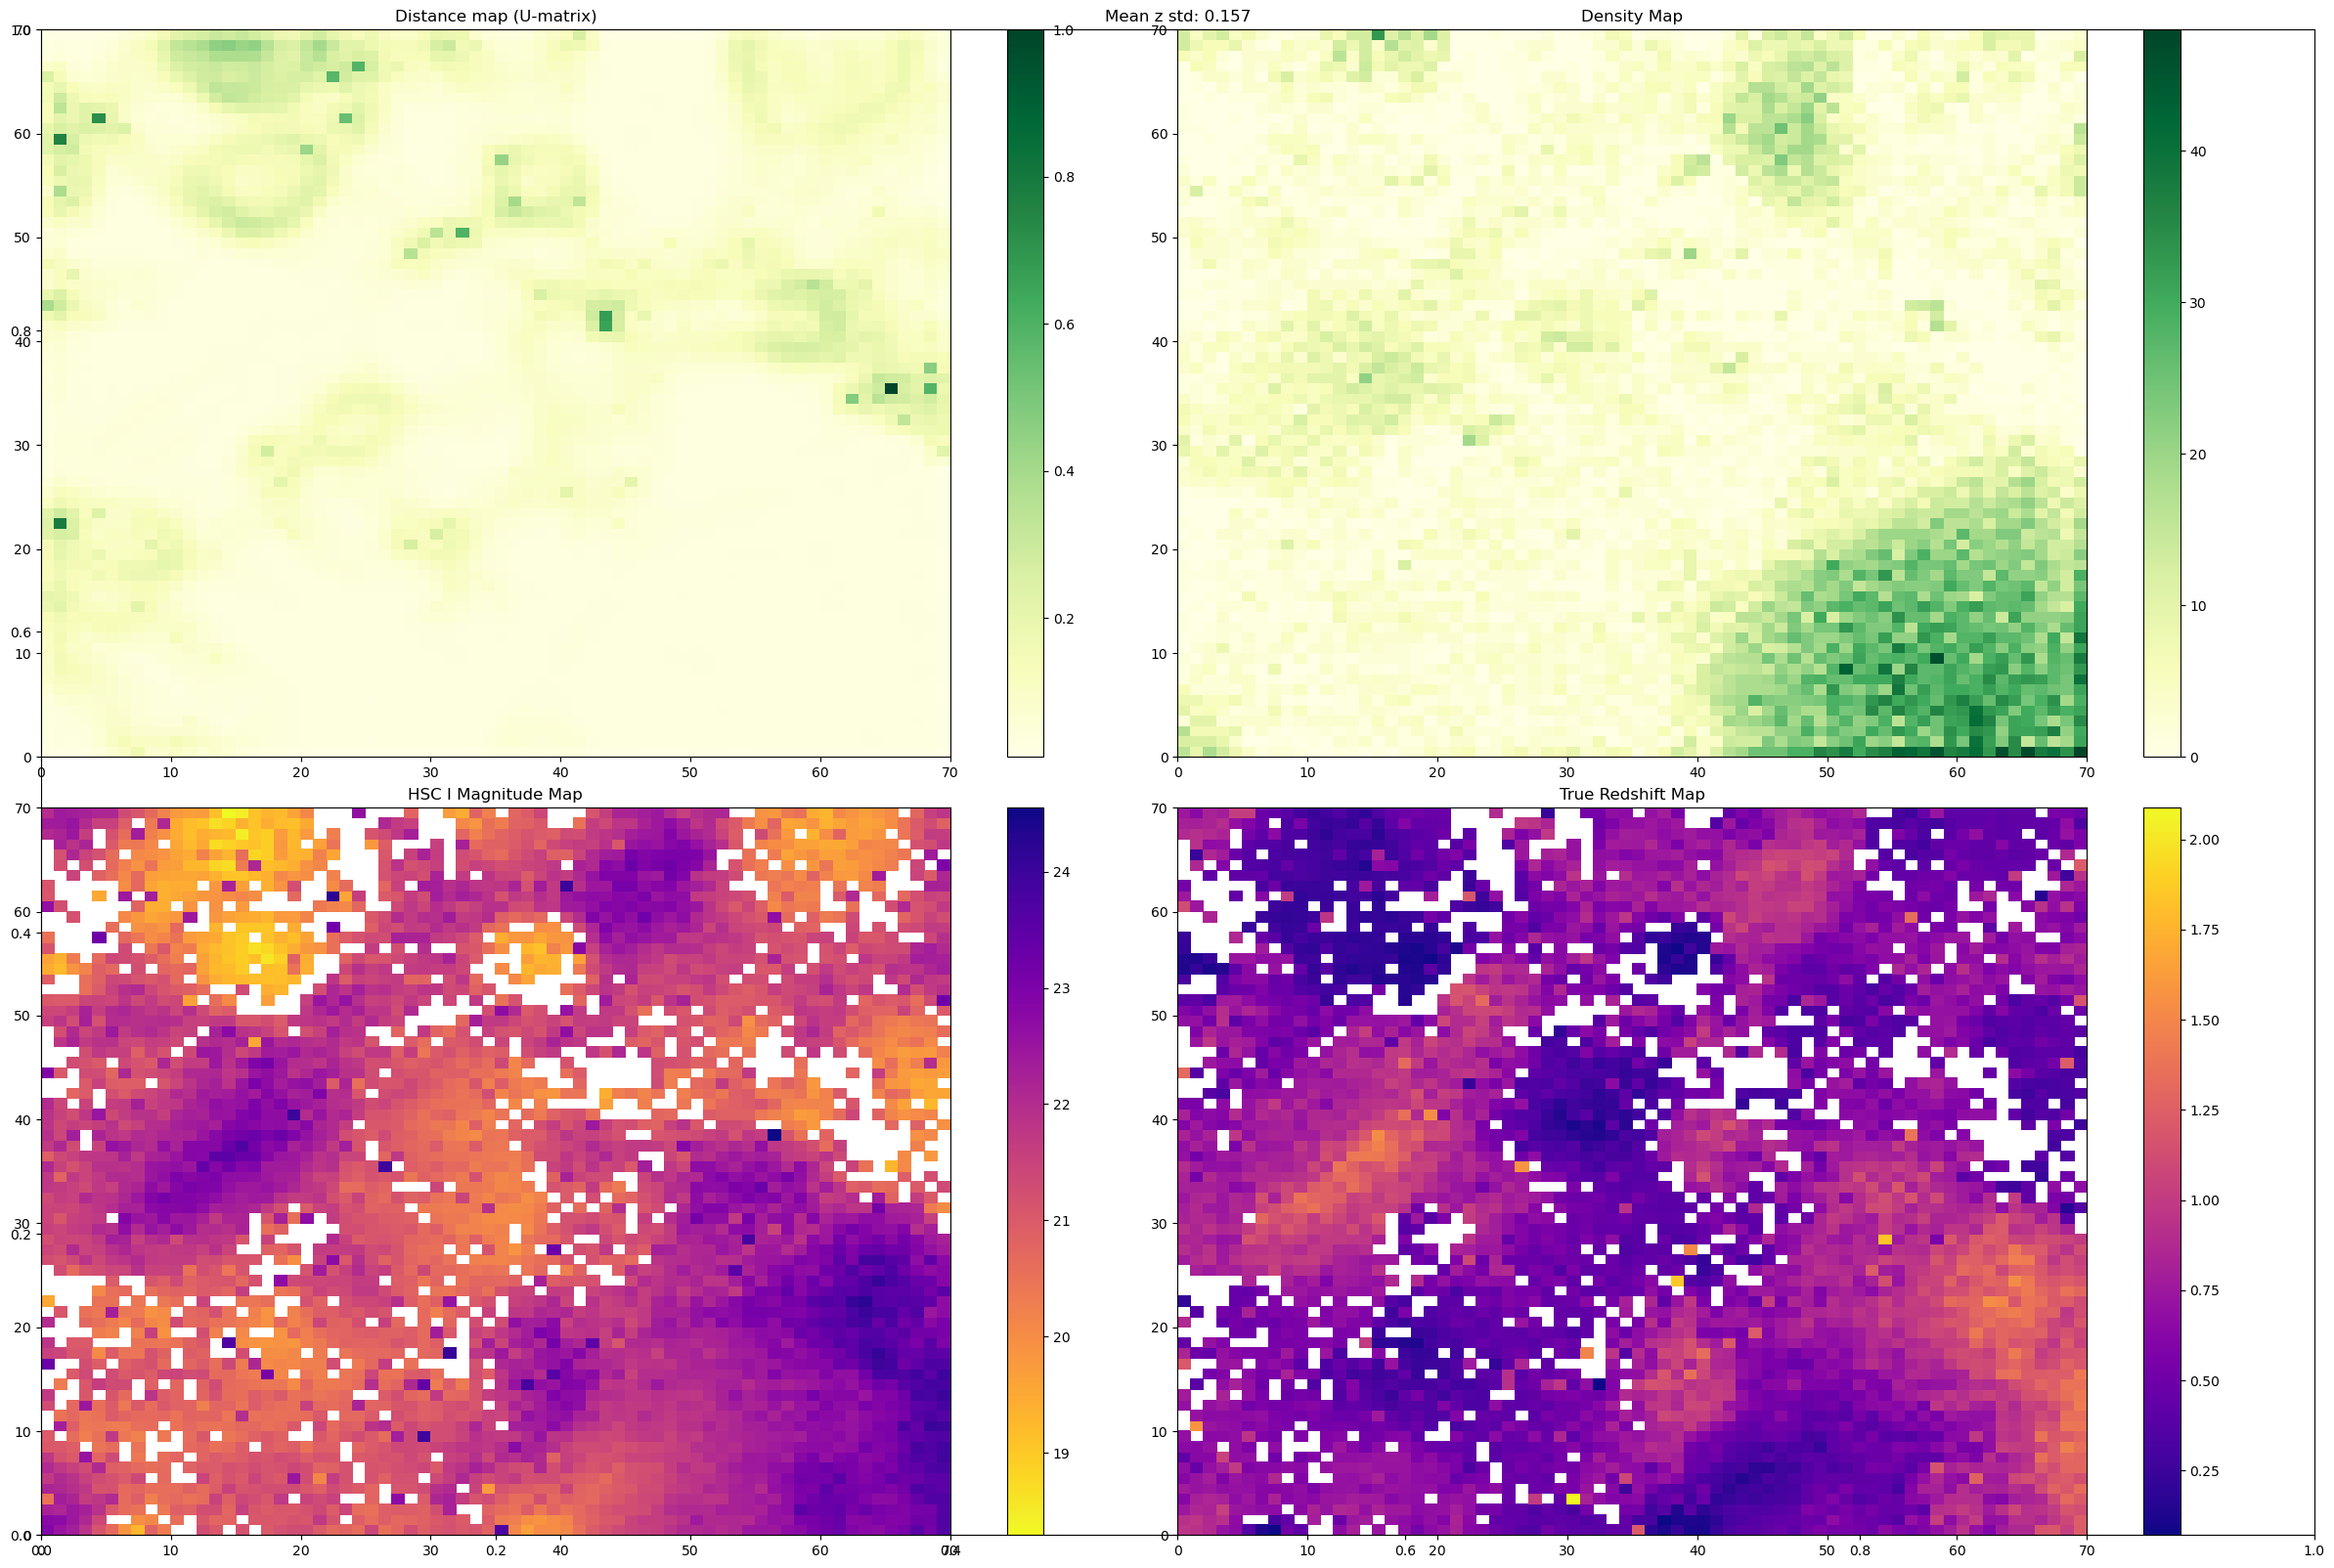

[70, 1.8, 0.1]
Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


29683.0
Topological error: 0.3302563757032645
Quantization error: 4.796616938364562
Average redshift std: 0.15396735010255896


C:\Users\ASUS\AppData\Local\Temp\ipykernel_34700\1734733816.py:59: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_34700\1734733816.py:64: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


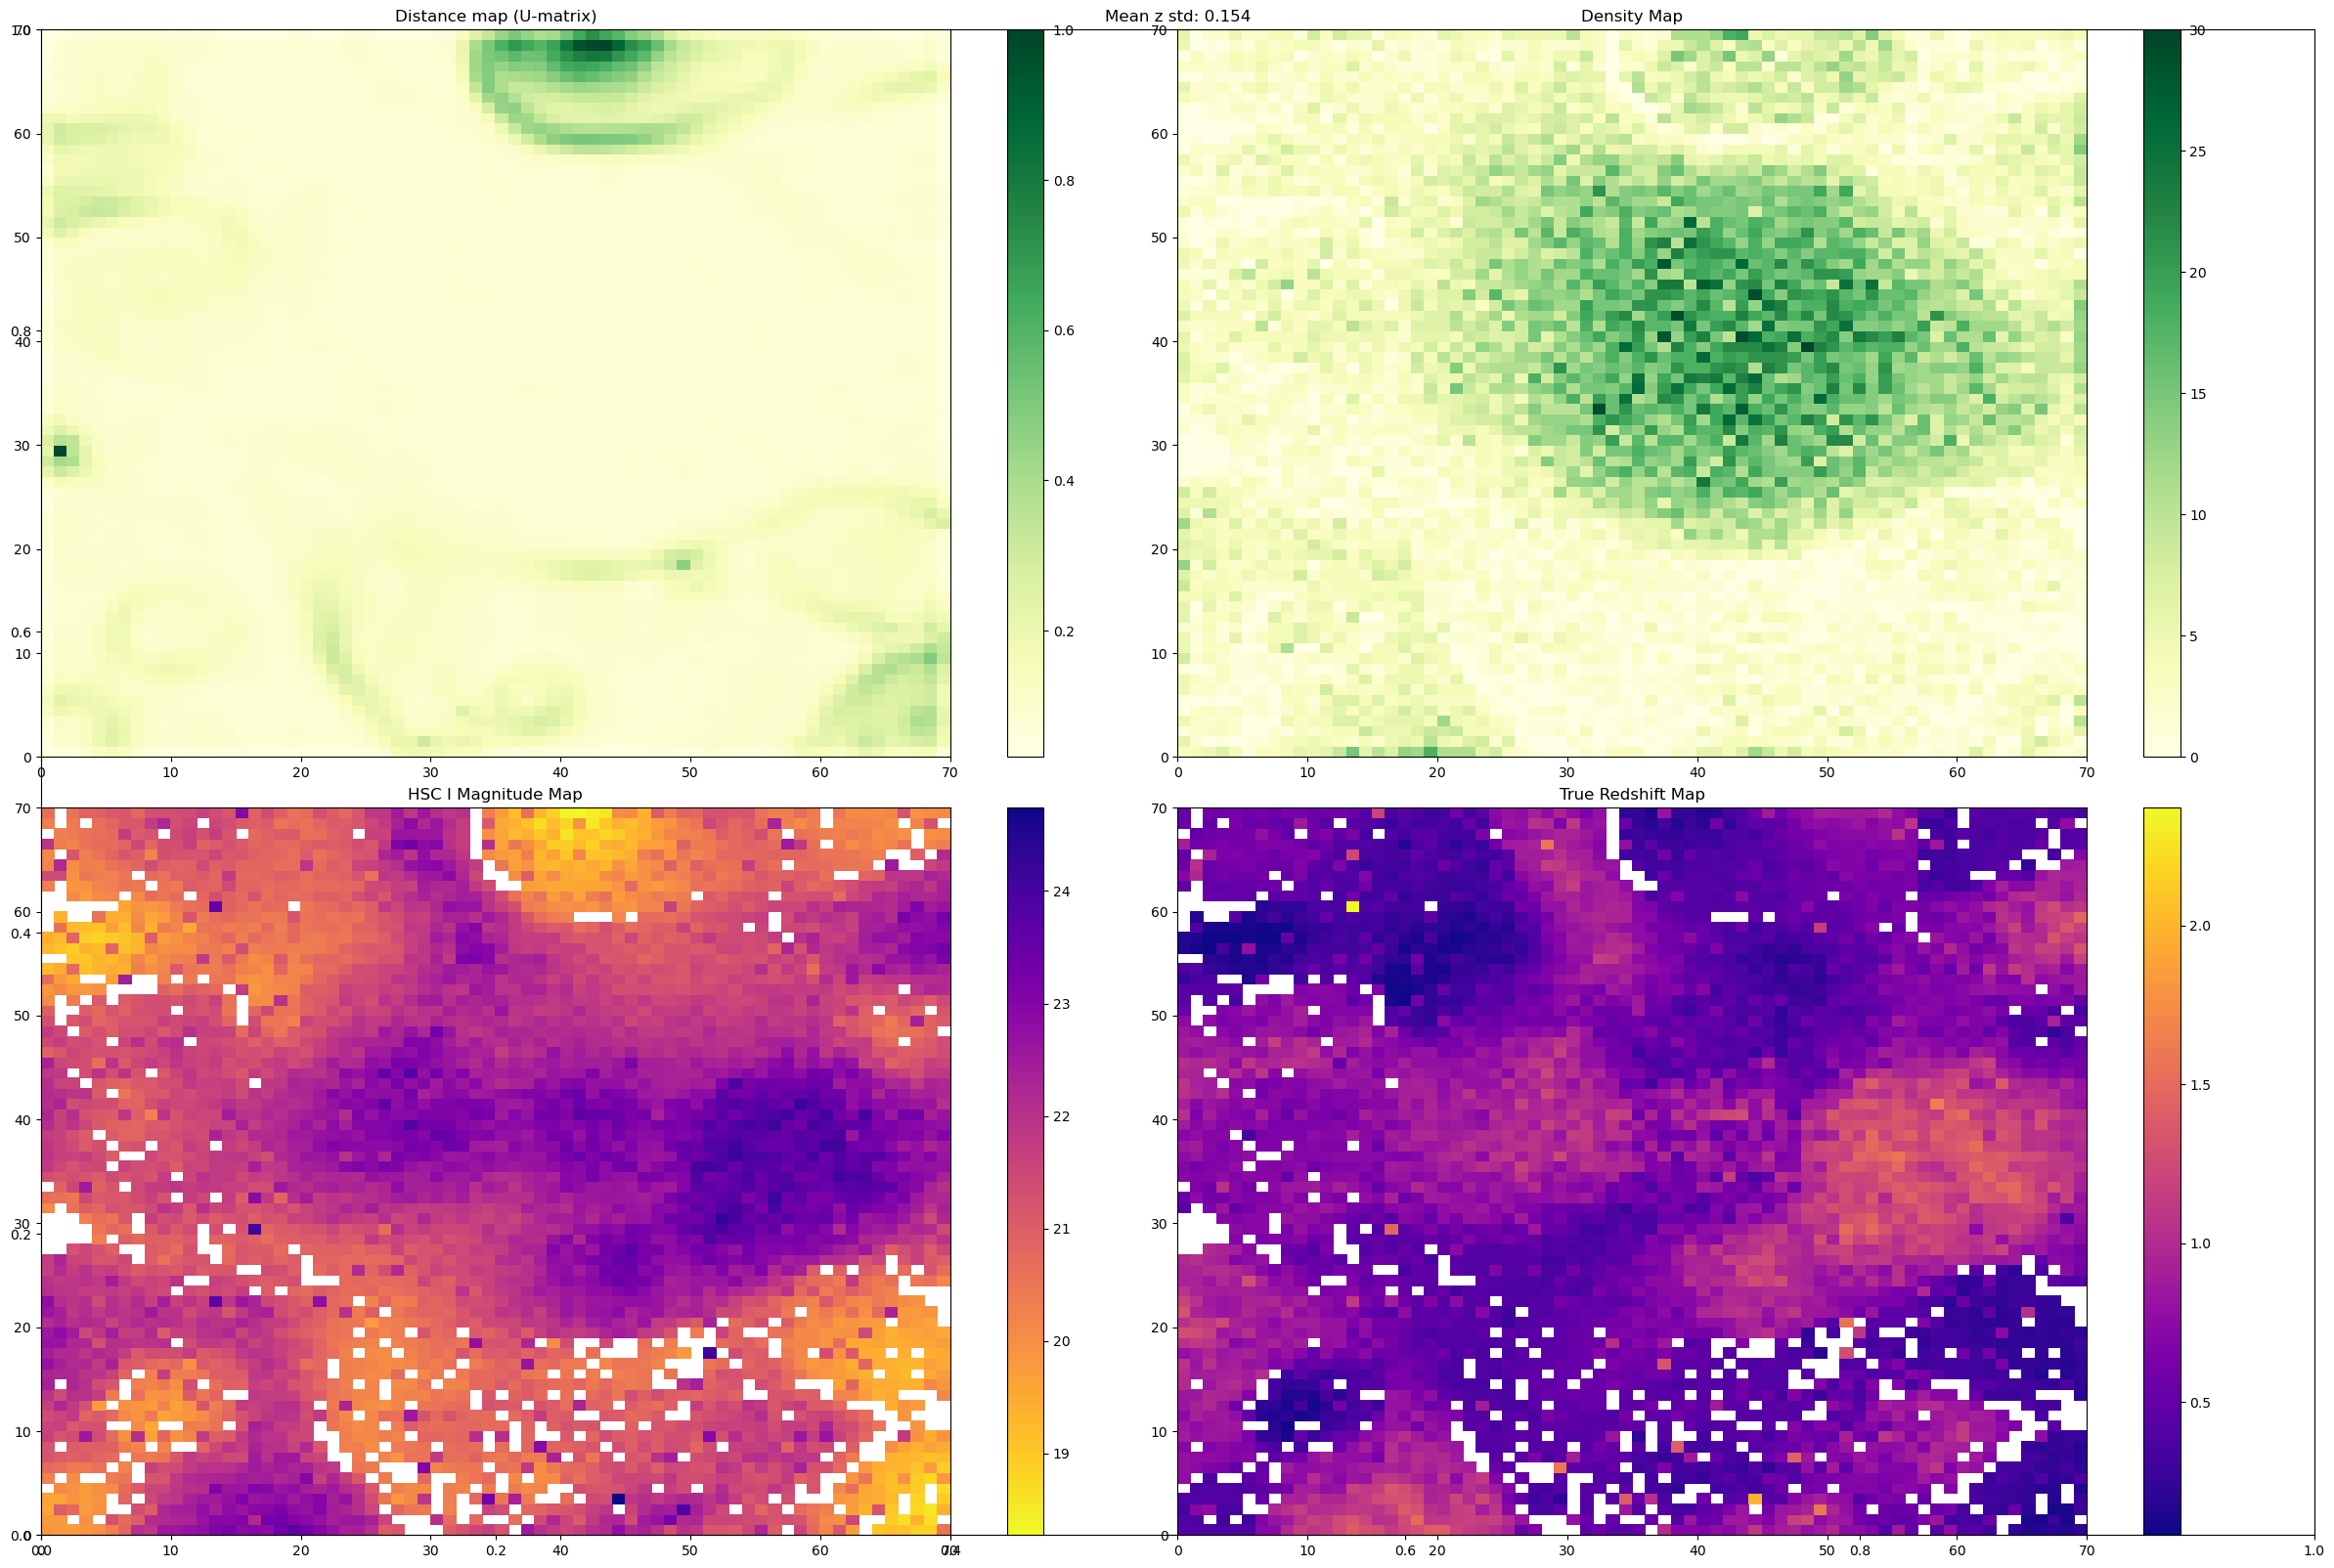

[70, 1.8, 0.15]
Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


29683.0
Topological error: 0.3524576356837247
Quantization error: 4.752320422637784
Average redshift std: 0.15355706528080795


C:\Users\ASUS\AppData\Local\Temp\ipykernel_34700\1734733816.py:59: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_34700\1734733816.py:64: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


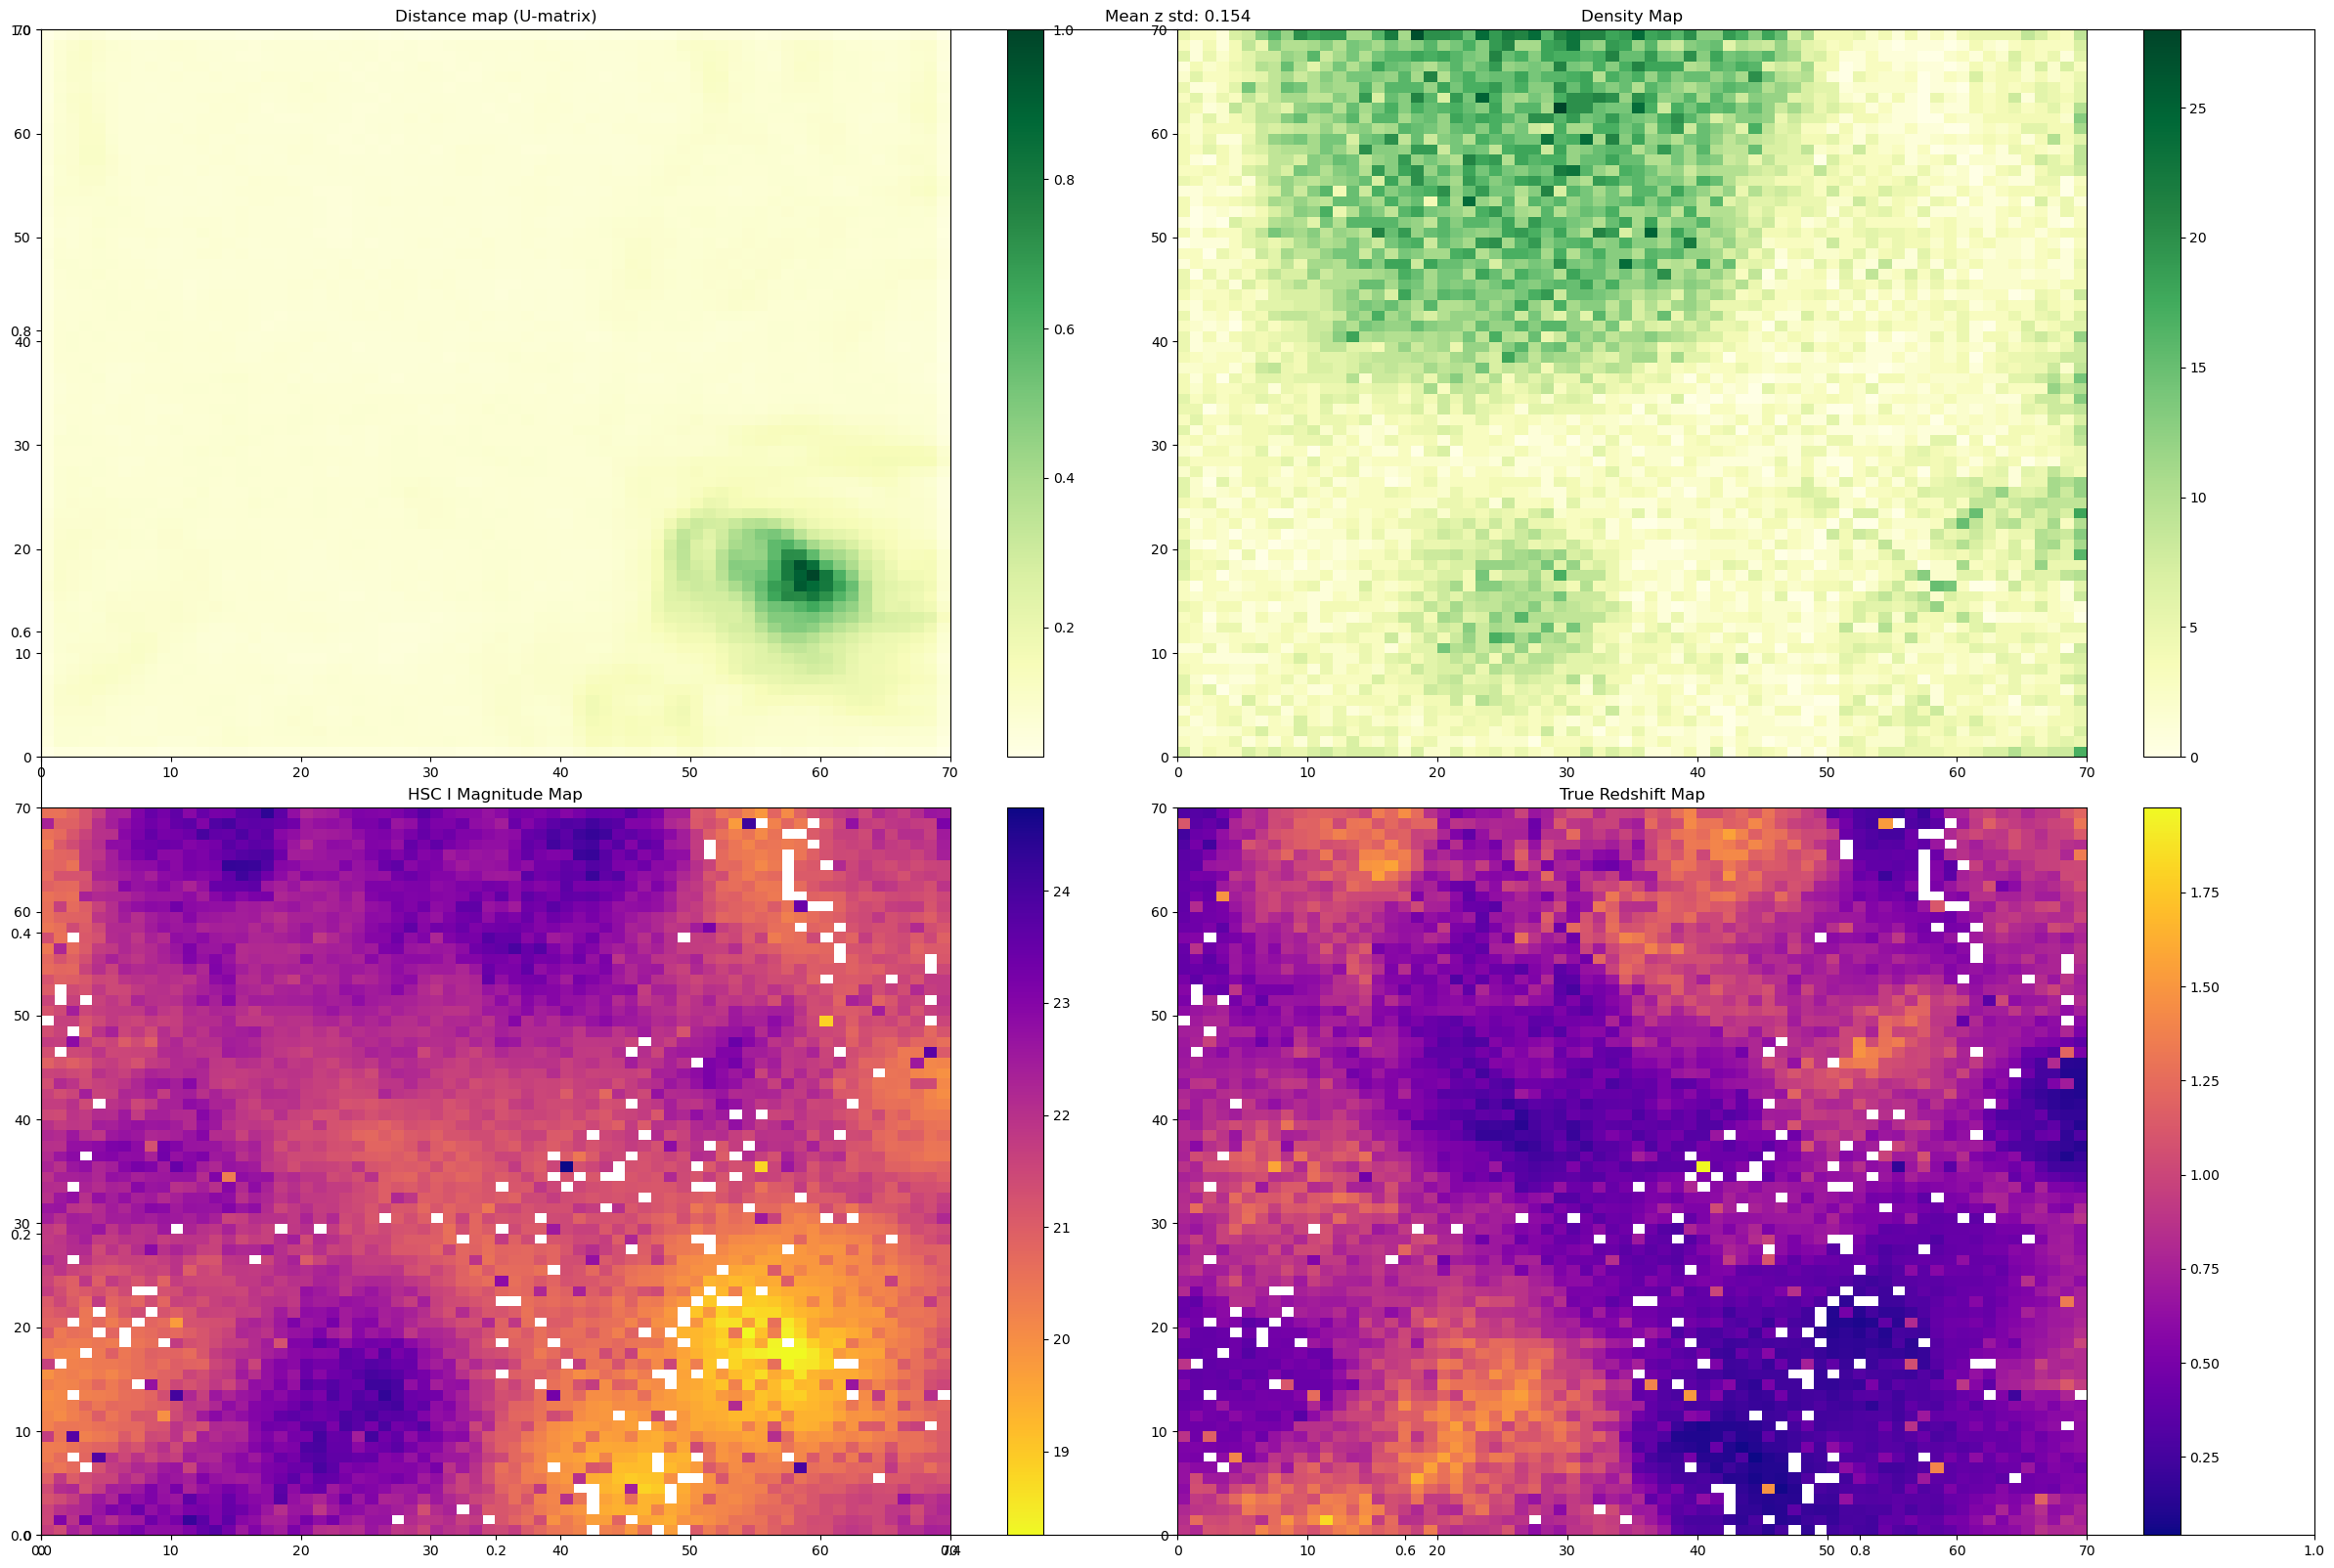

[70, 1.8, 0.2]
Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


29683.0
Topological error: 0.38240743860121956
Quantization error: 4.738006496000771
Average redshift std: 0.15318333907098844


C:\Users\ASUS\AppData\Local\Temp\ipykernel_34700\1734733816.py:59: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_34700\1734733816.py:64: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


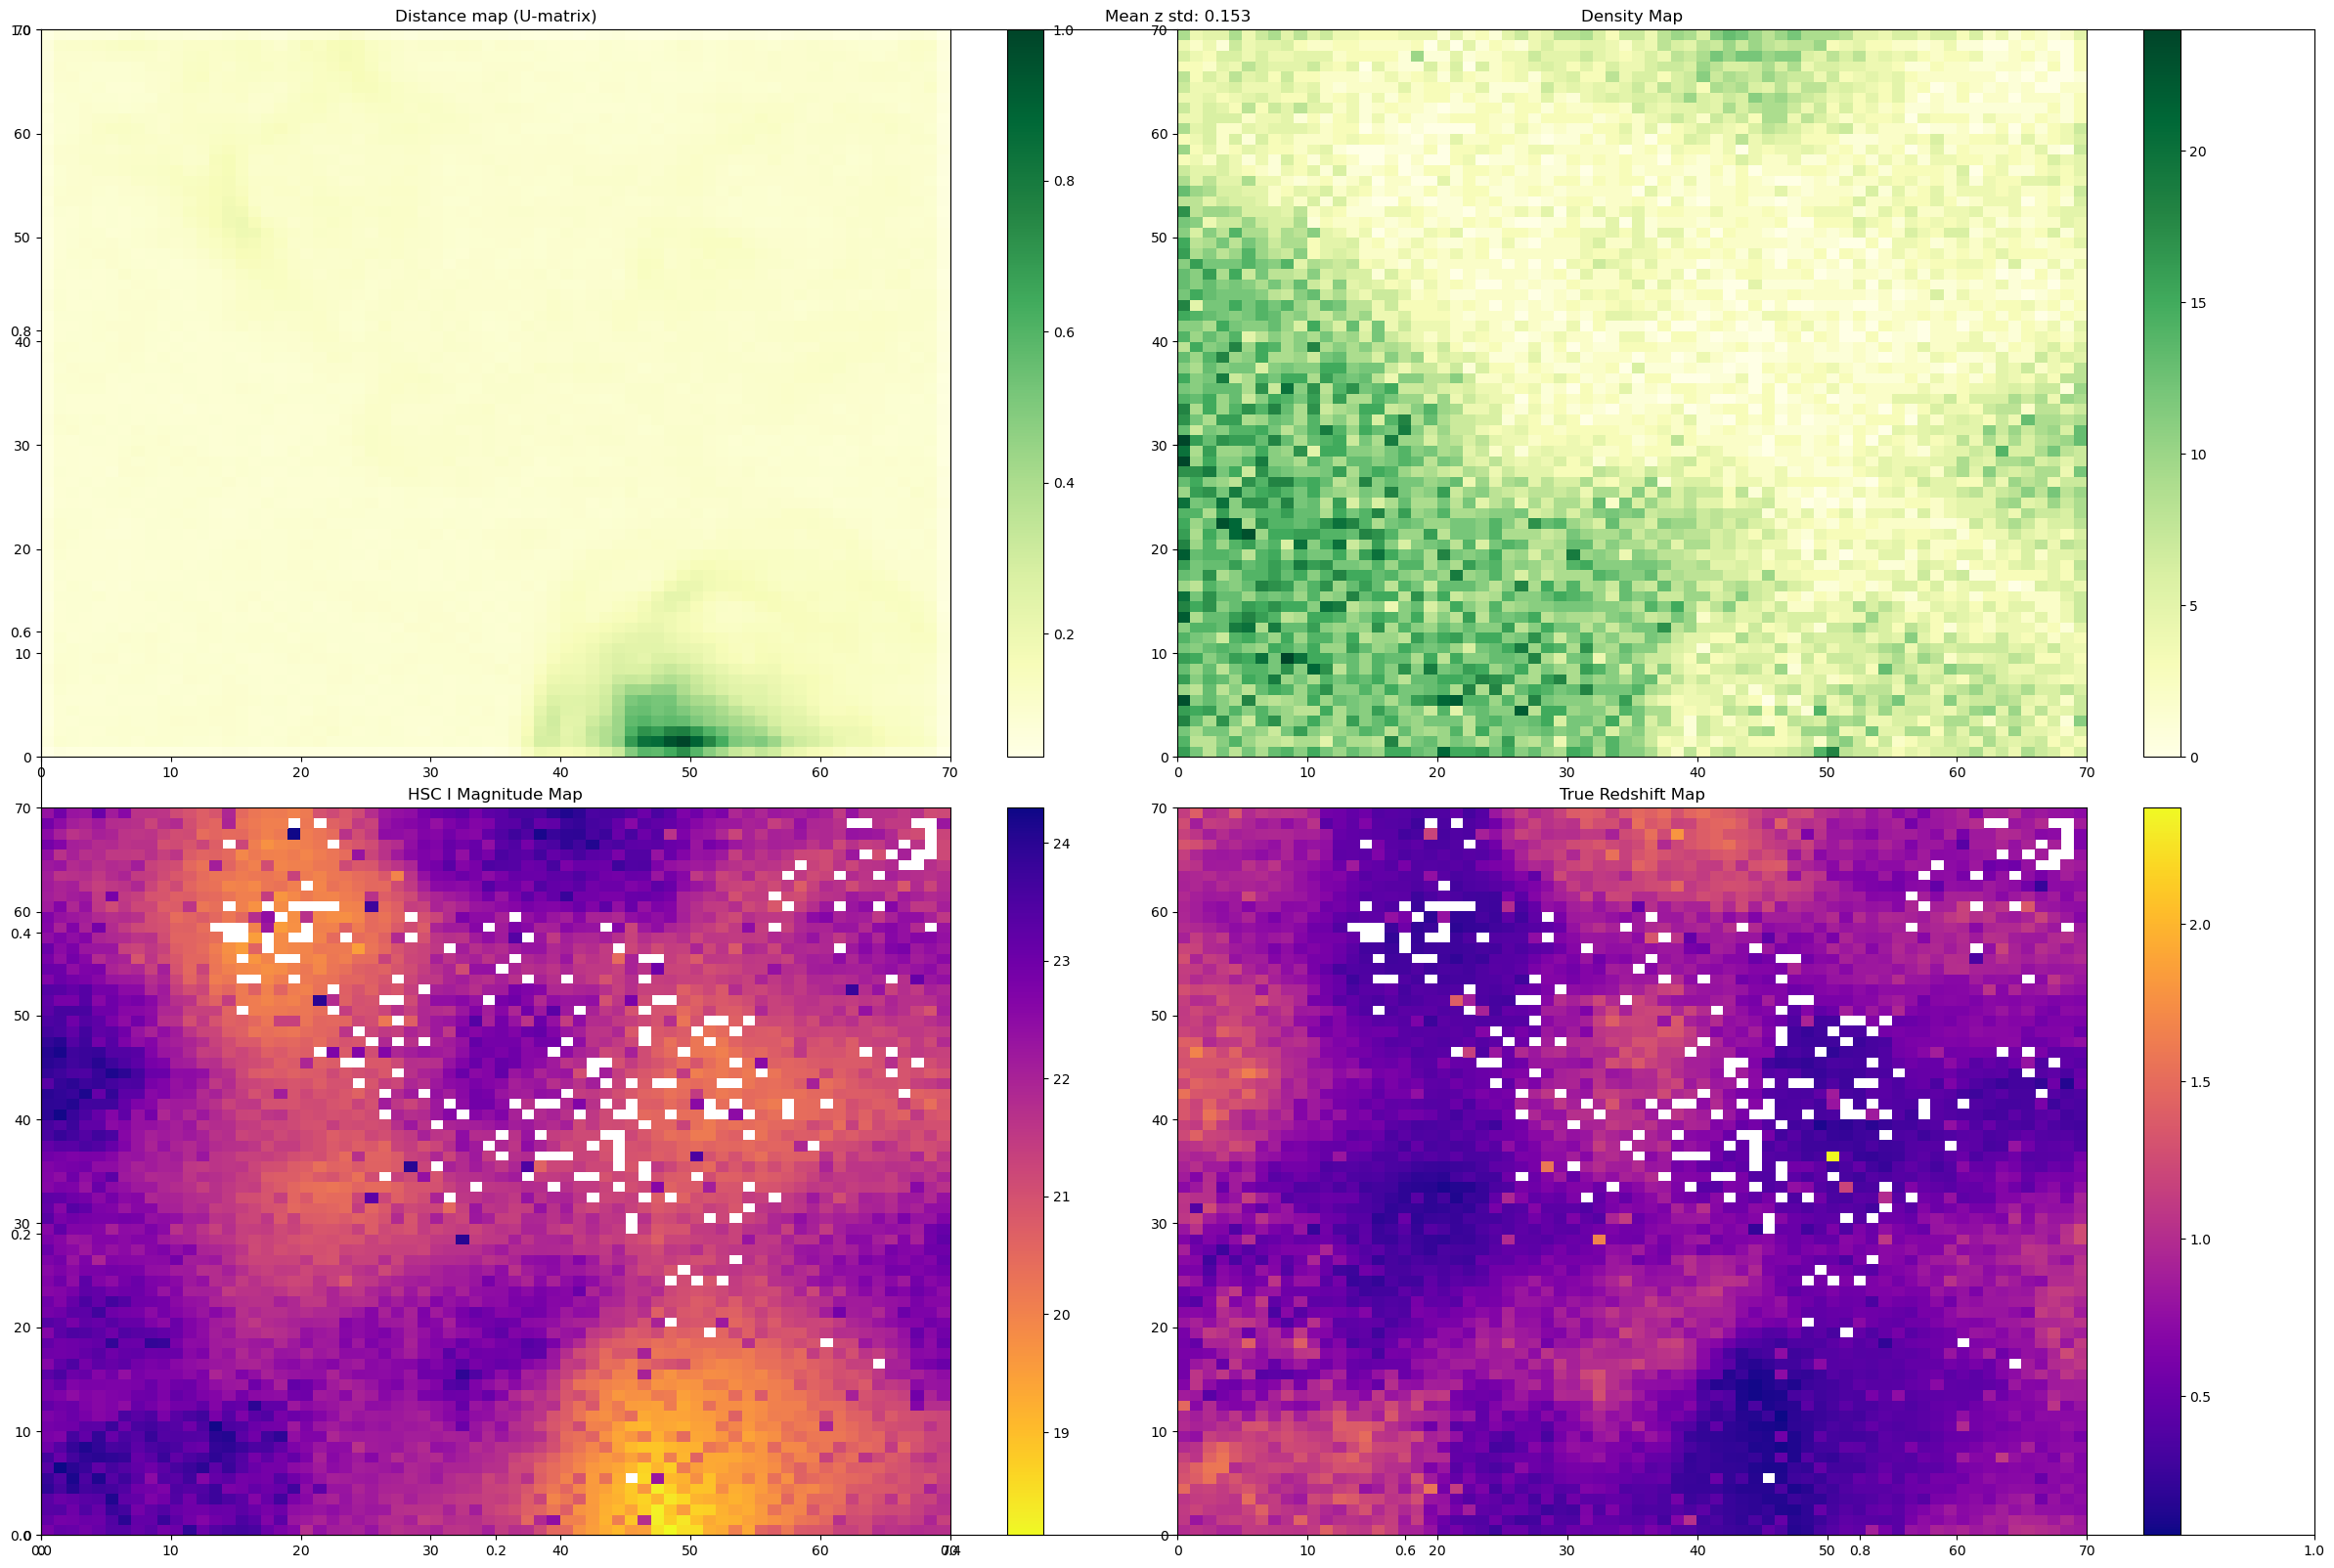

[70, 1.8, 0.25]
Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


29683.0
Topological error: 0.39443452481218205
Quantization error: 4.714009244459042
Average redshift std: 0.15216097374282994


C:\Users\ASUS\AppData\Local\Temp\ipykernel_34700\1734733816.py:59: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_34700\1734733816.py:64: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


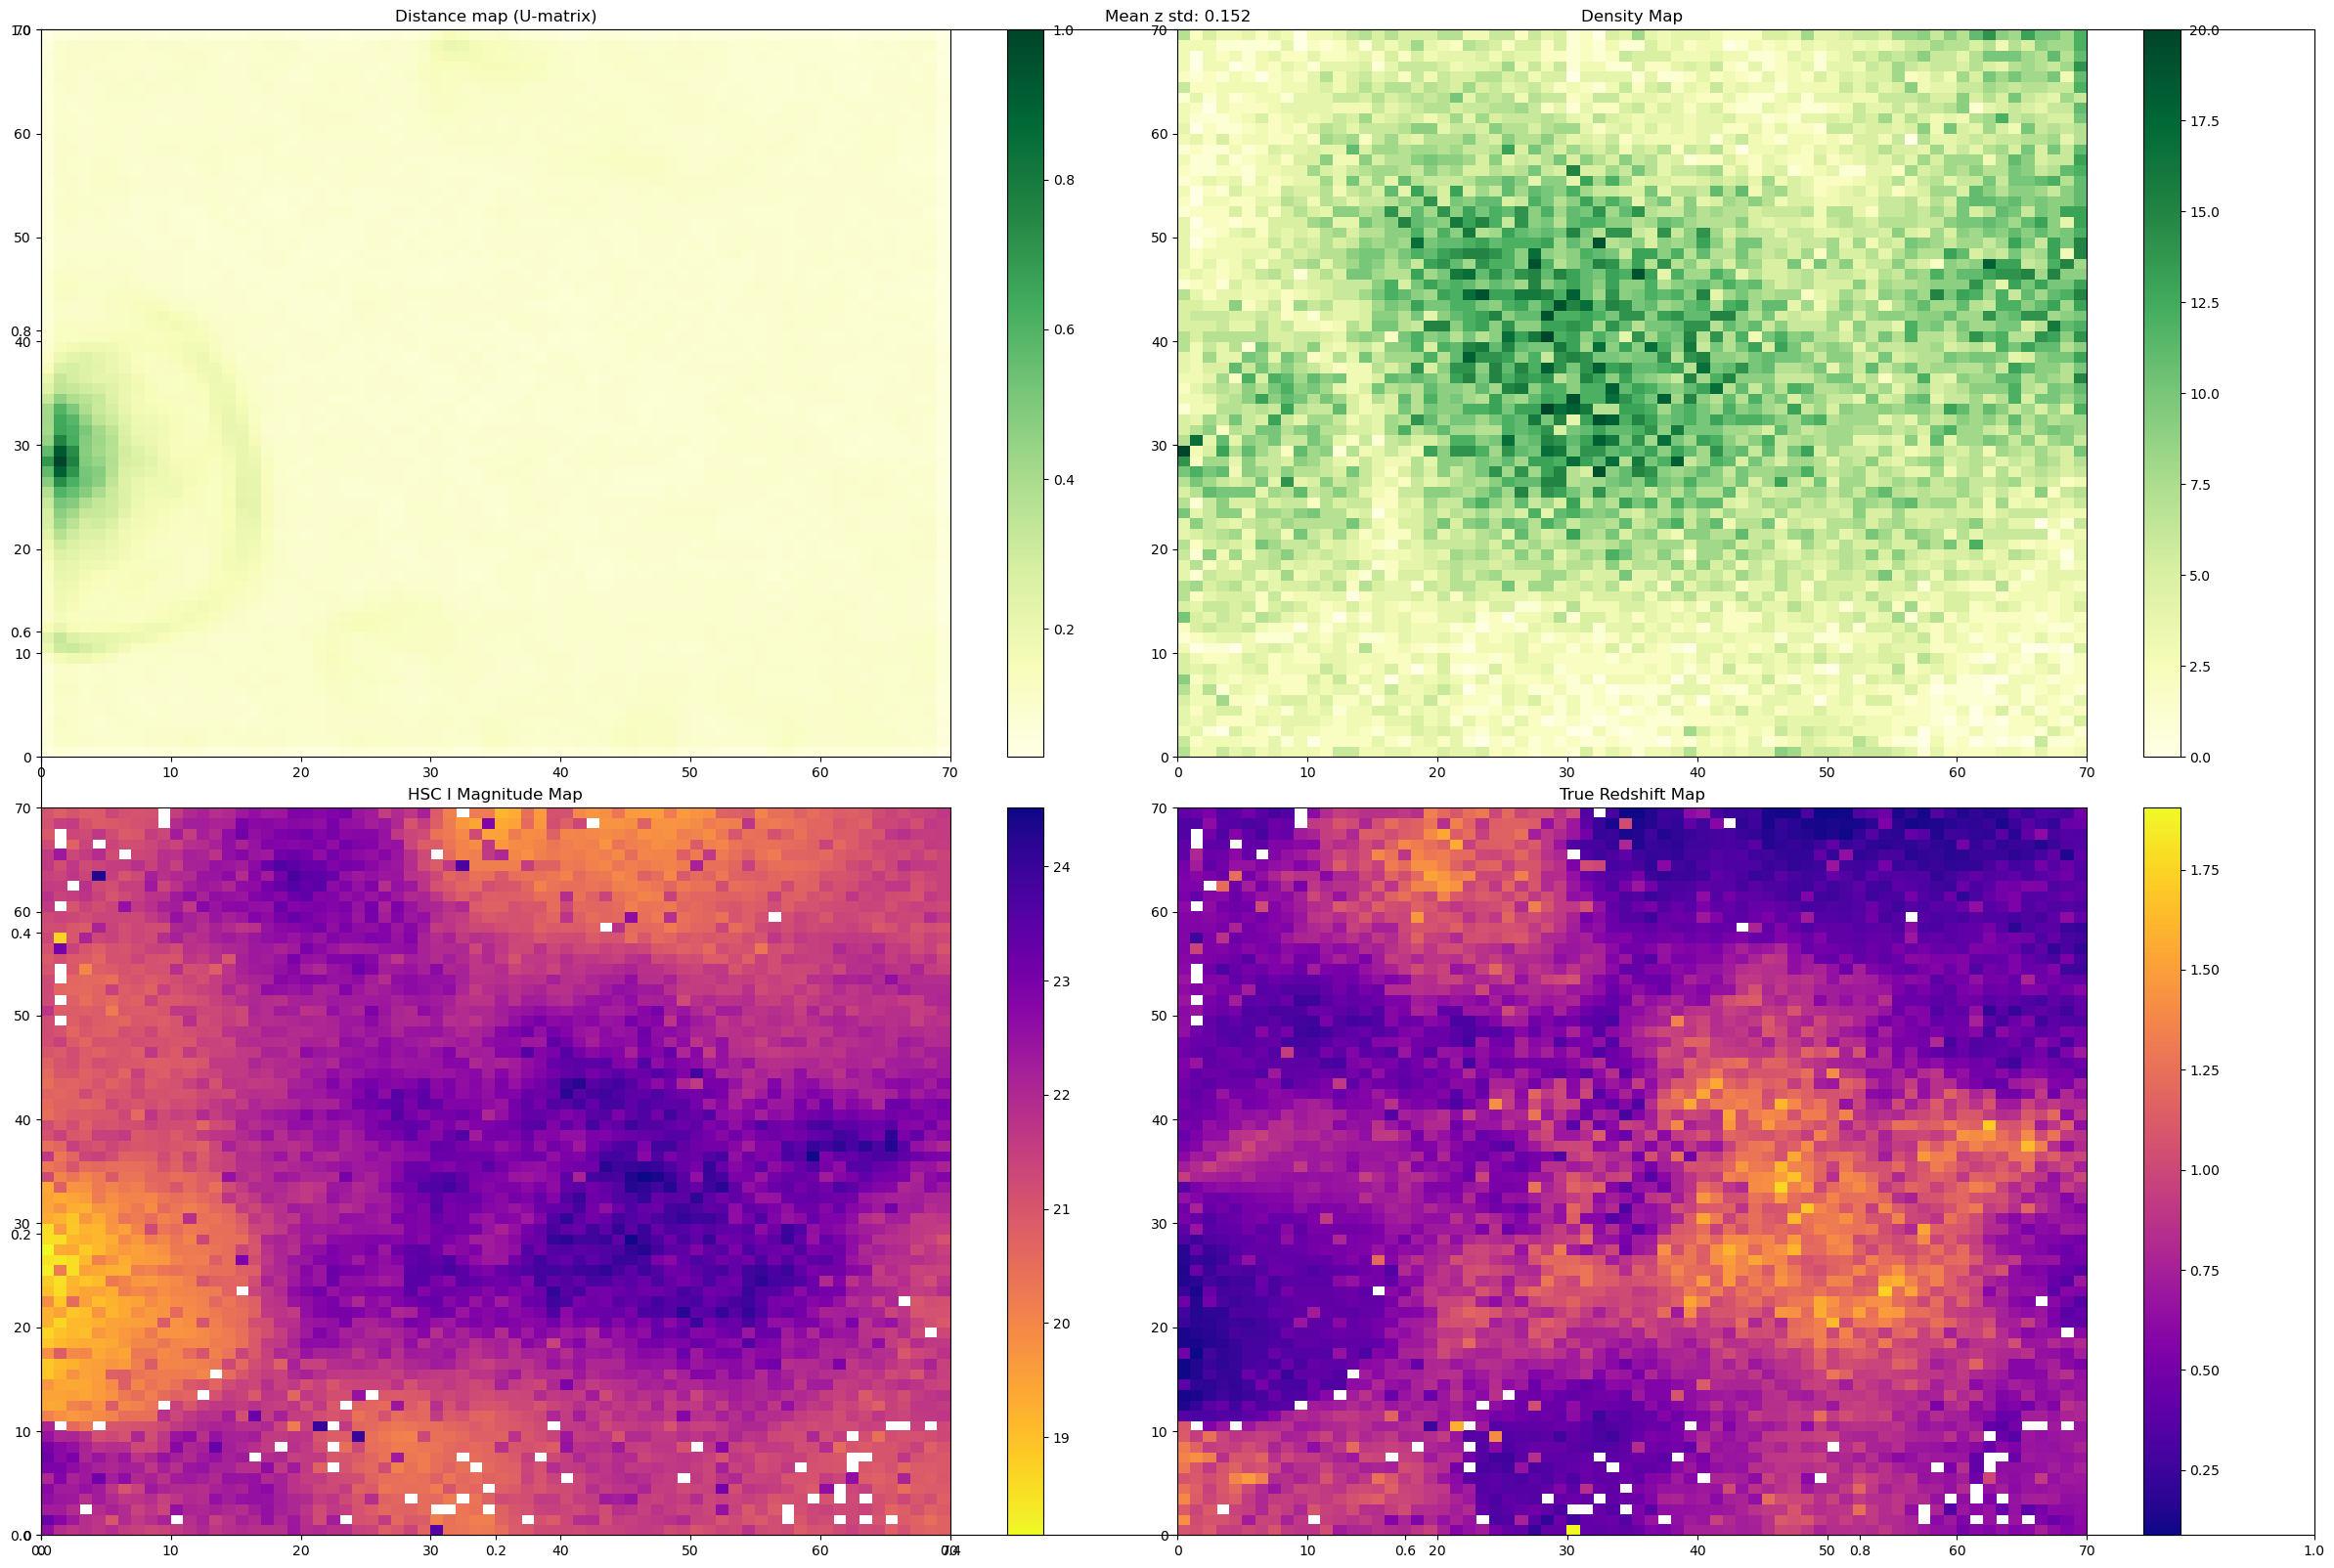

[70, 1.8, 0.3]
Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


29683.0
Topological error: 0.39773607788970117
Quantization error: 4.70082561492626
Average redshift std: 0.15219171039707857


C:\Users\ASUS\AppData\Local\Temp\ipykernel_34700\1734733816.py:59: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_34700\1734733816.py:64: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


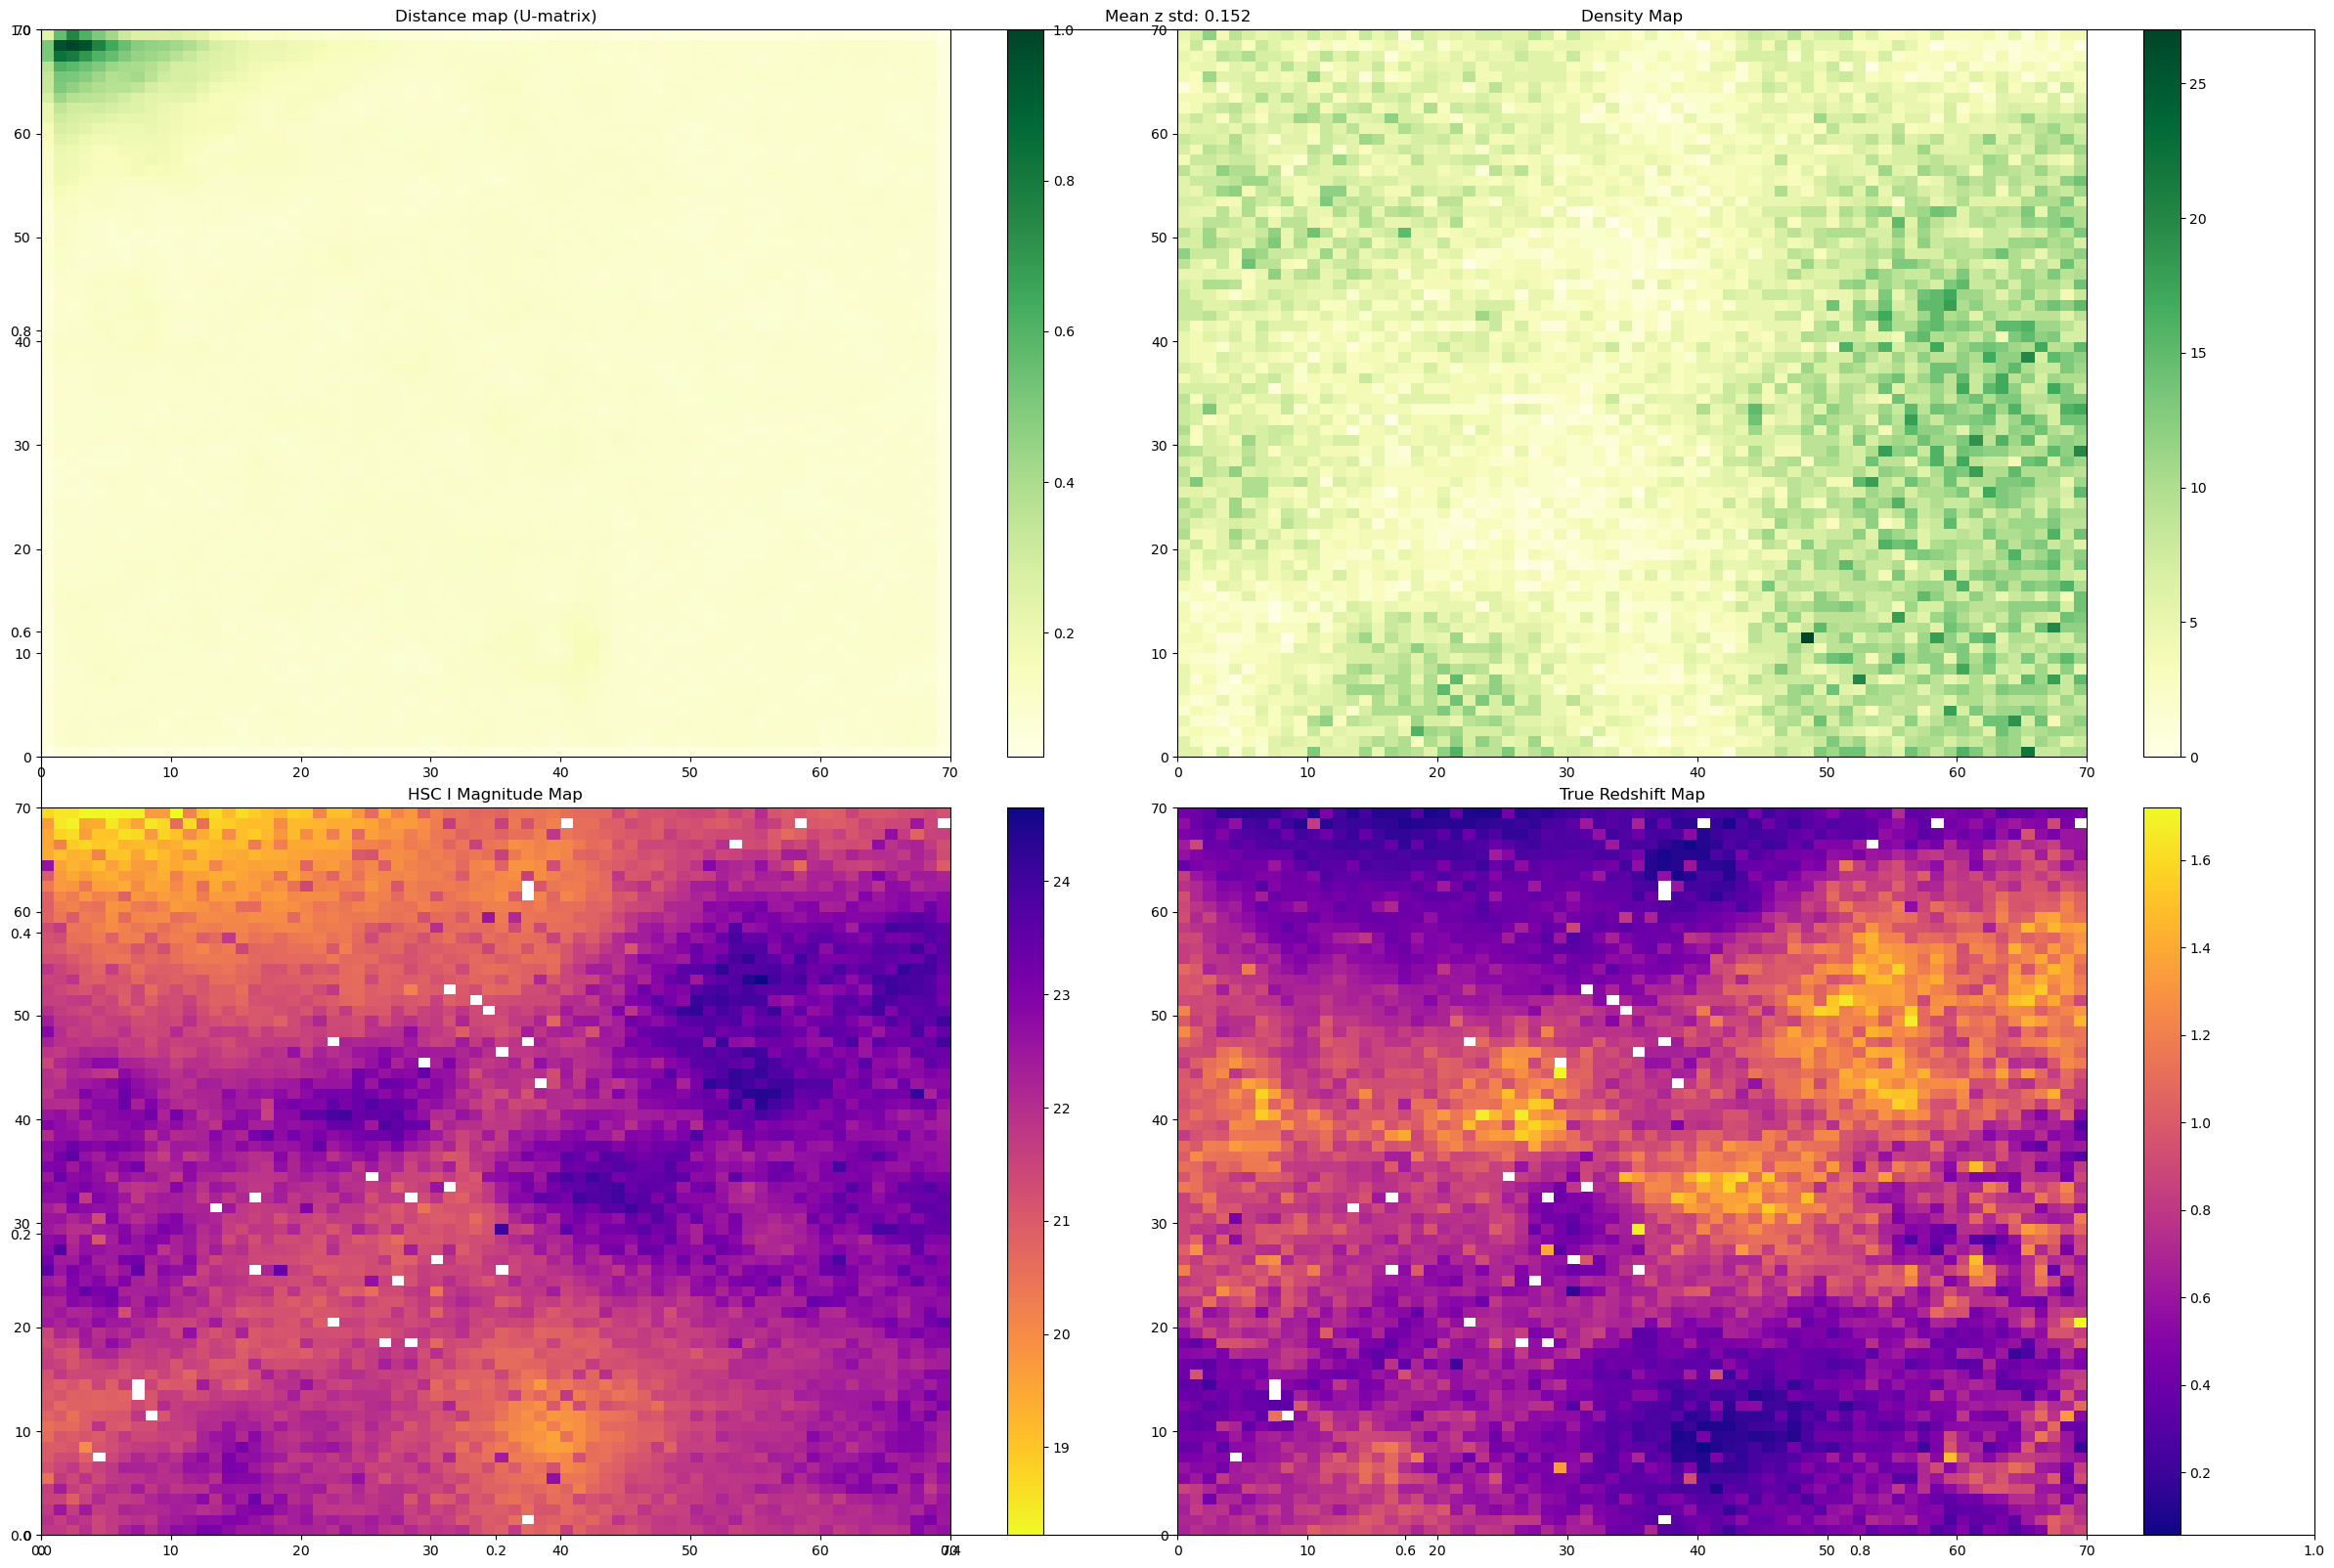

[70, 1.8, 0.35]
Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


29683.0
Topological error: 0.43314355018023787
Quantization error: 4.692326864506684
Average redshift std: 0.15318063704614457


C:\Users\ASUS\AppData\Local\Temp\ipykernel_34700\1734733816.py:59: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_34700\1734733816.py:64: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


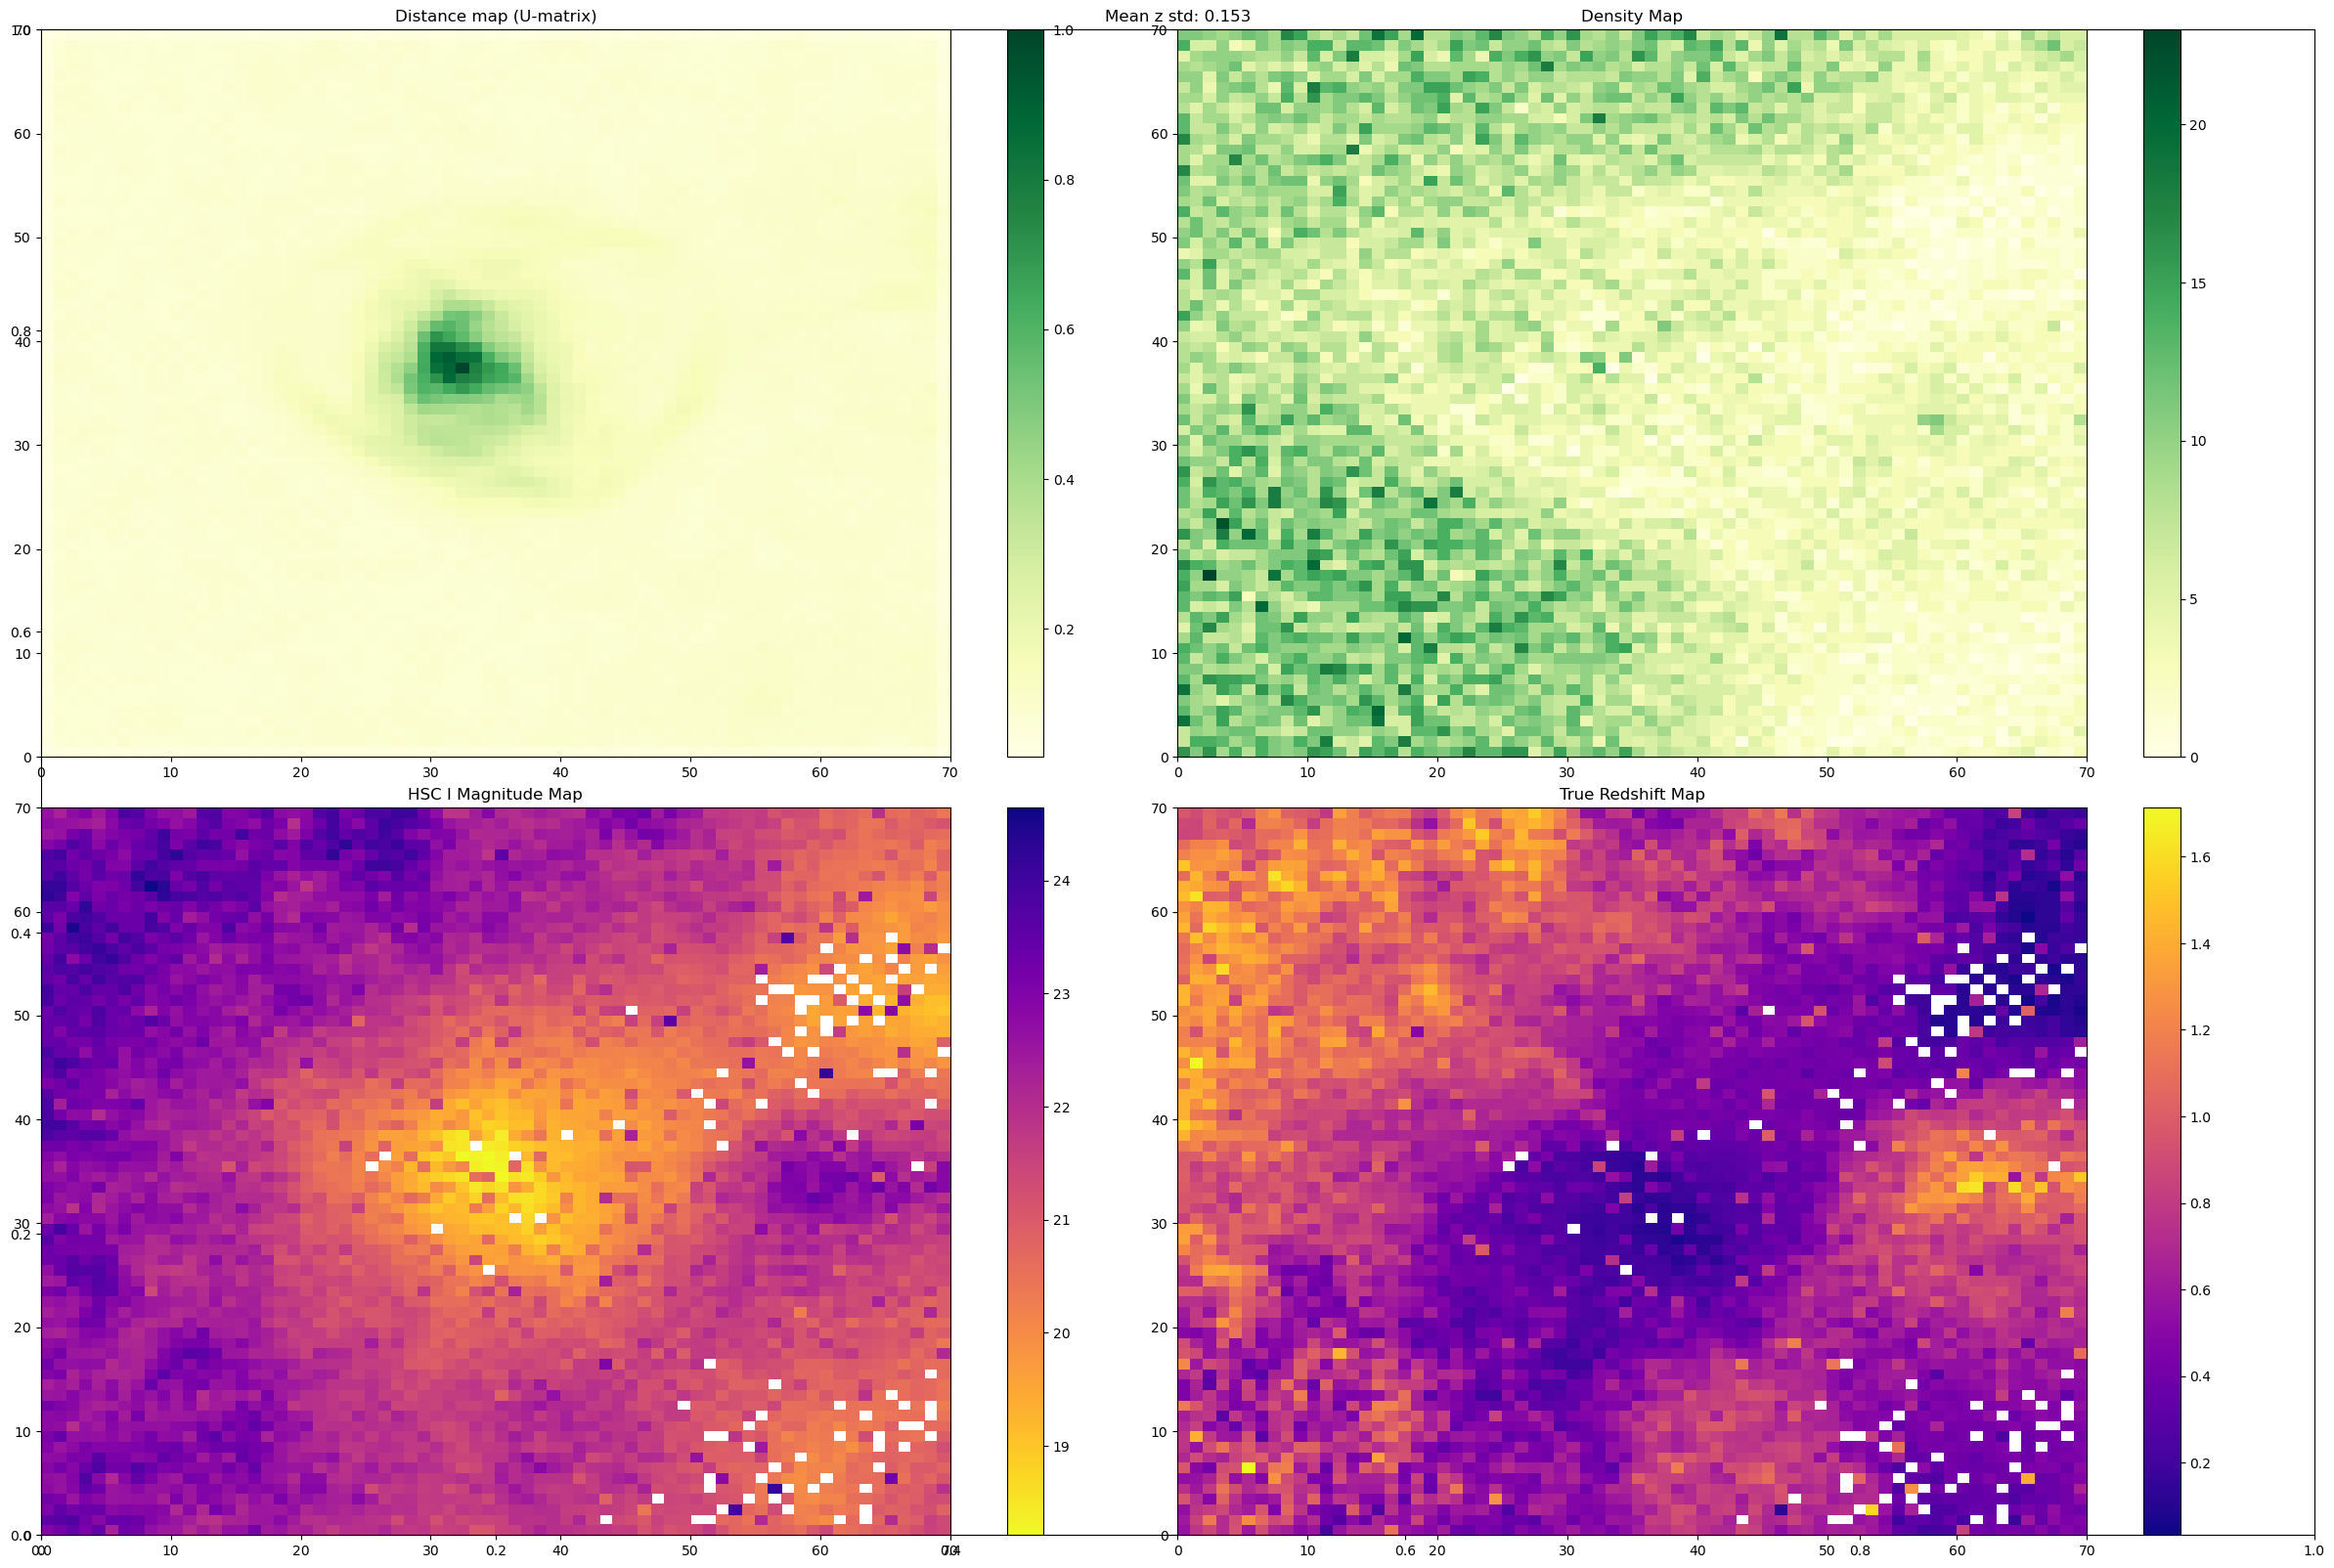

[70, 1.8, 0.4]
Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


29683.0
Topological error: 0.43007782232254155
Quantization error: 4.682617041751761
Average redshift std: 0.15154882372625955


C:\Users\ASUS\AppData\Local\Temp\ipykernel_34700\1734733816.py:59: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_34700\1734733816.py:64: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


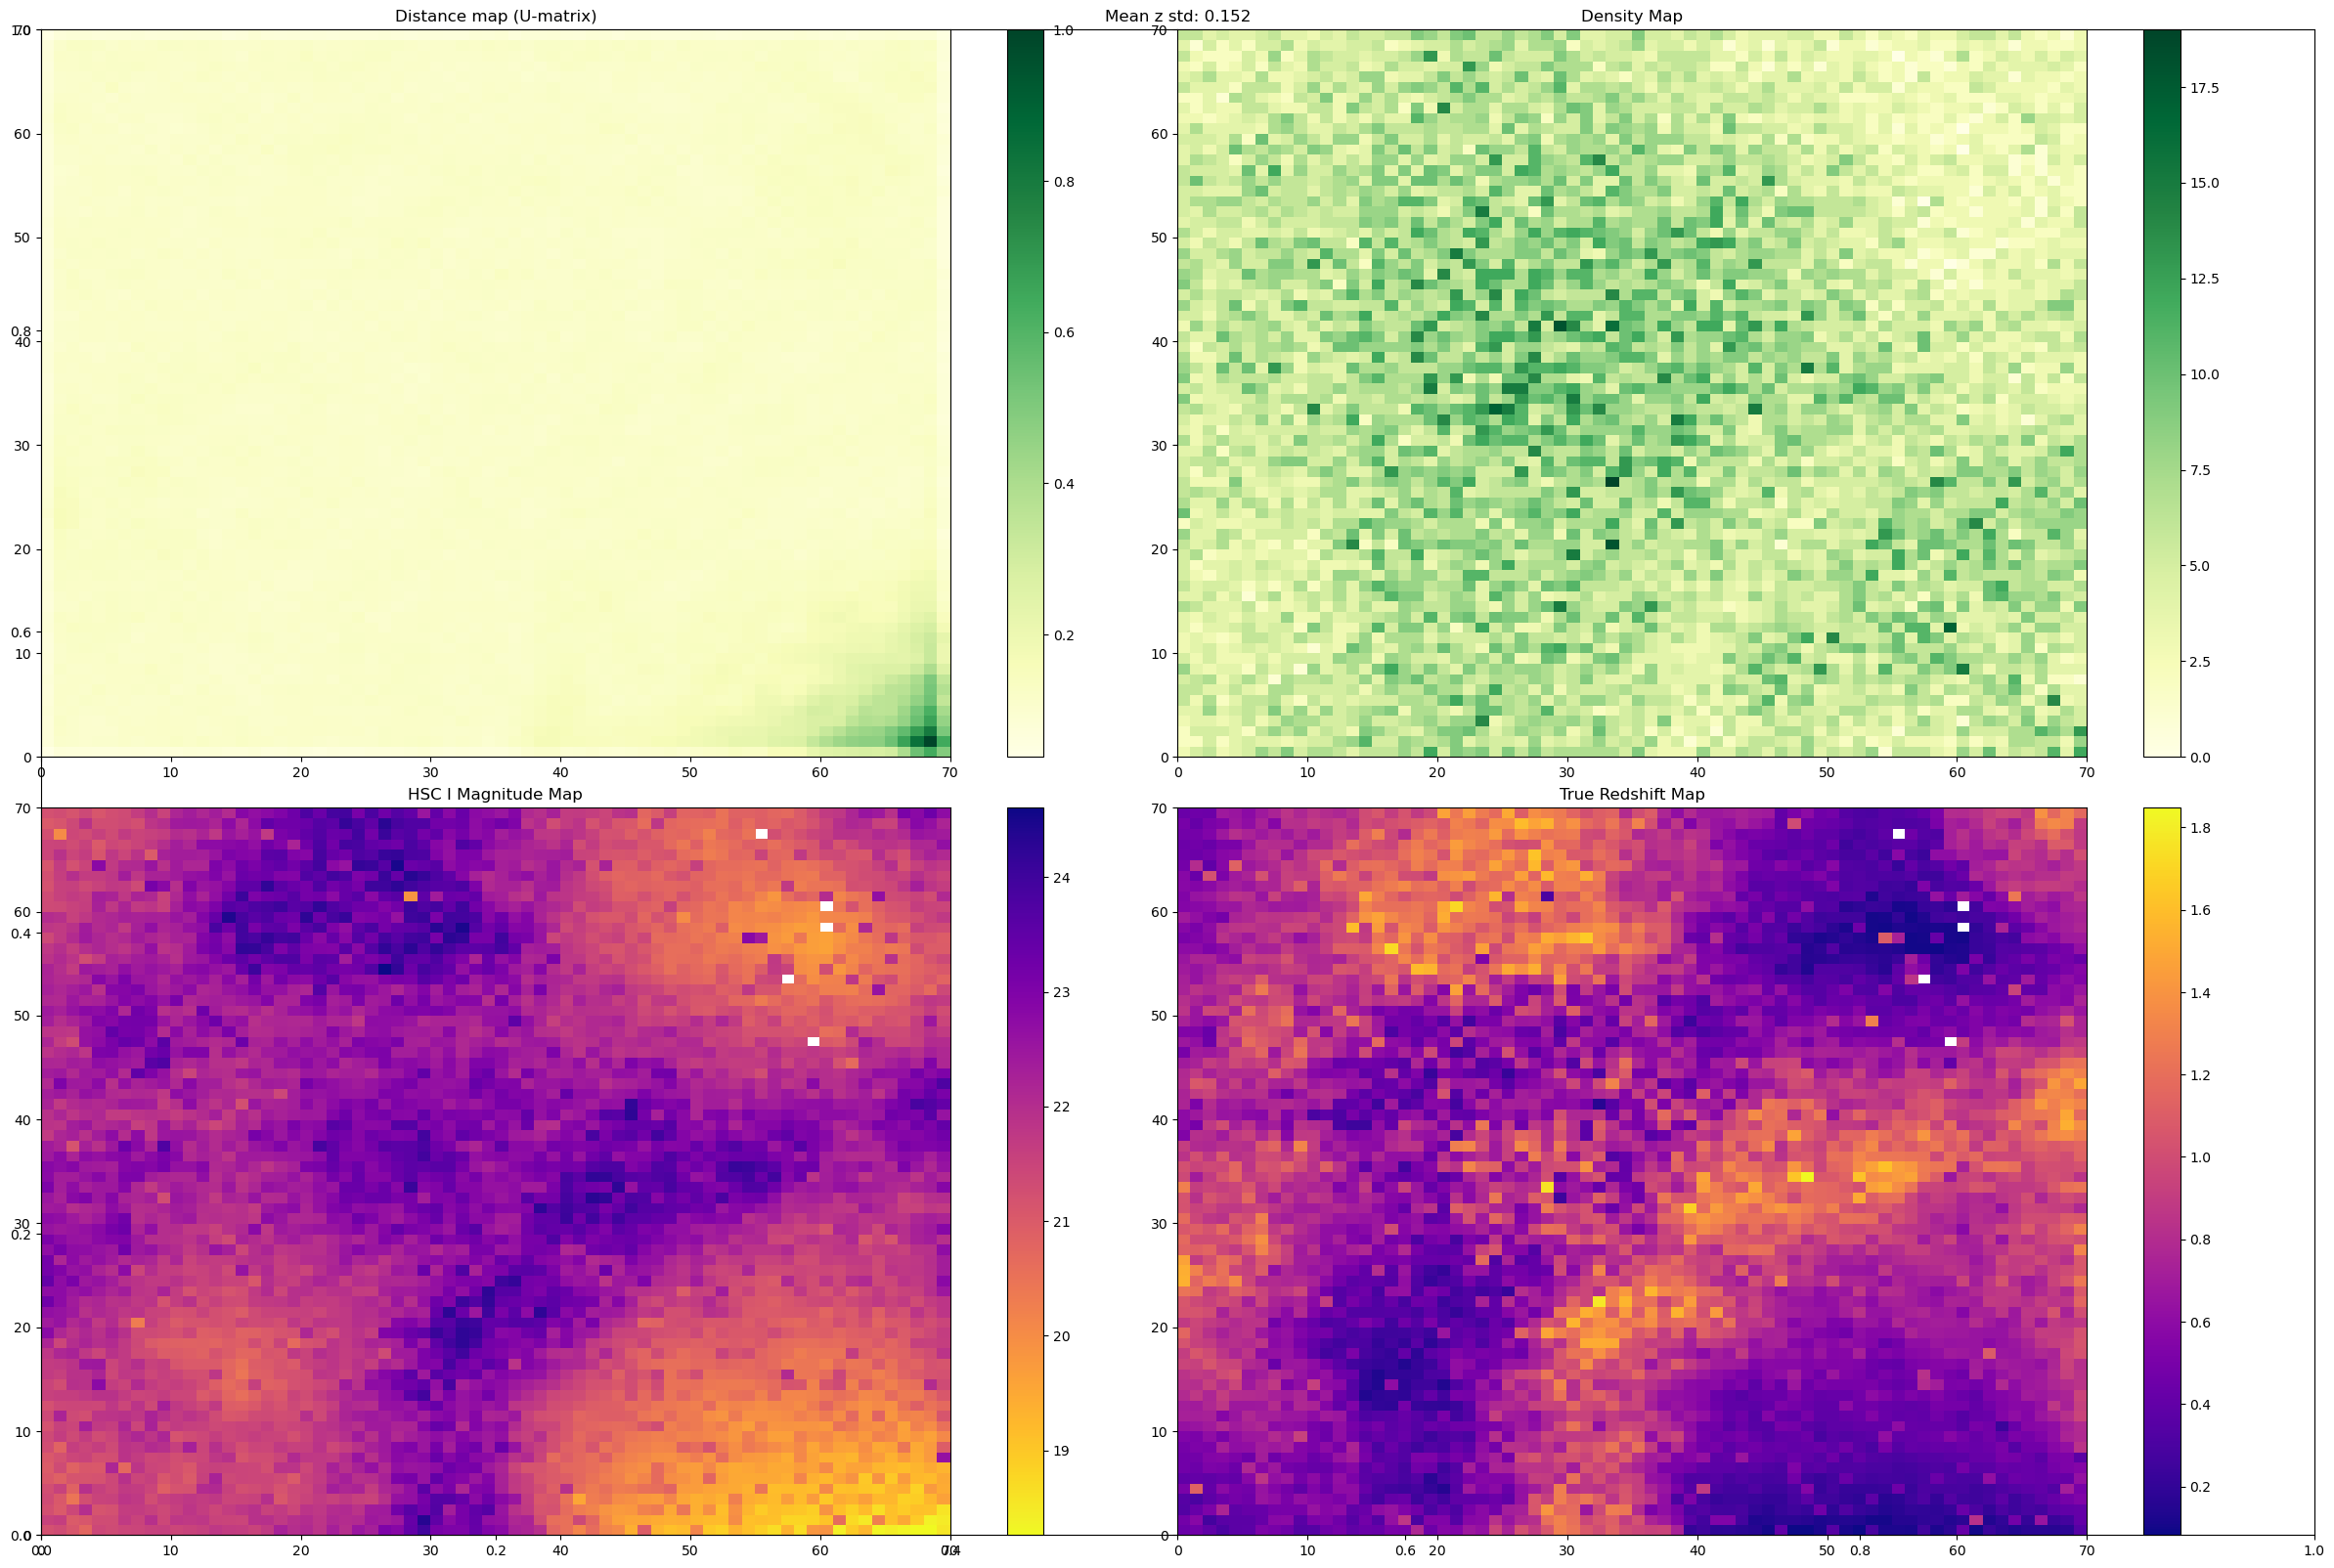

[70, 1.8, 0.45]
Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


29683.0
Topological error: 0.4421722871677391
Quantization error: 4.676090956351697
Average redshift std: 0.15014471995397127


C:\Users\ASUS\AppData\Local\Temp\ipykernel_34700\1734733816.py:59: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_34700\1734733816.py:64: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


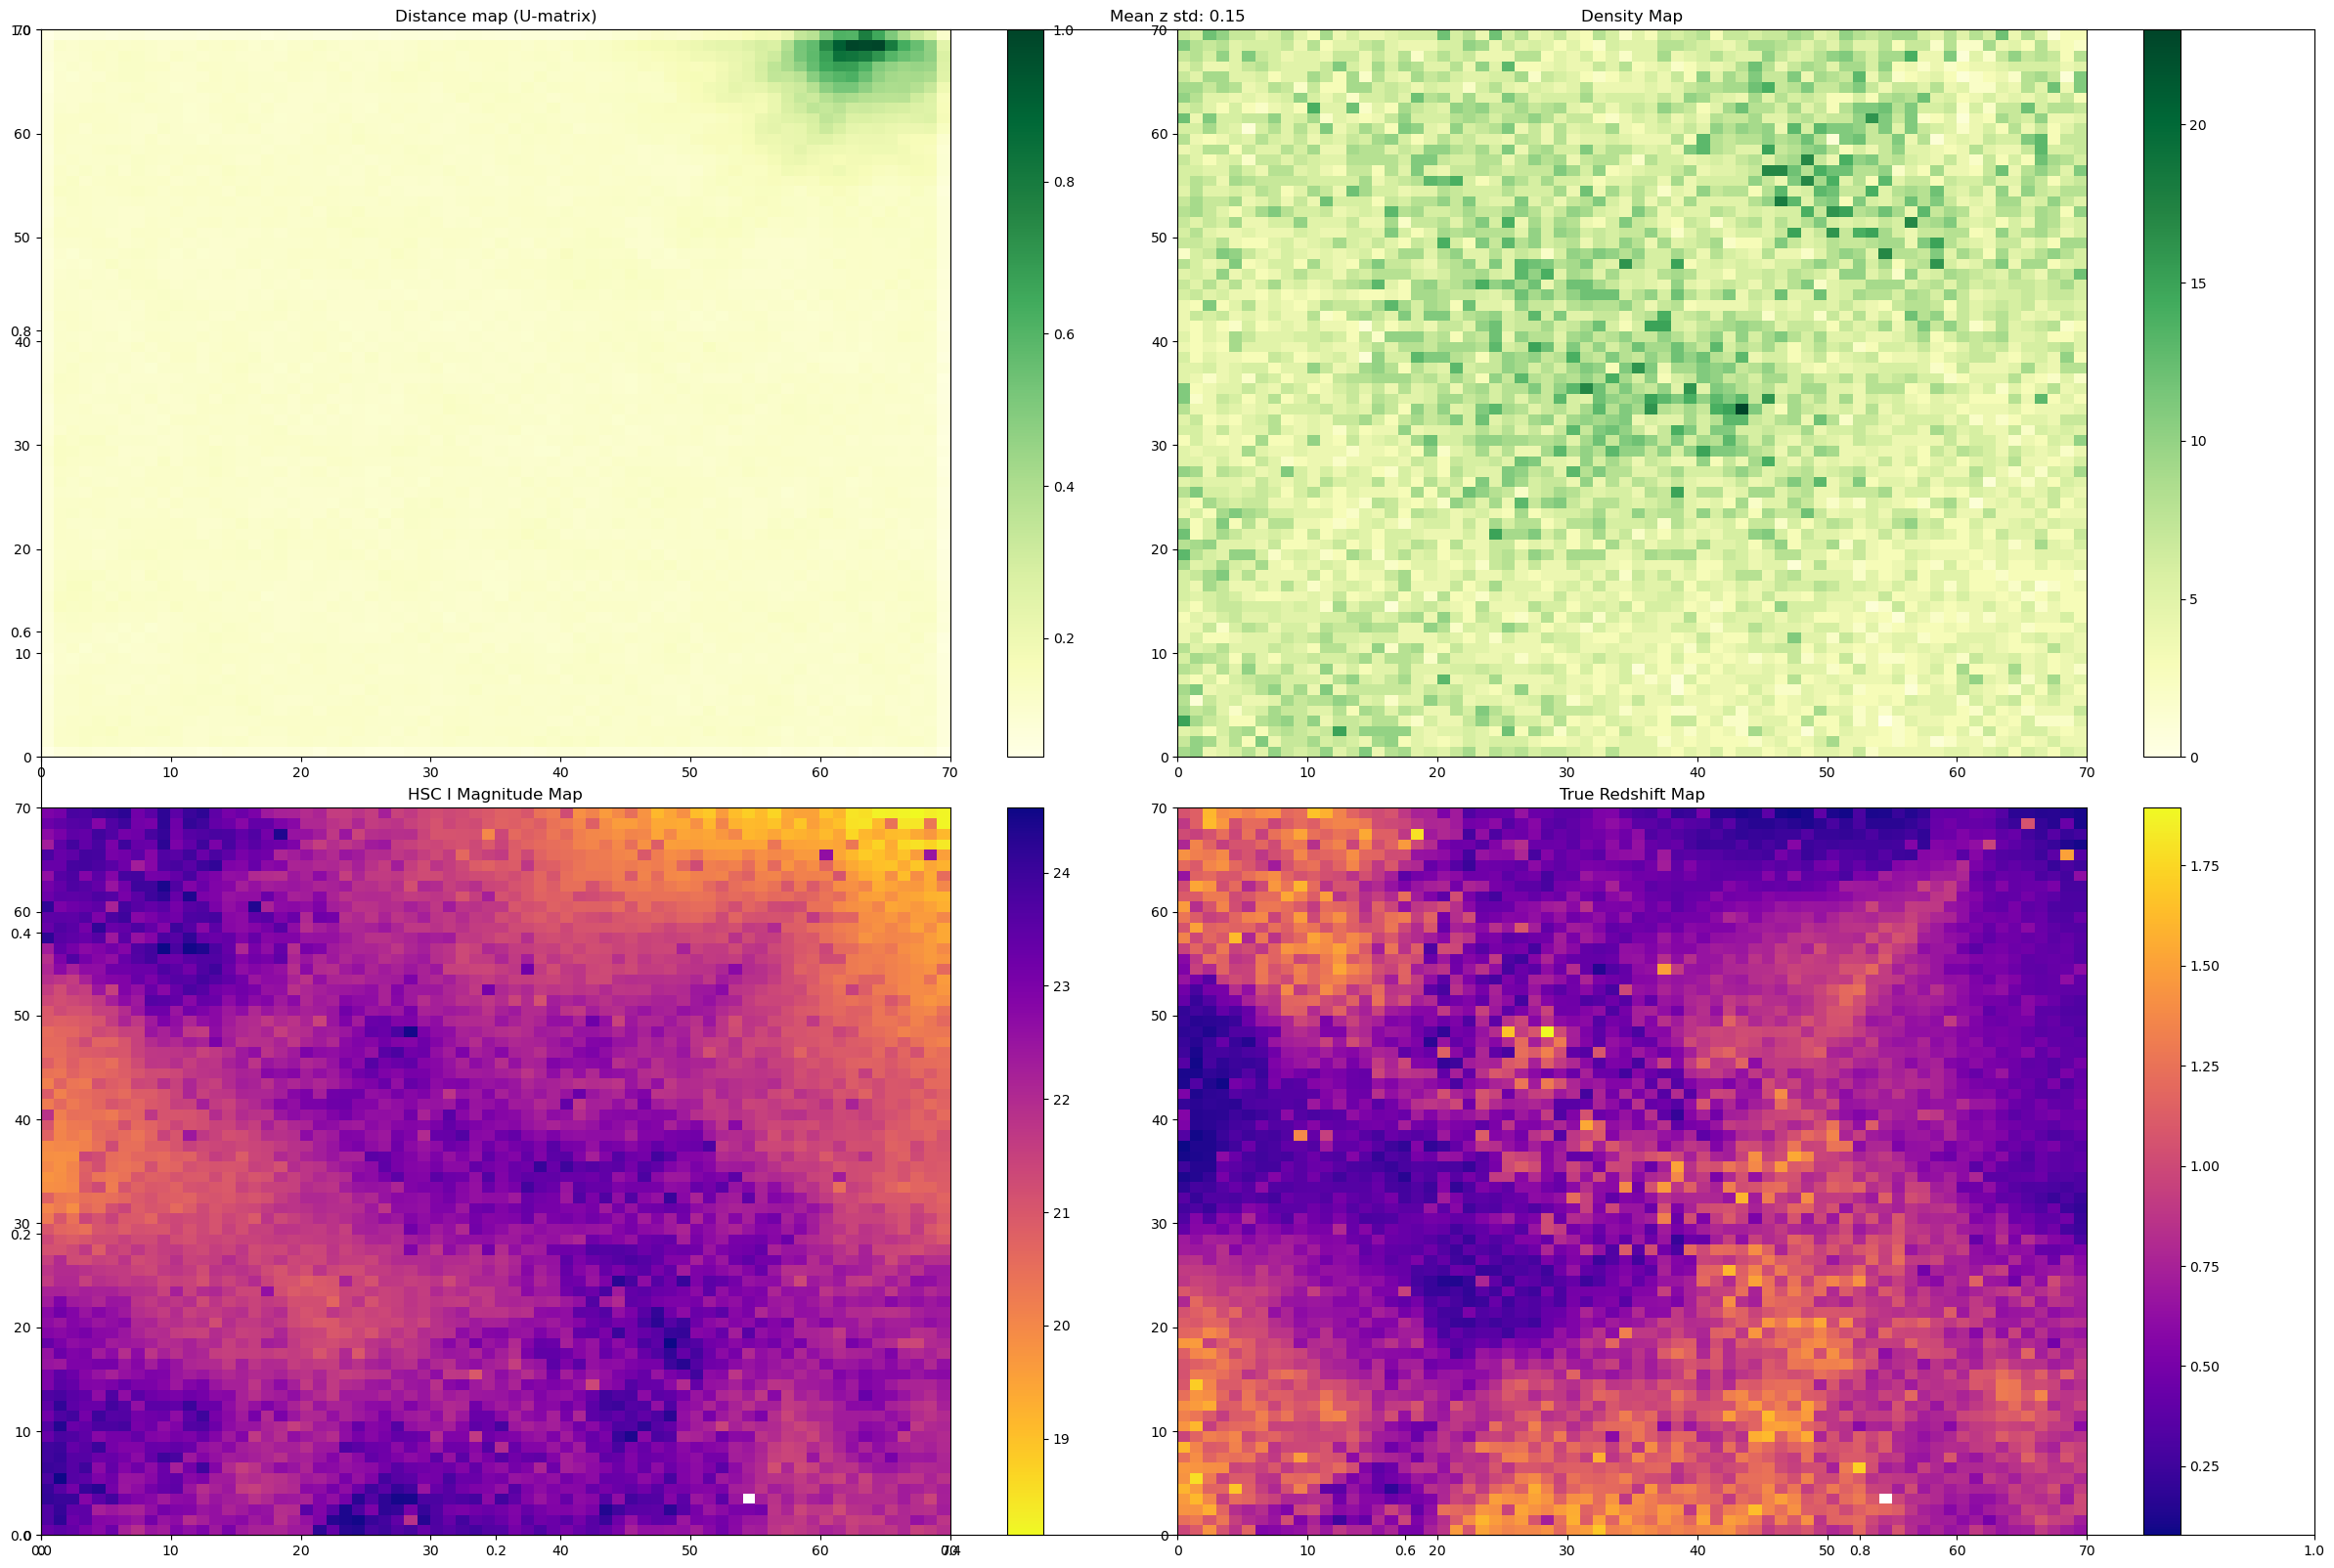

[70, 1.8, 0.5]
Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


29683.0
Topological error: 0.44749519927231074
Quantization error: 4.6719874650884705
Average redshift std: 0.15063545396084246


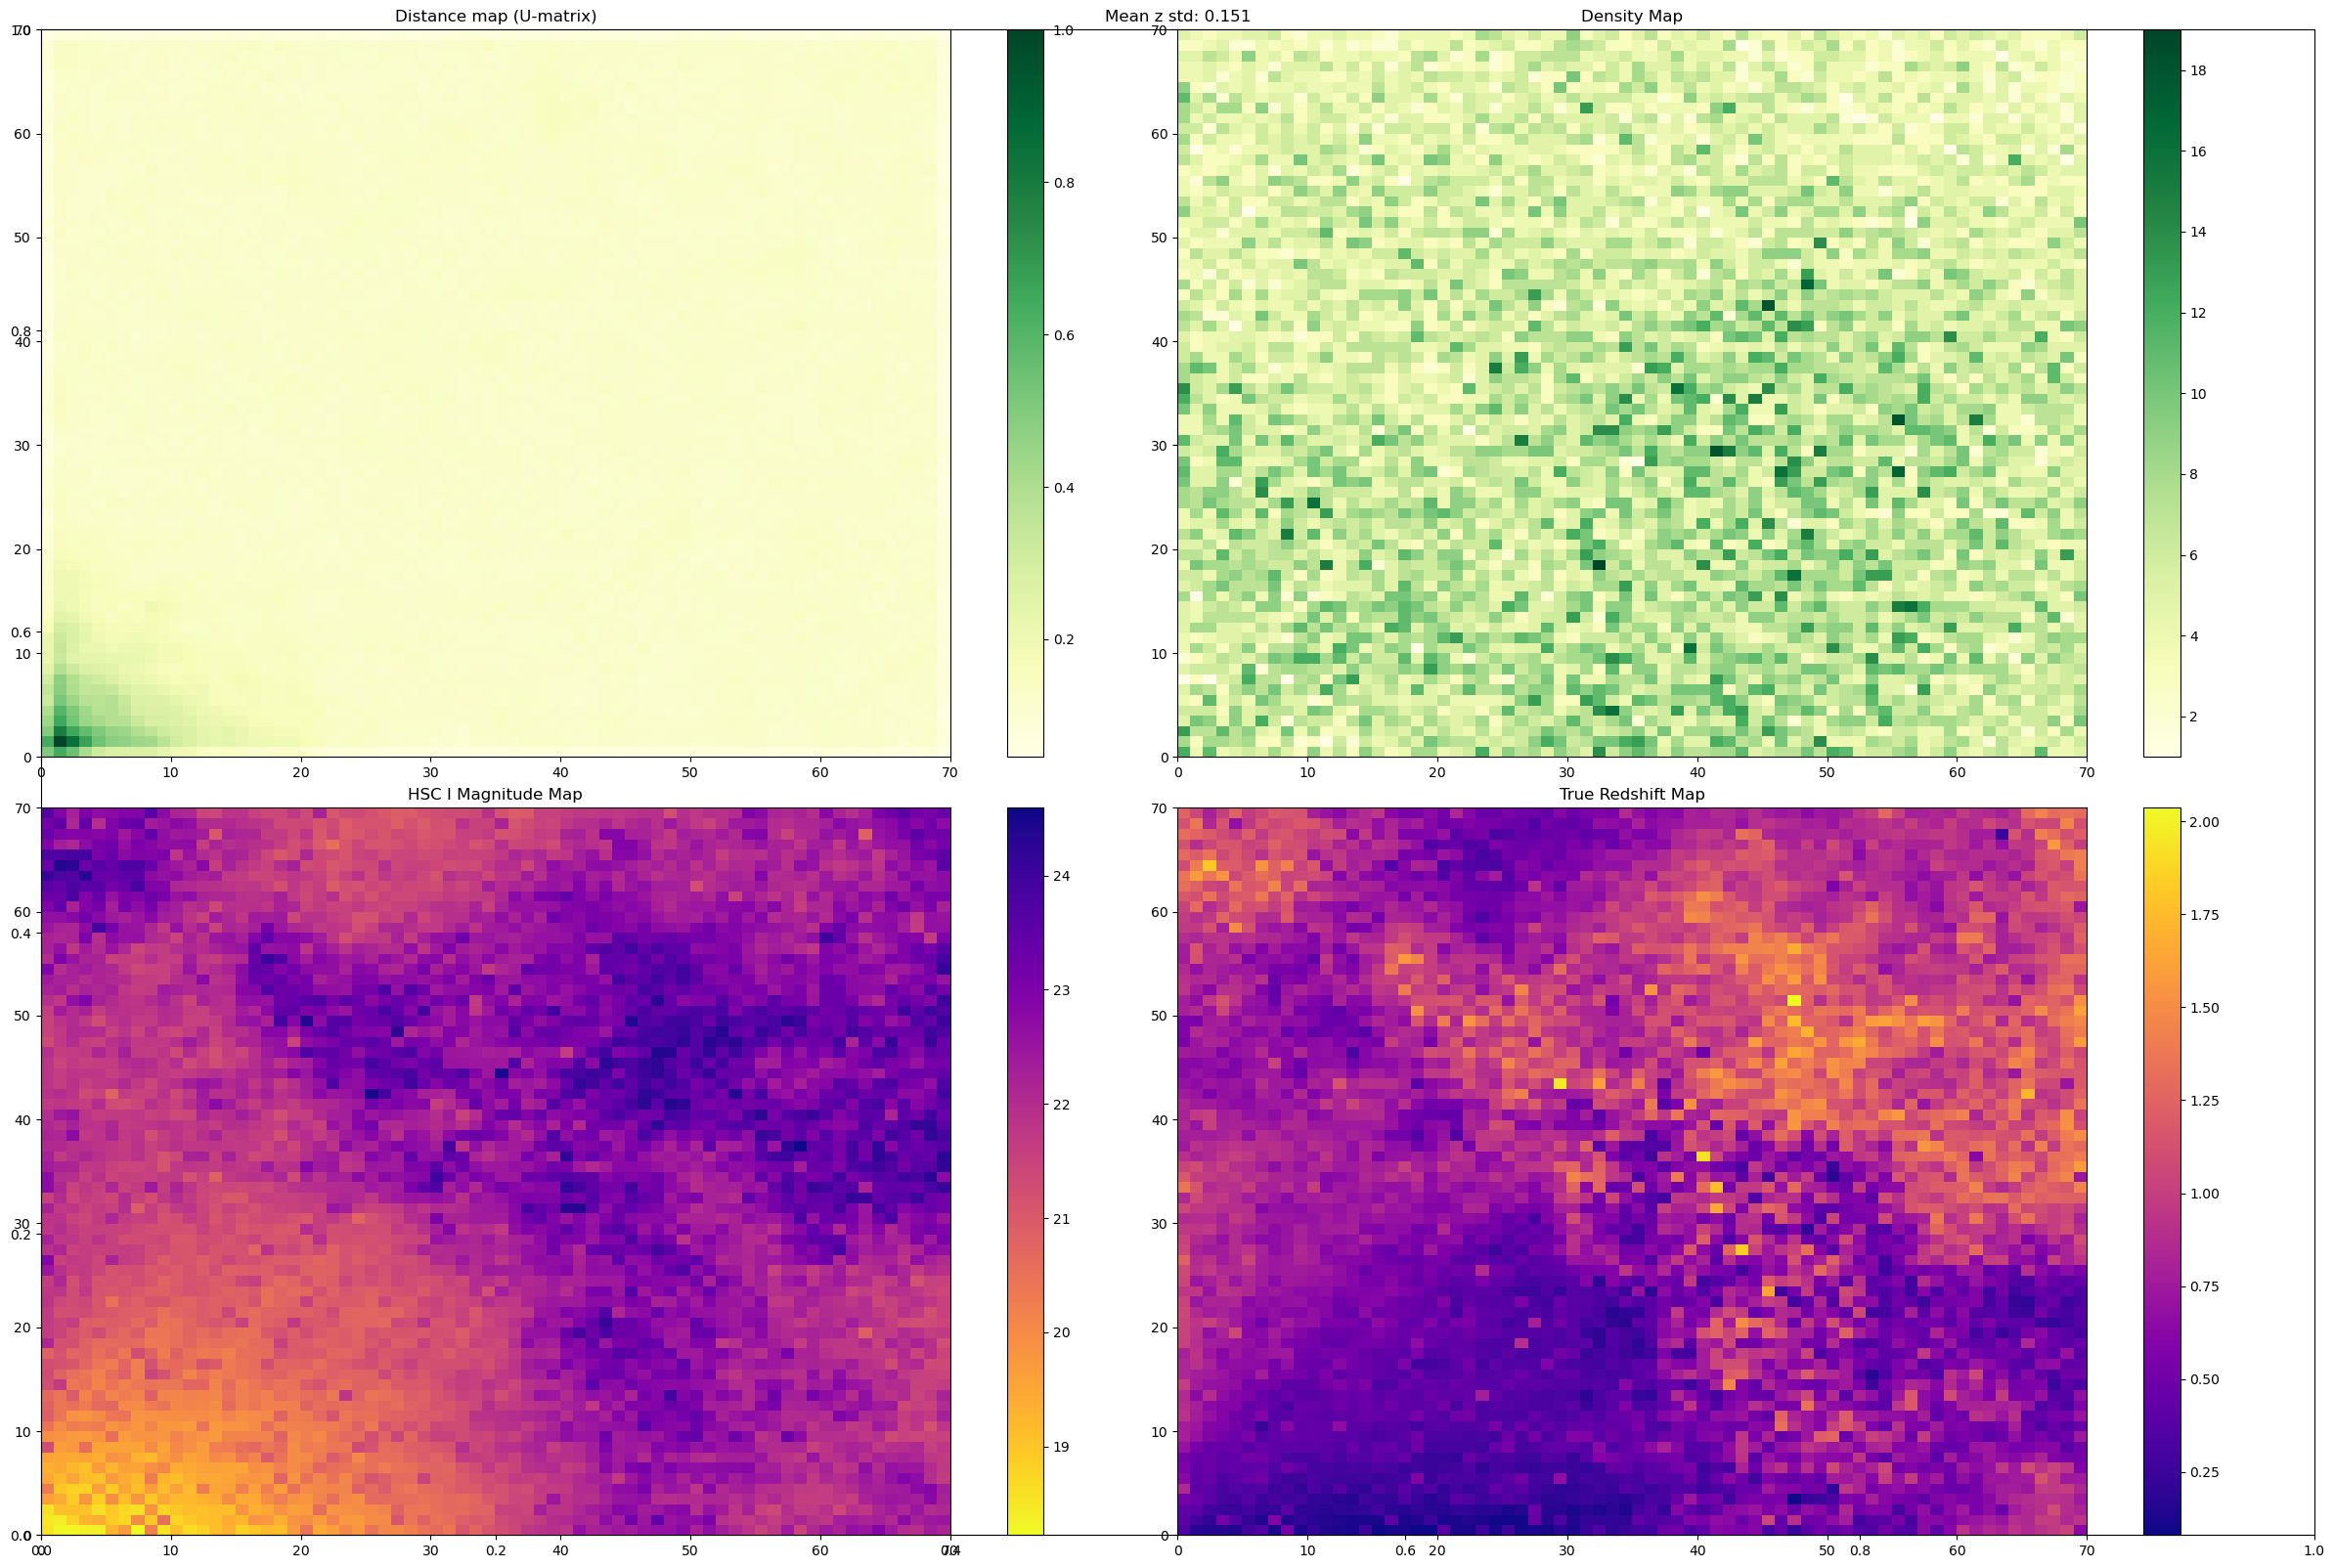

[70, 1.8, 0.55]
Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


29683.0
Topological error: 0.47643432267627933
Quantization error: 4.659962370113666
Average redshift std: 0.15090093102262447


C:\Users\ASUS\AppData\Local\Temp\ipykernel_34700\1734733816.py:59: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_34700\1734733816.py:64: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


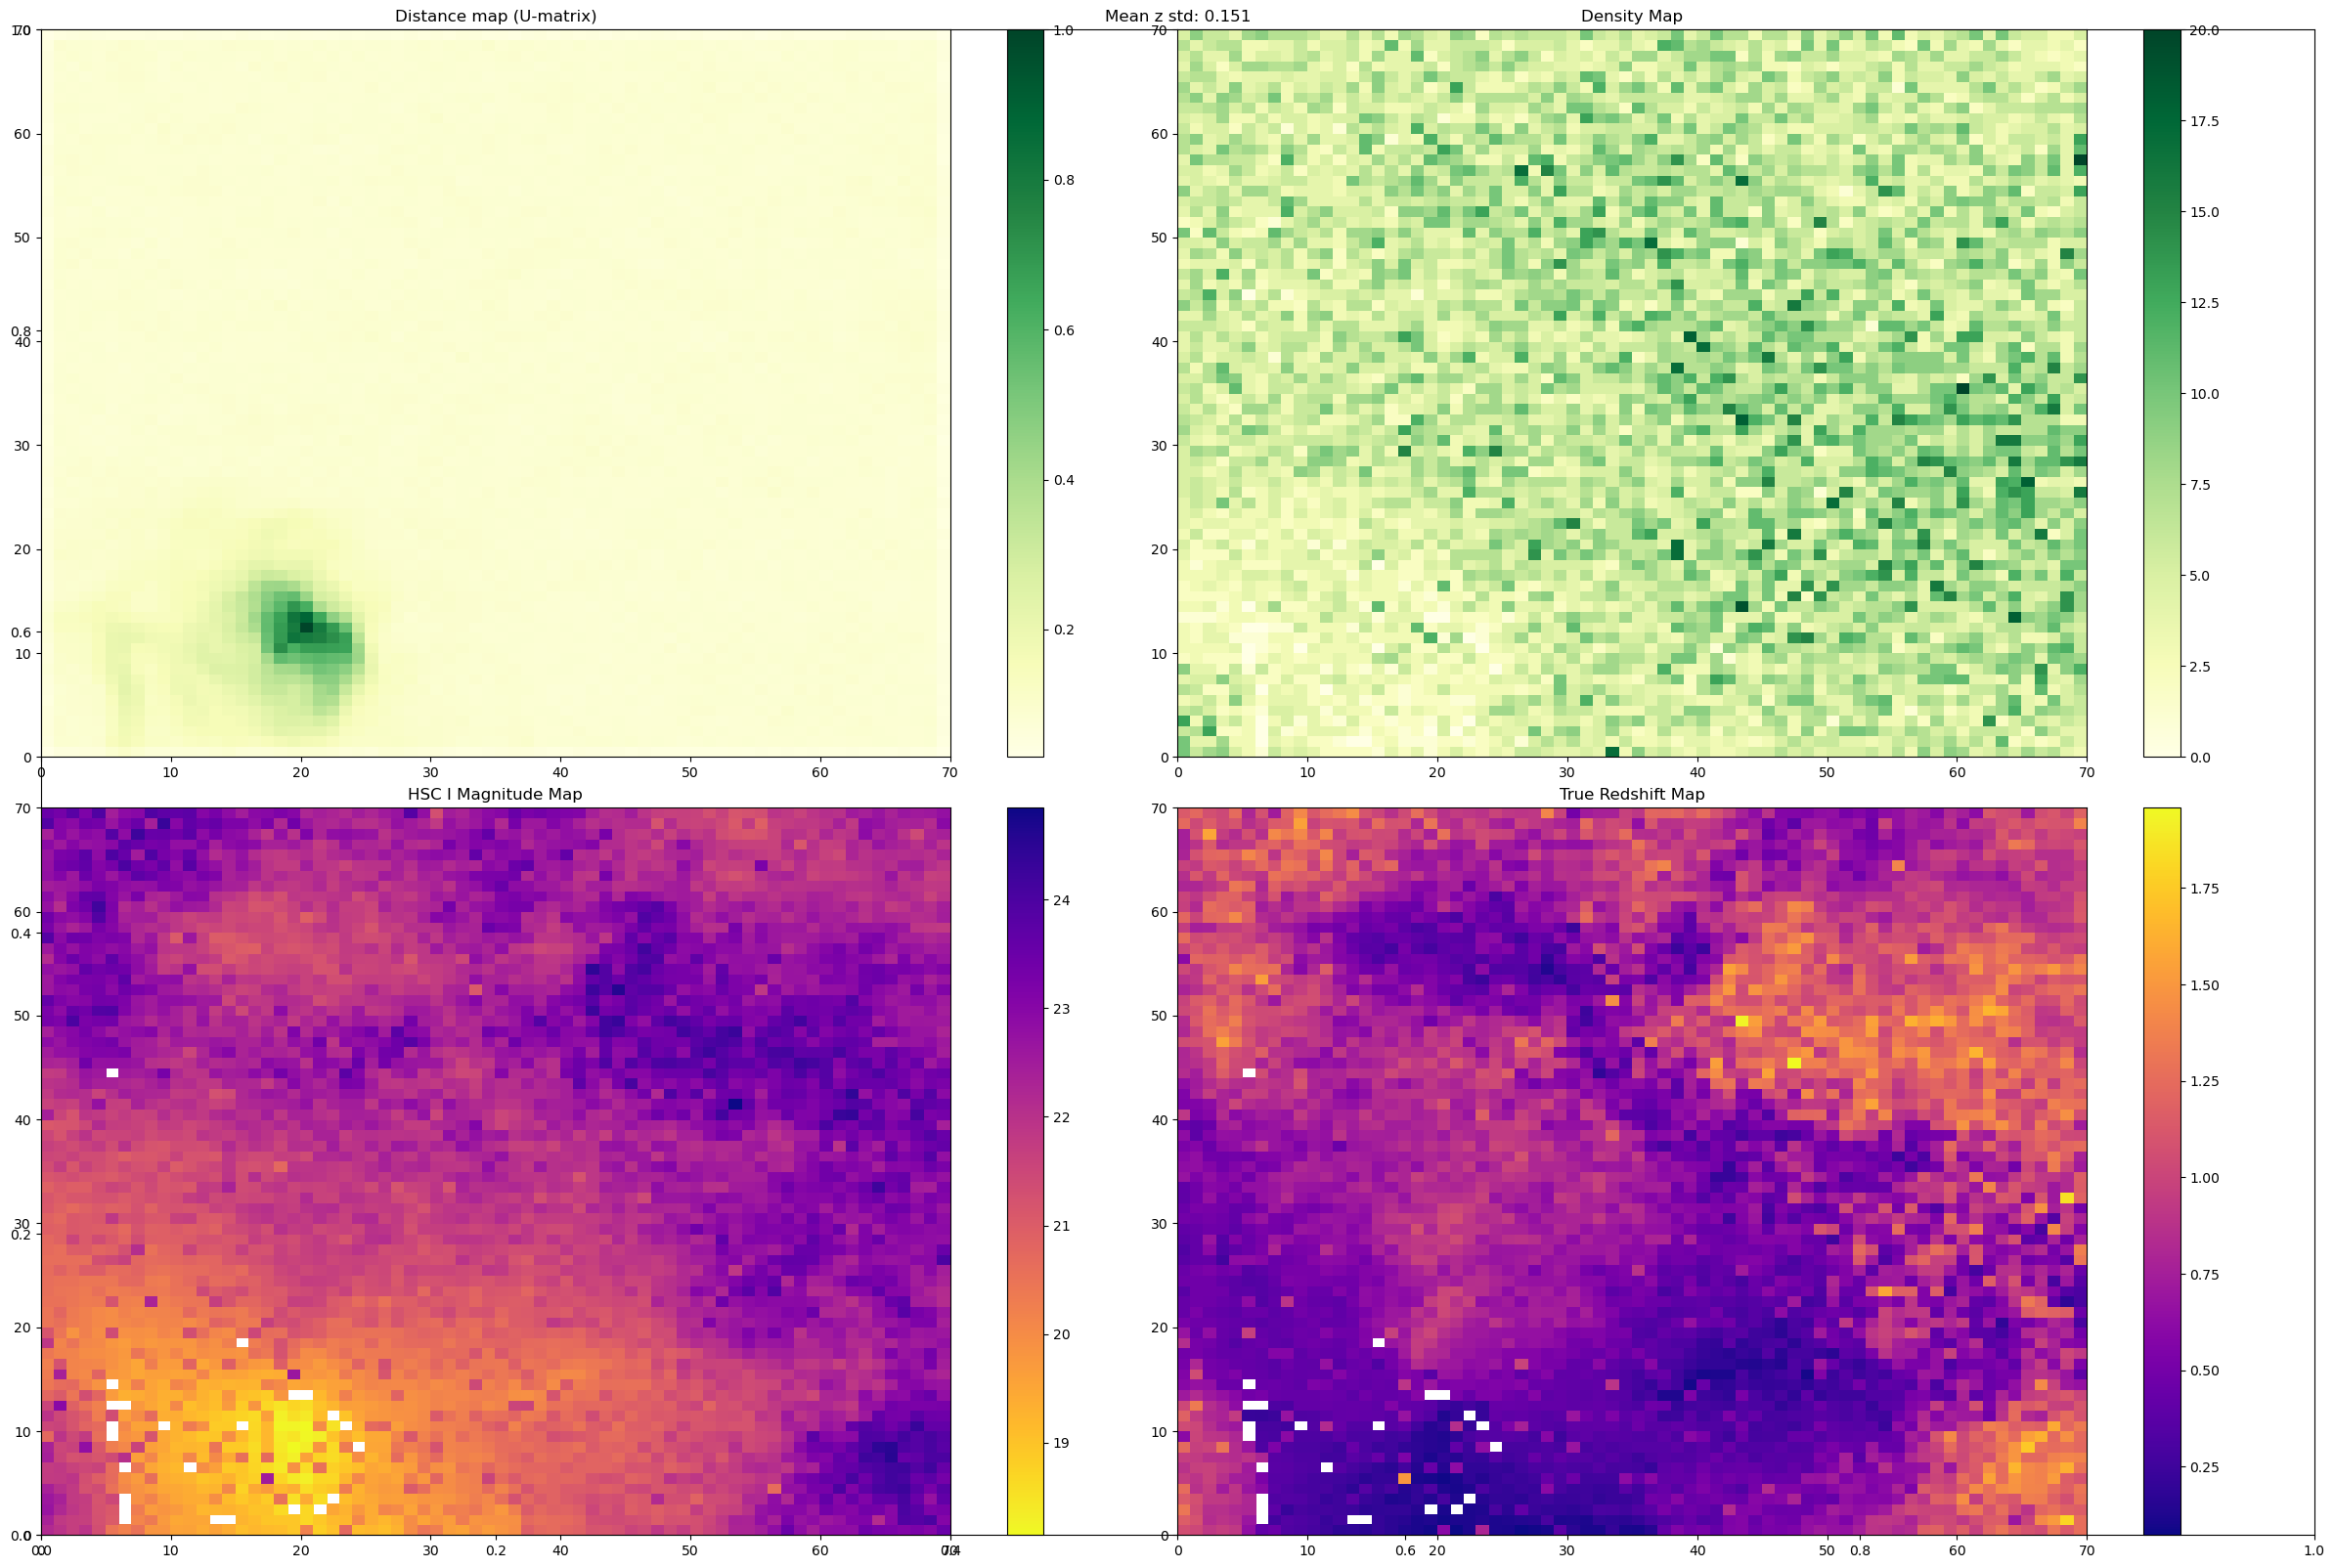

[70, 1.8, 0.6]
Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


29683.0
Topological error: 0.47562577906545833
Quantization error: 4.654713829000532
Average redshift std: 0.1510206041678117


C:\Users\ASUS\AppData\Local\Temp\ipykernel_34700\1734733816.py:59: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_34700\1734733816.py:64: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


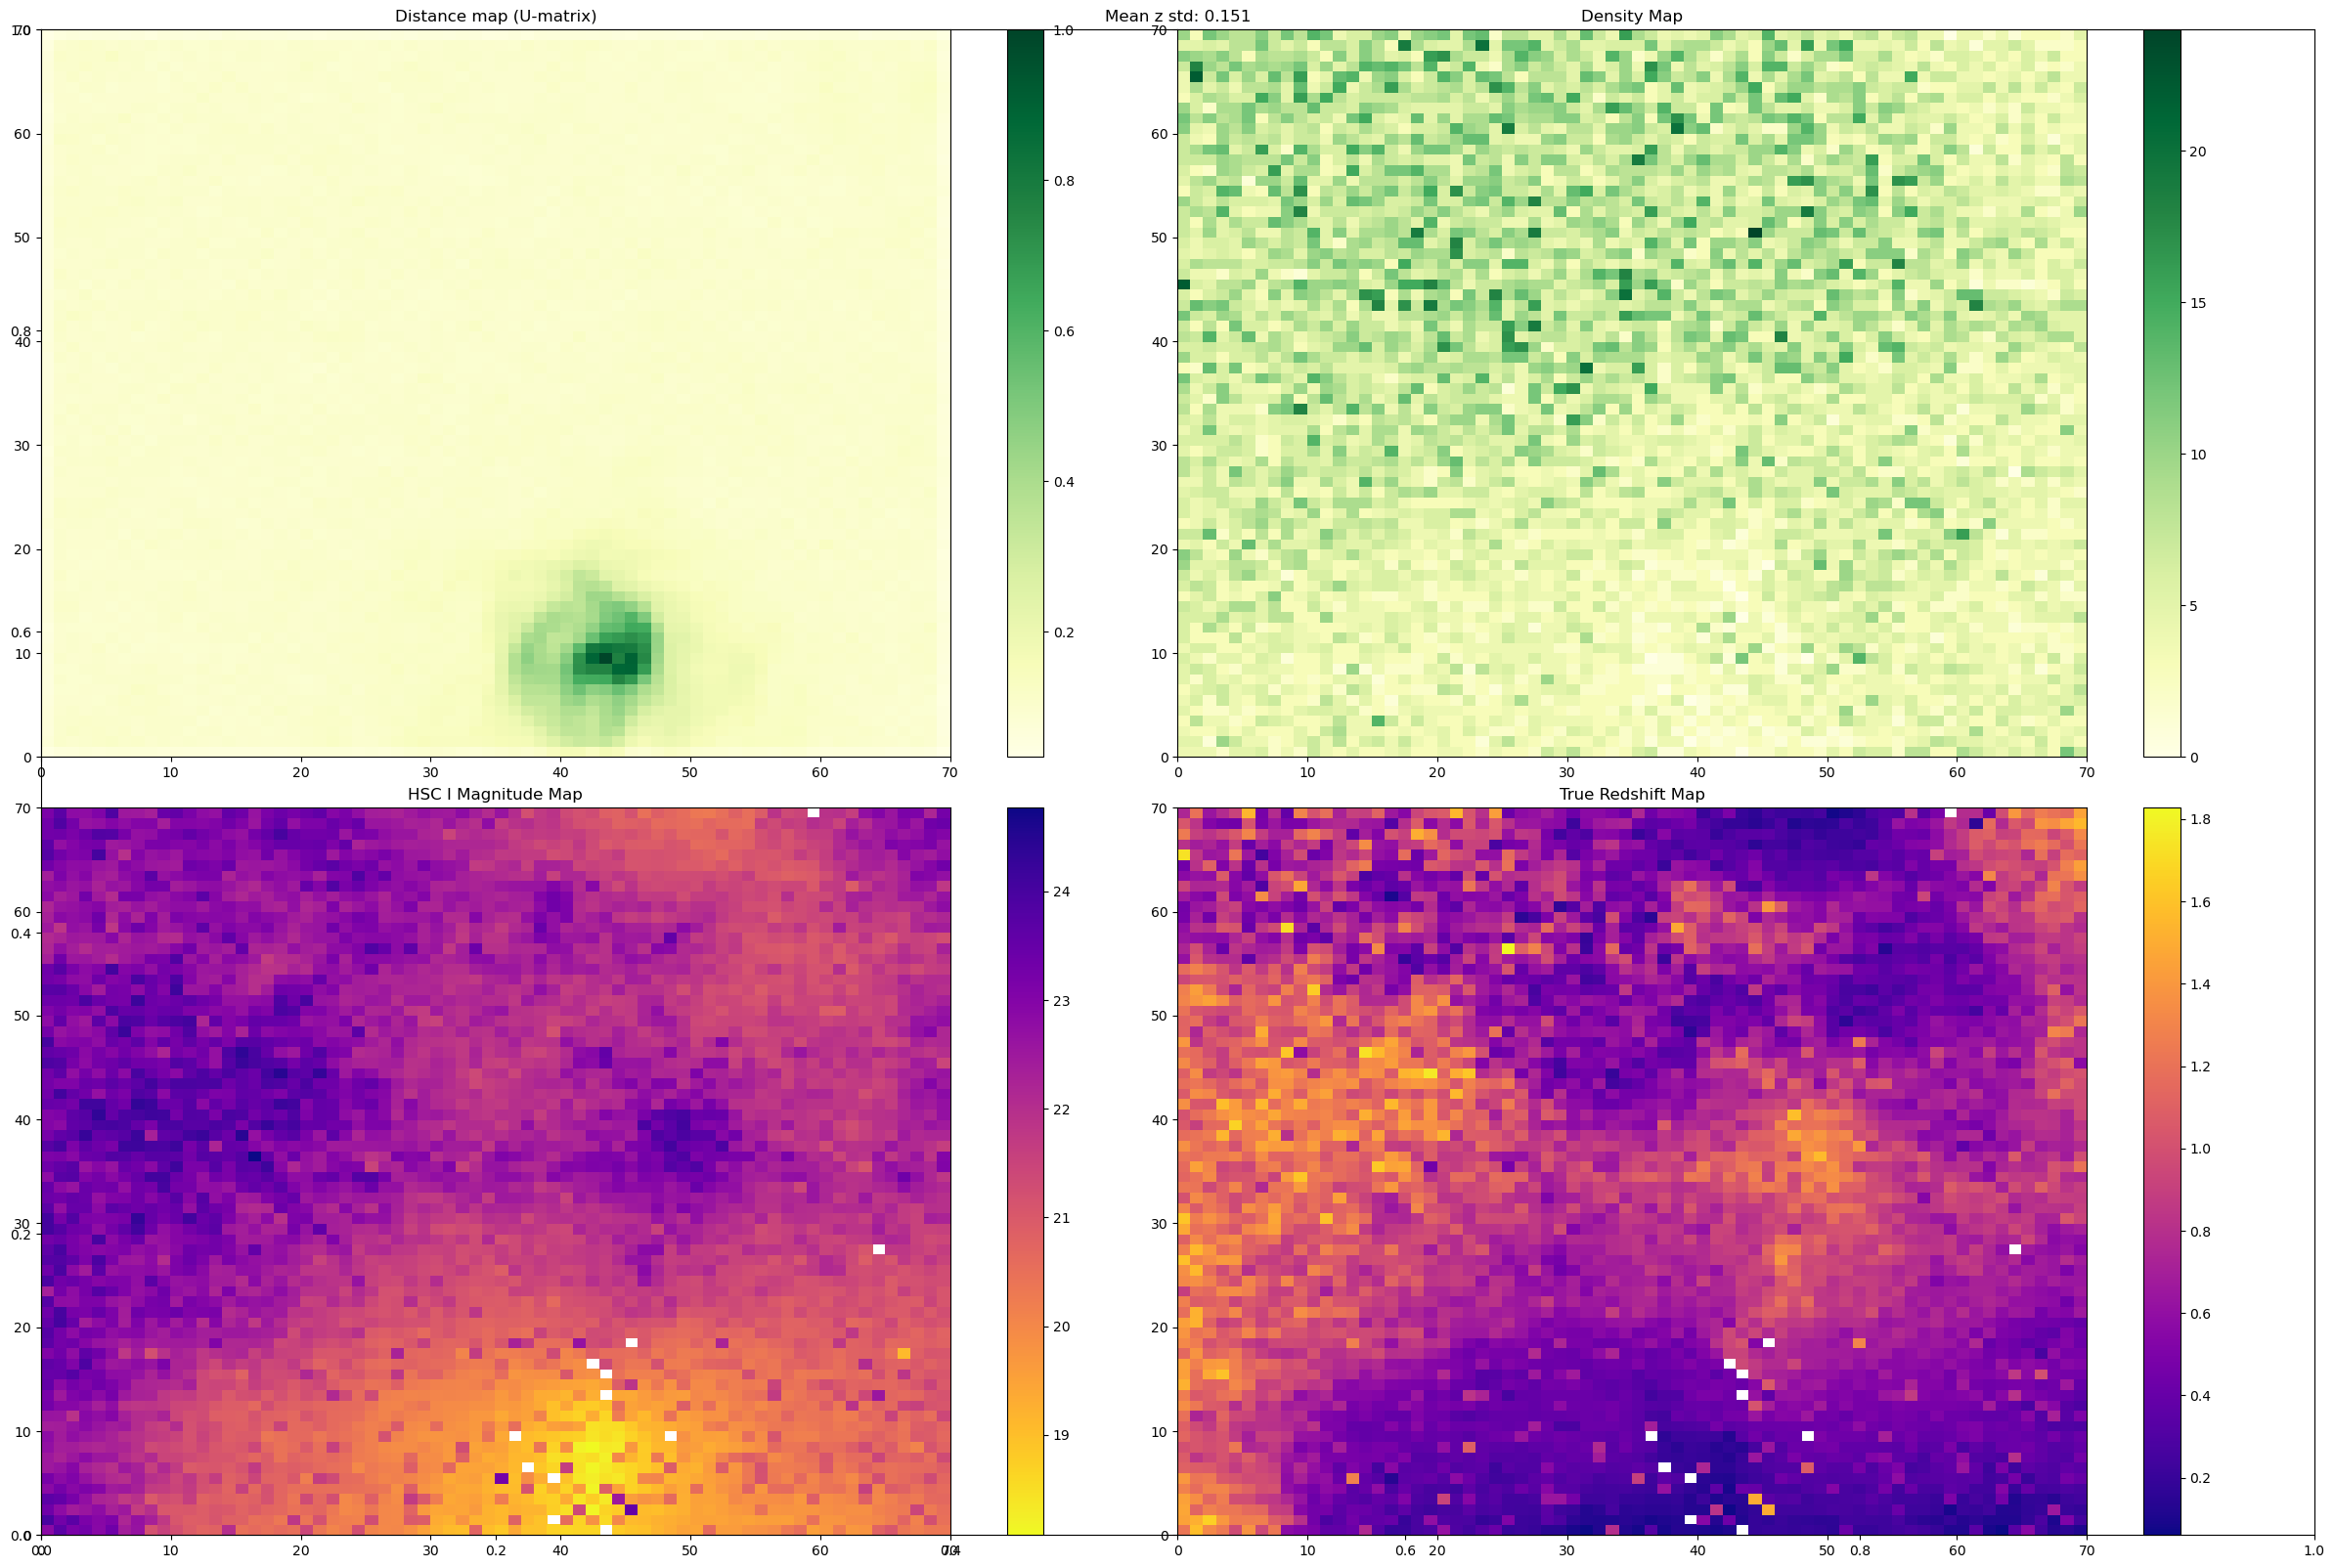

[70, 1.8, 0.65]
Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


29683.0
Topological error: 0.4795337398510932
Quantization error: 4.654729582797037
Average redshift std: 0.15195457597313977


C:\Users\ASUS\AppData\Local\Temp\ipykernel_34700\1734733816.py:59: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_34700\1734733816.py:64: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


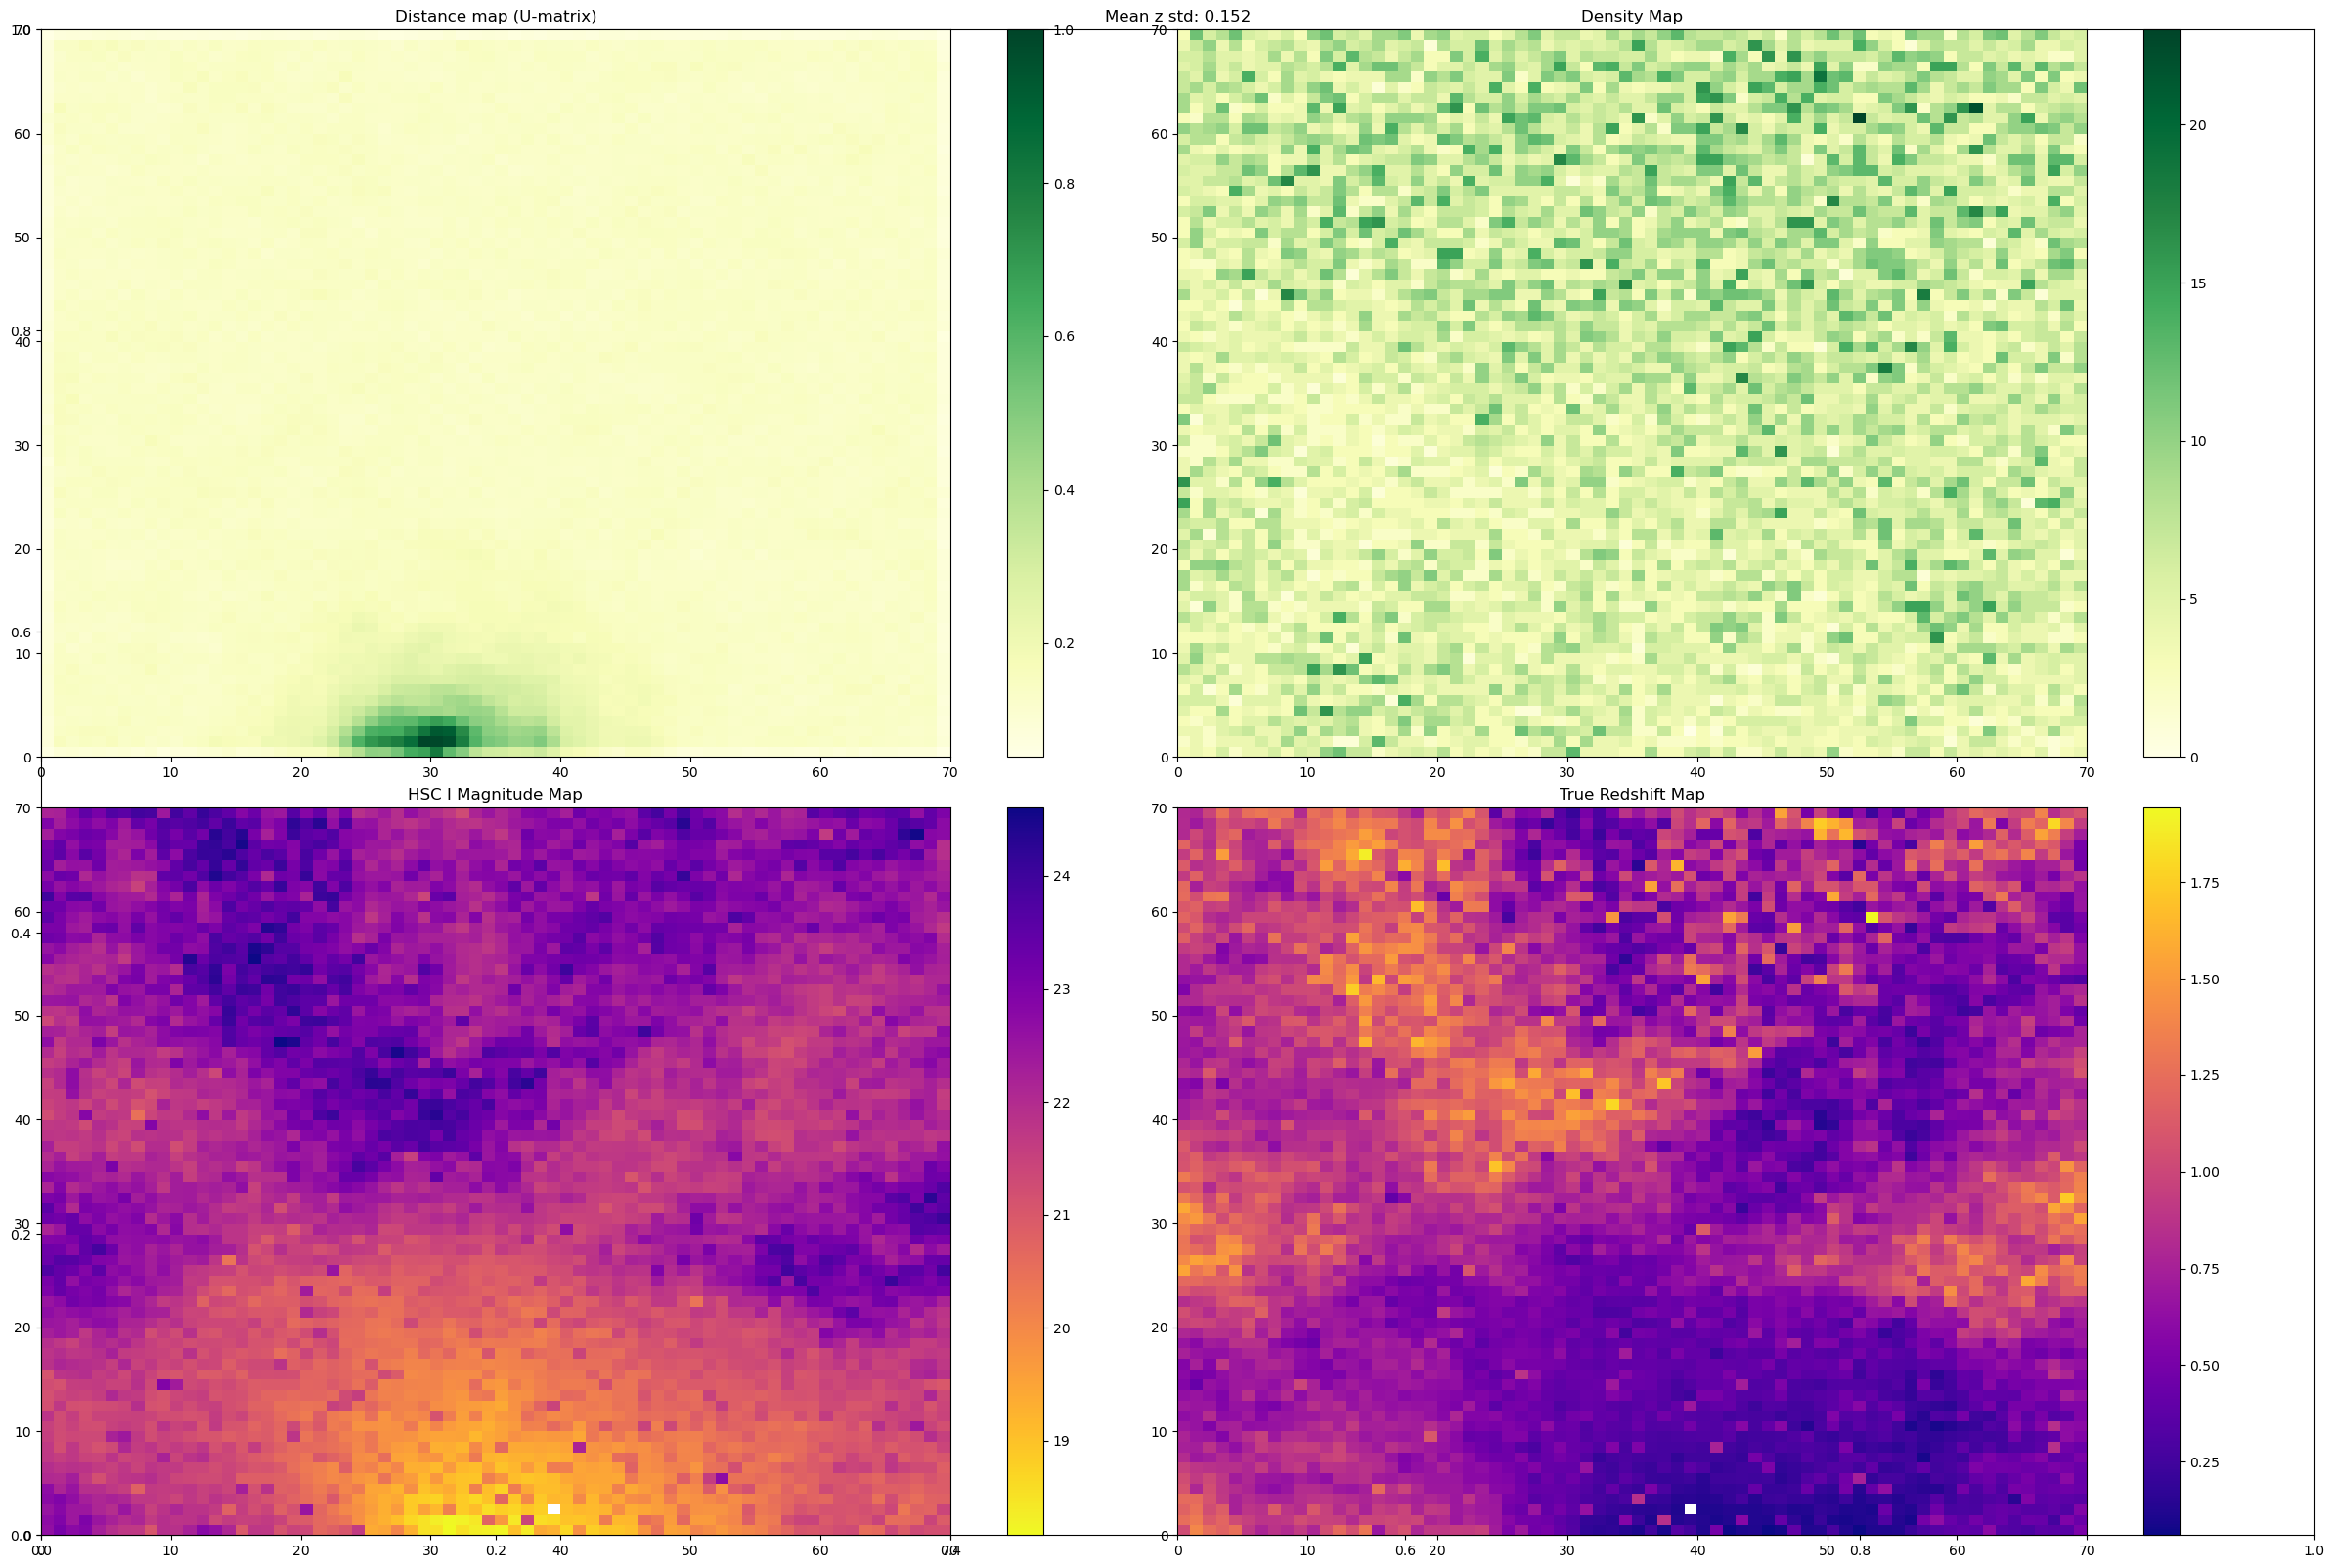

[70, 1.8, 0.7]
Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


29683.0
Topological error: 0.48404810834484385
Quantization error: 4.652465860458514
Average redshift std: 0.15220853510585014


C:\Users\ASUS\AppData\Local\Temp\ipykernel_34700\1734733816.py:59: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_34700\1734733816.py:64: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


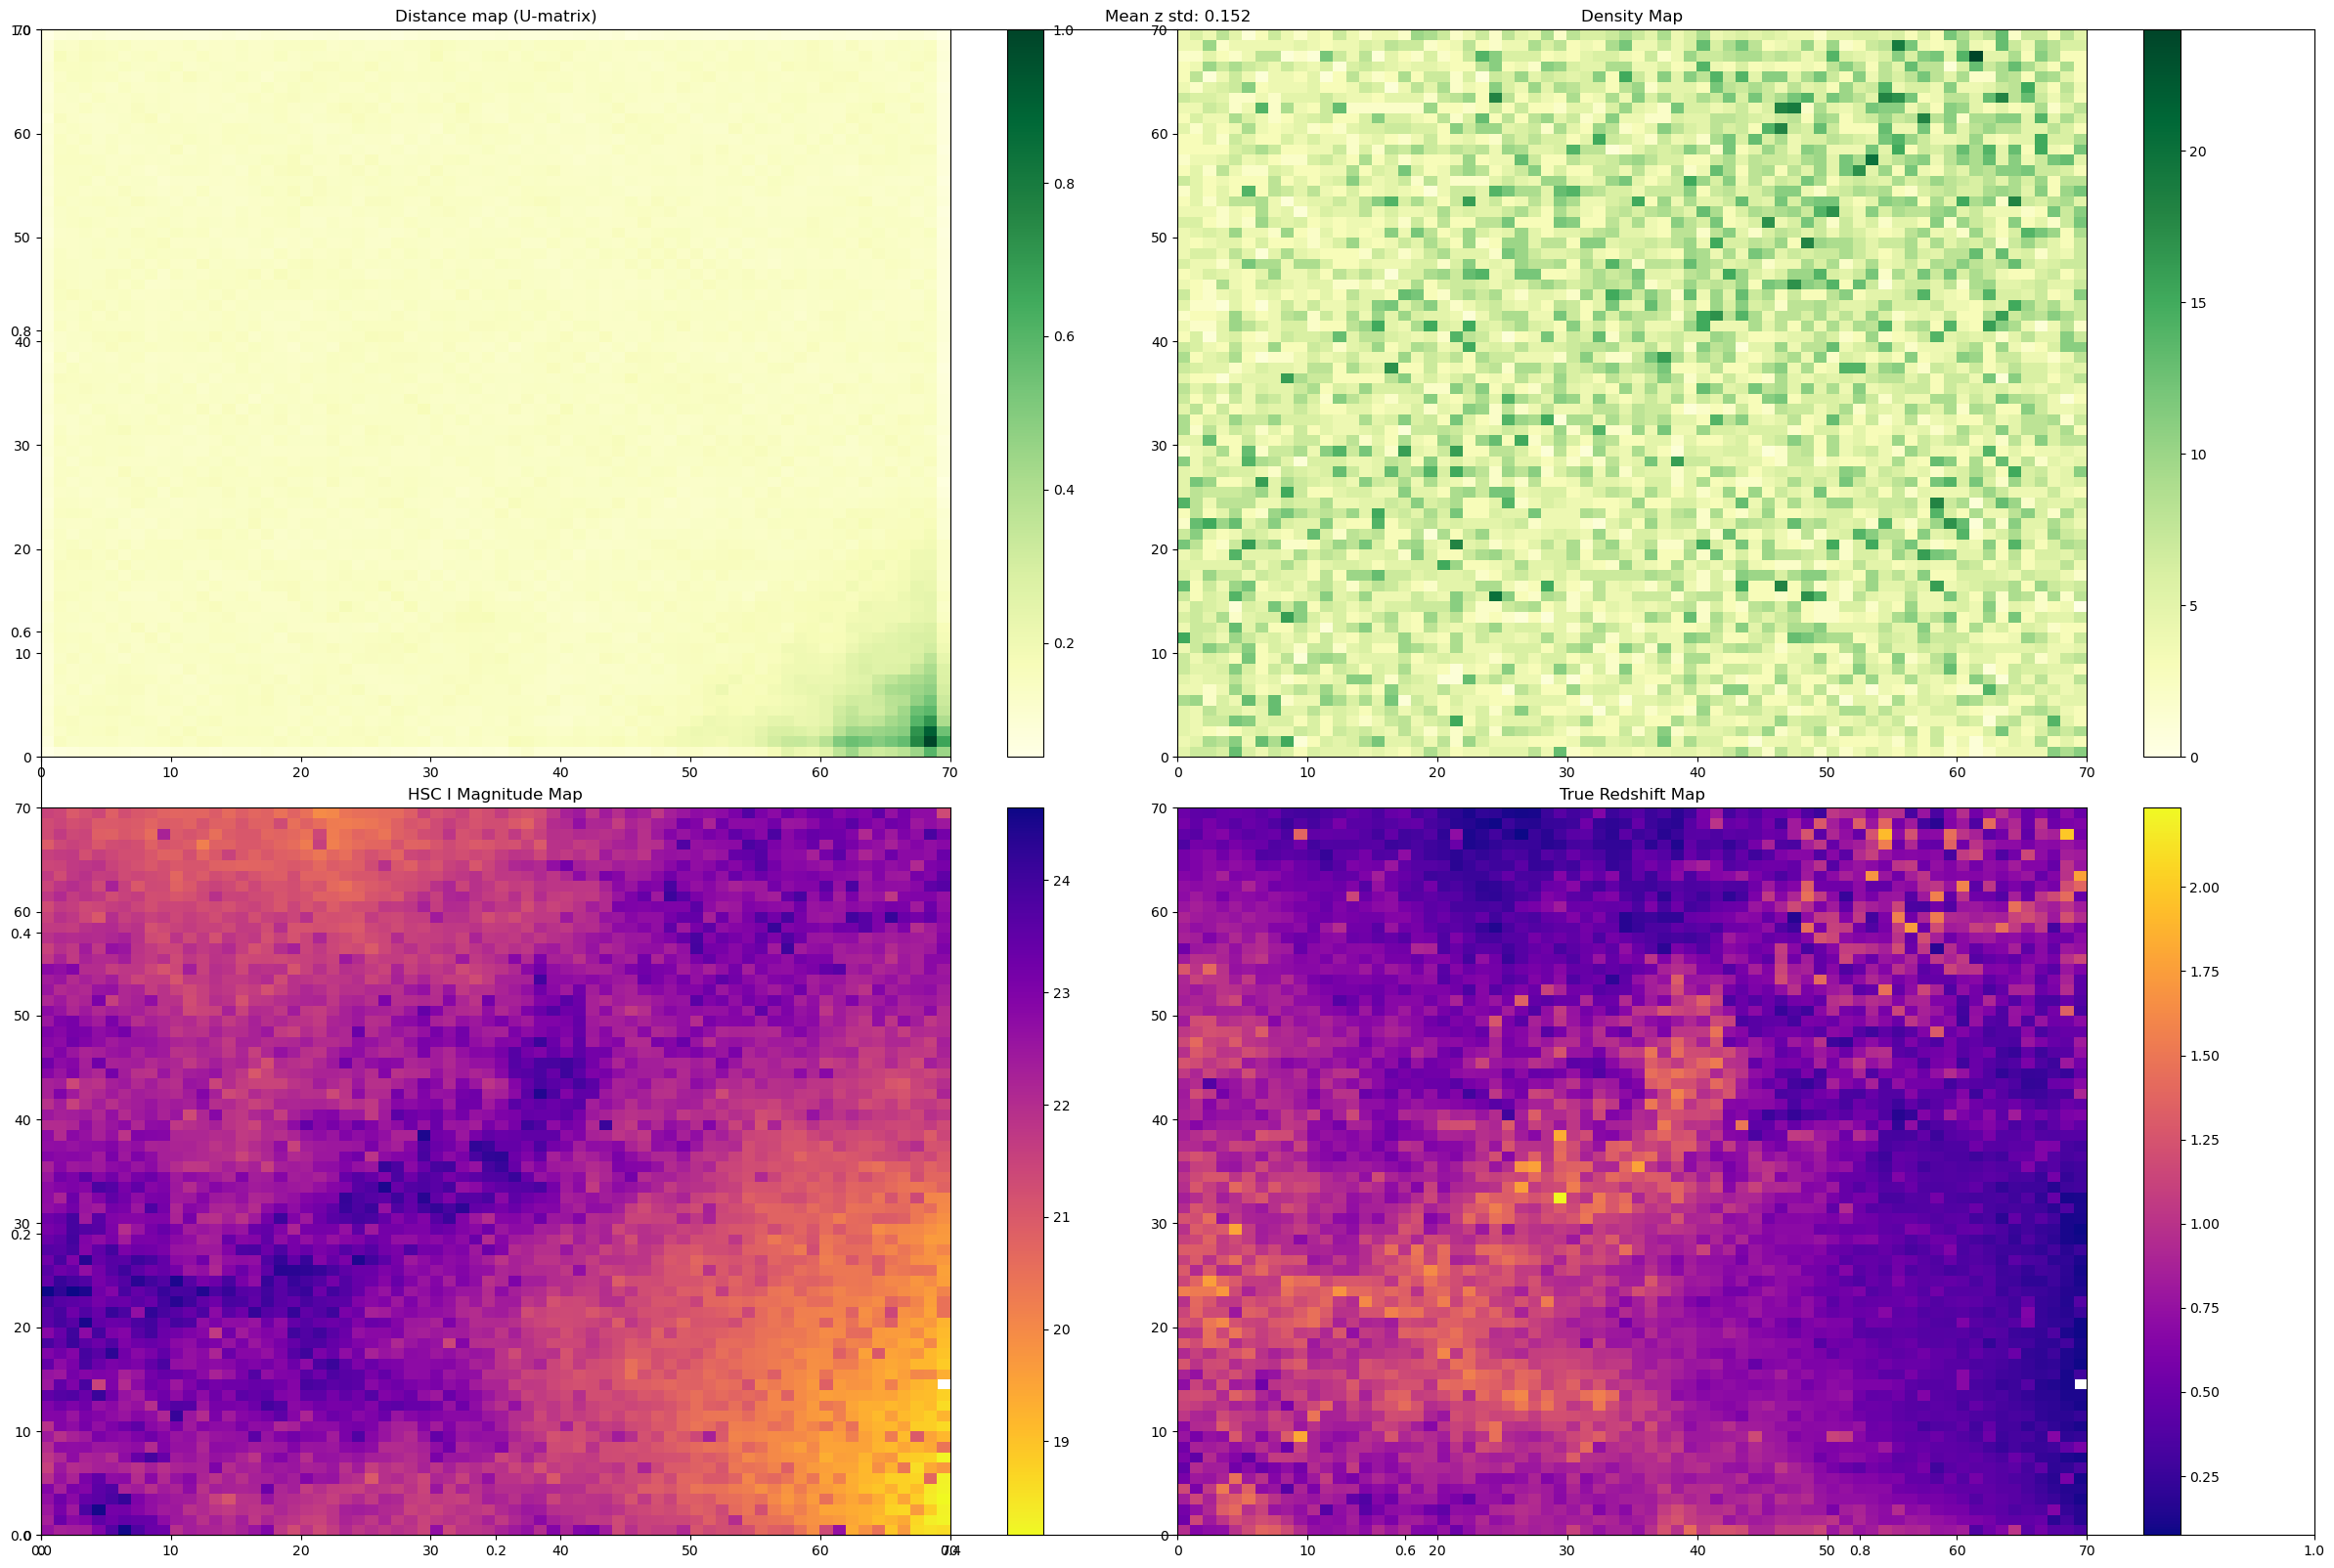

[70, 1.8, 0.75]
Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


29683.0
Topological error: 0.48991004952329614
Quantization error: 4.651584959619811
Average redshift std: 0.15280434877068513


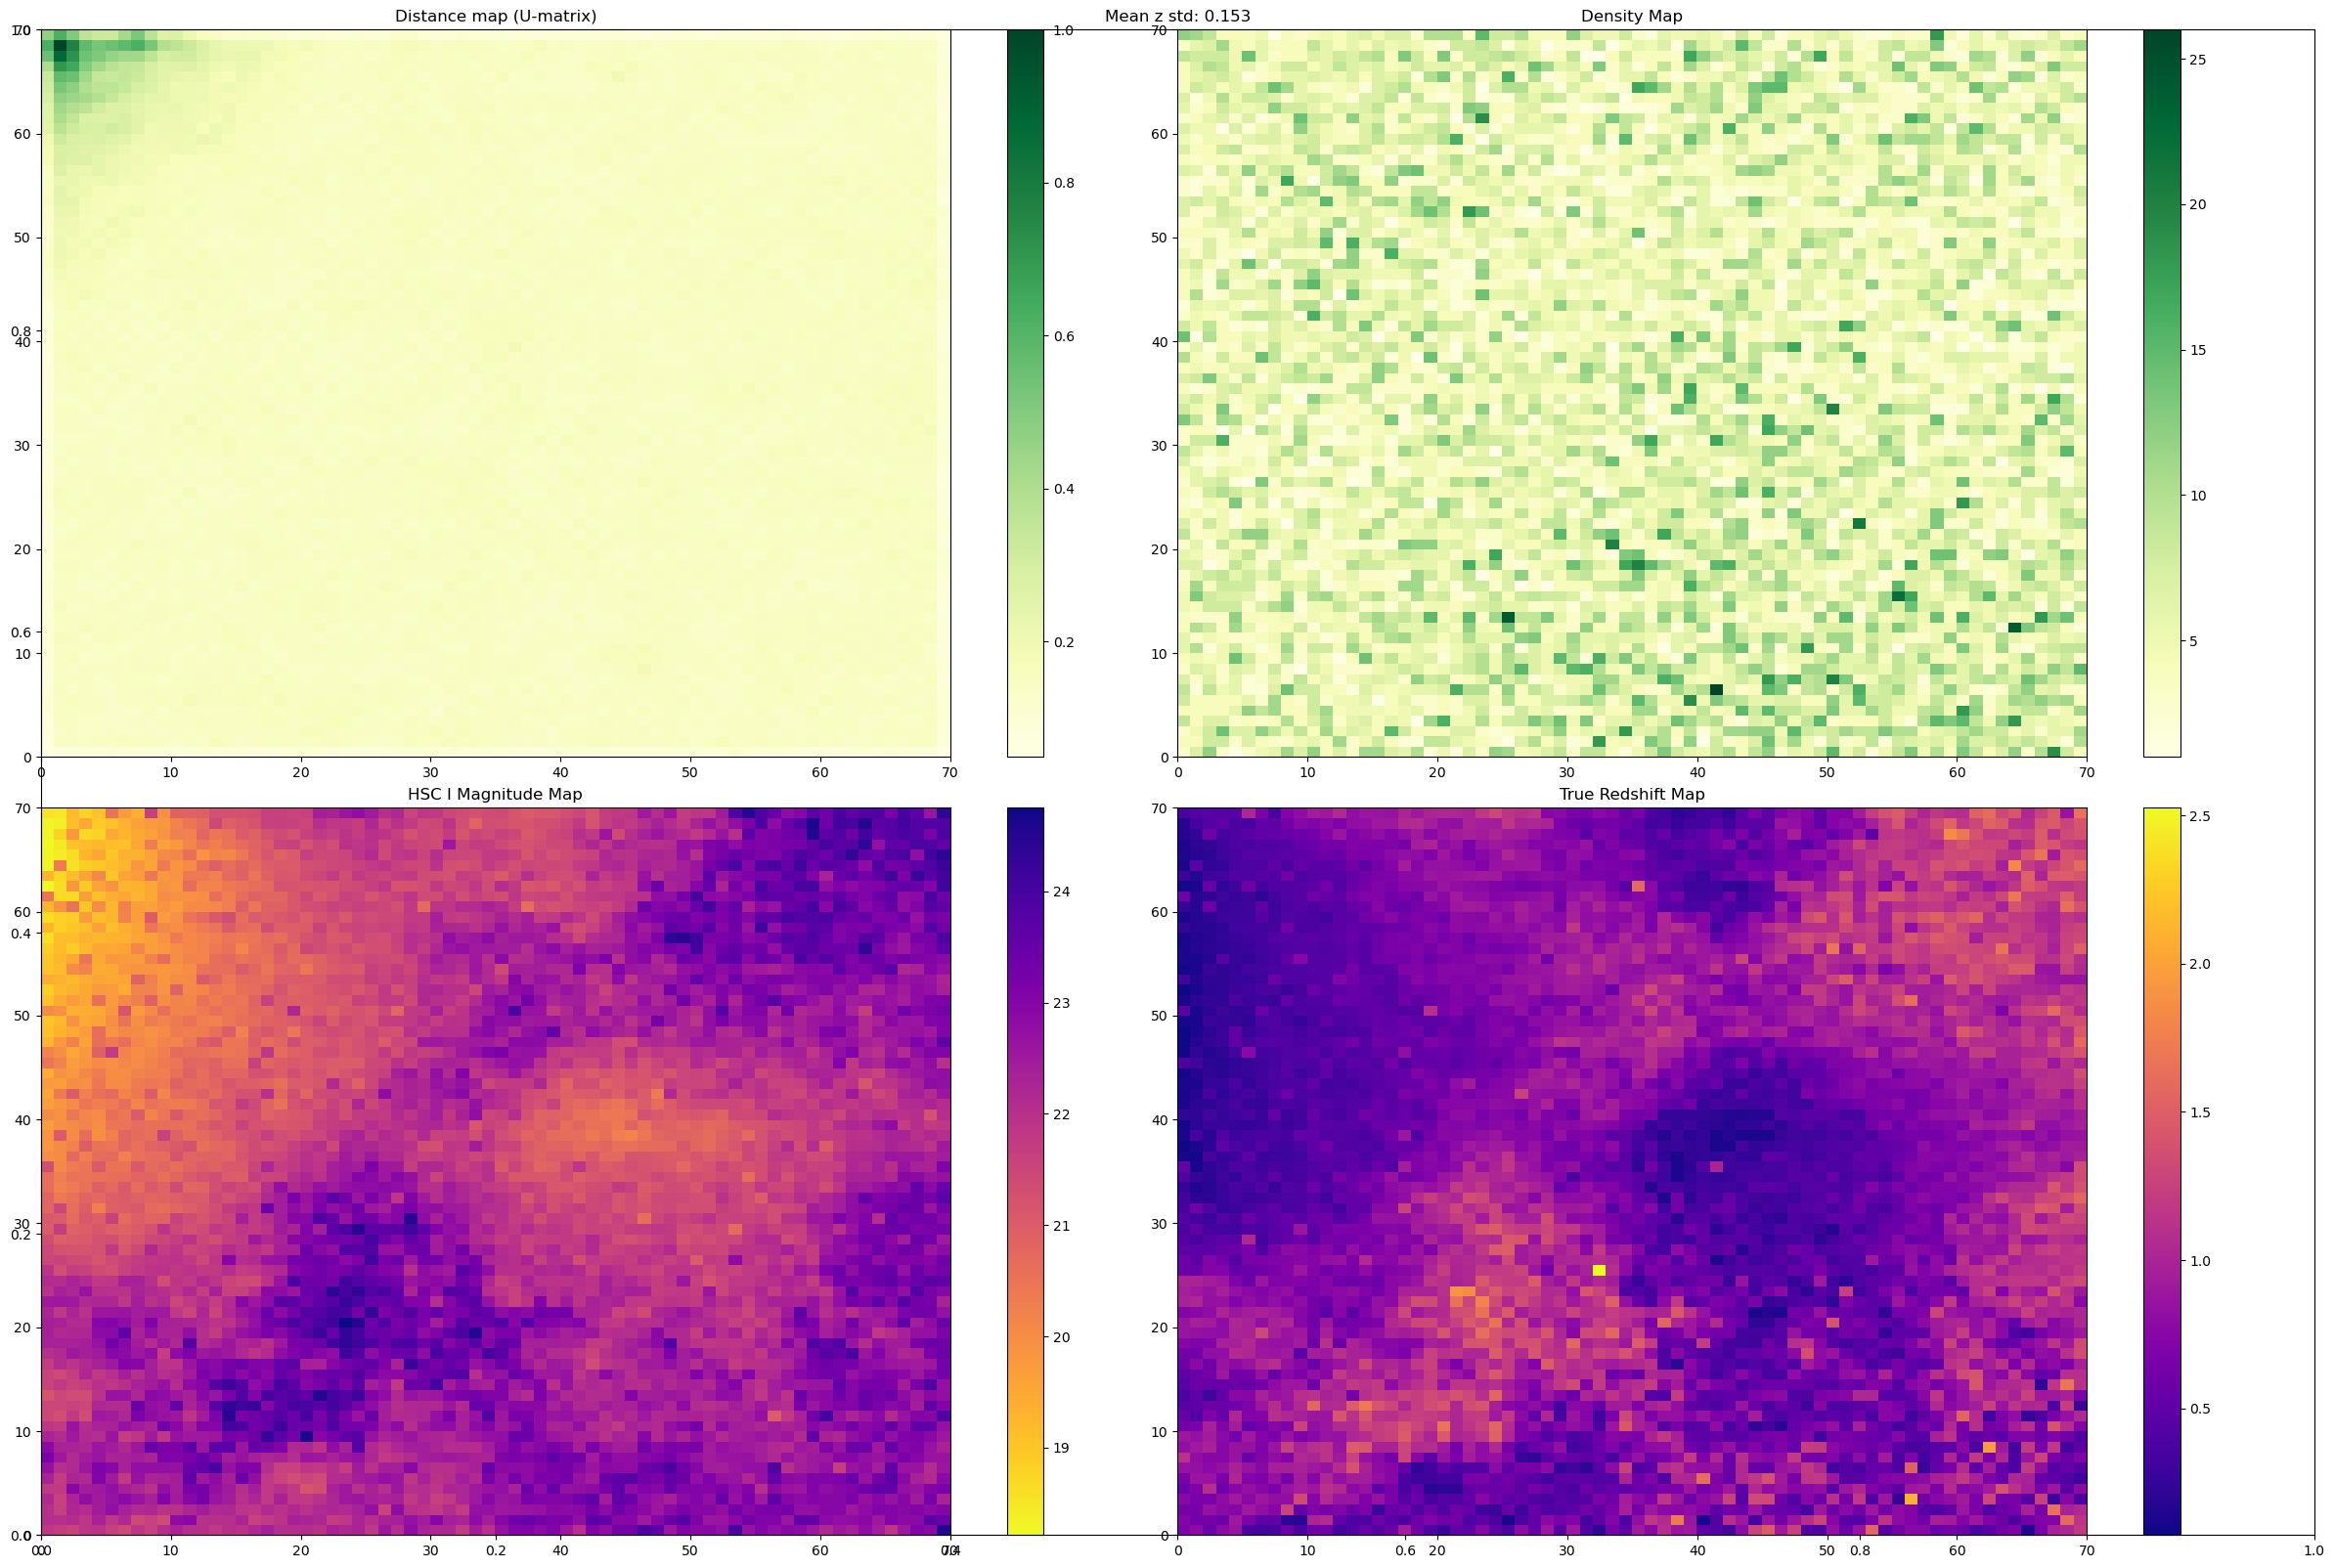

[70, 1.8, 0.8]
Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


29683.0
Topological error: 0.49708587406933263
Quantization error: 4.653326563291798
Average redshift std: 0.1528275094625665


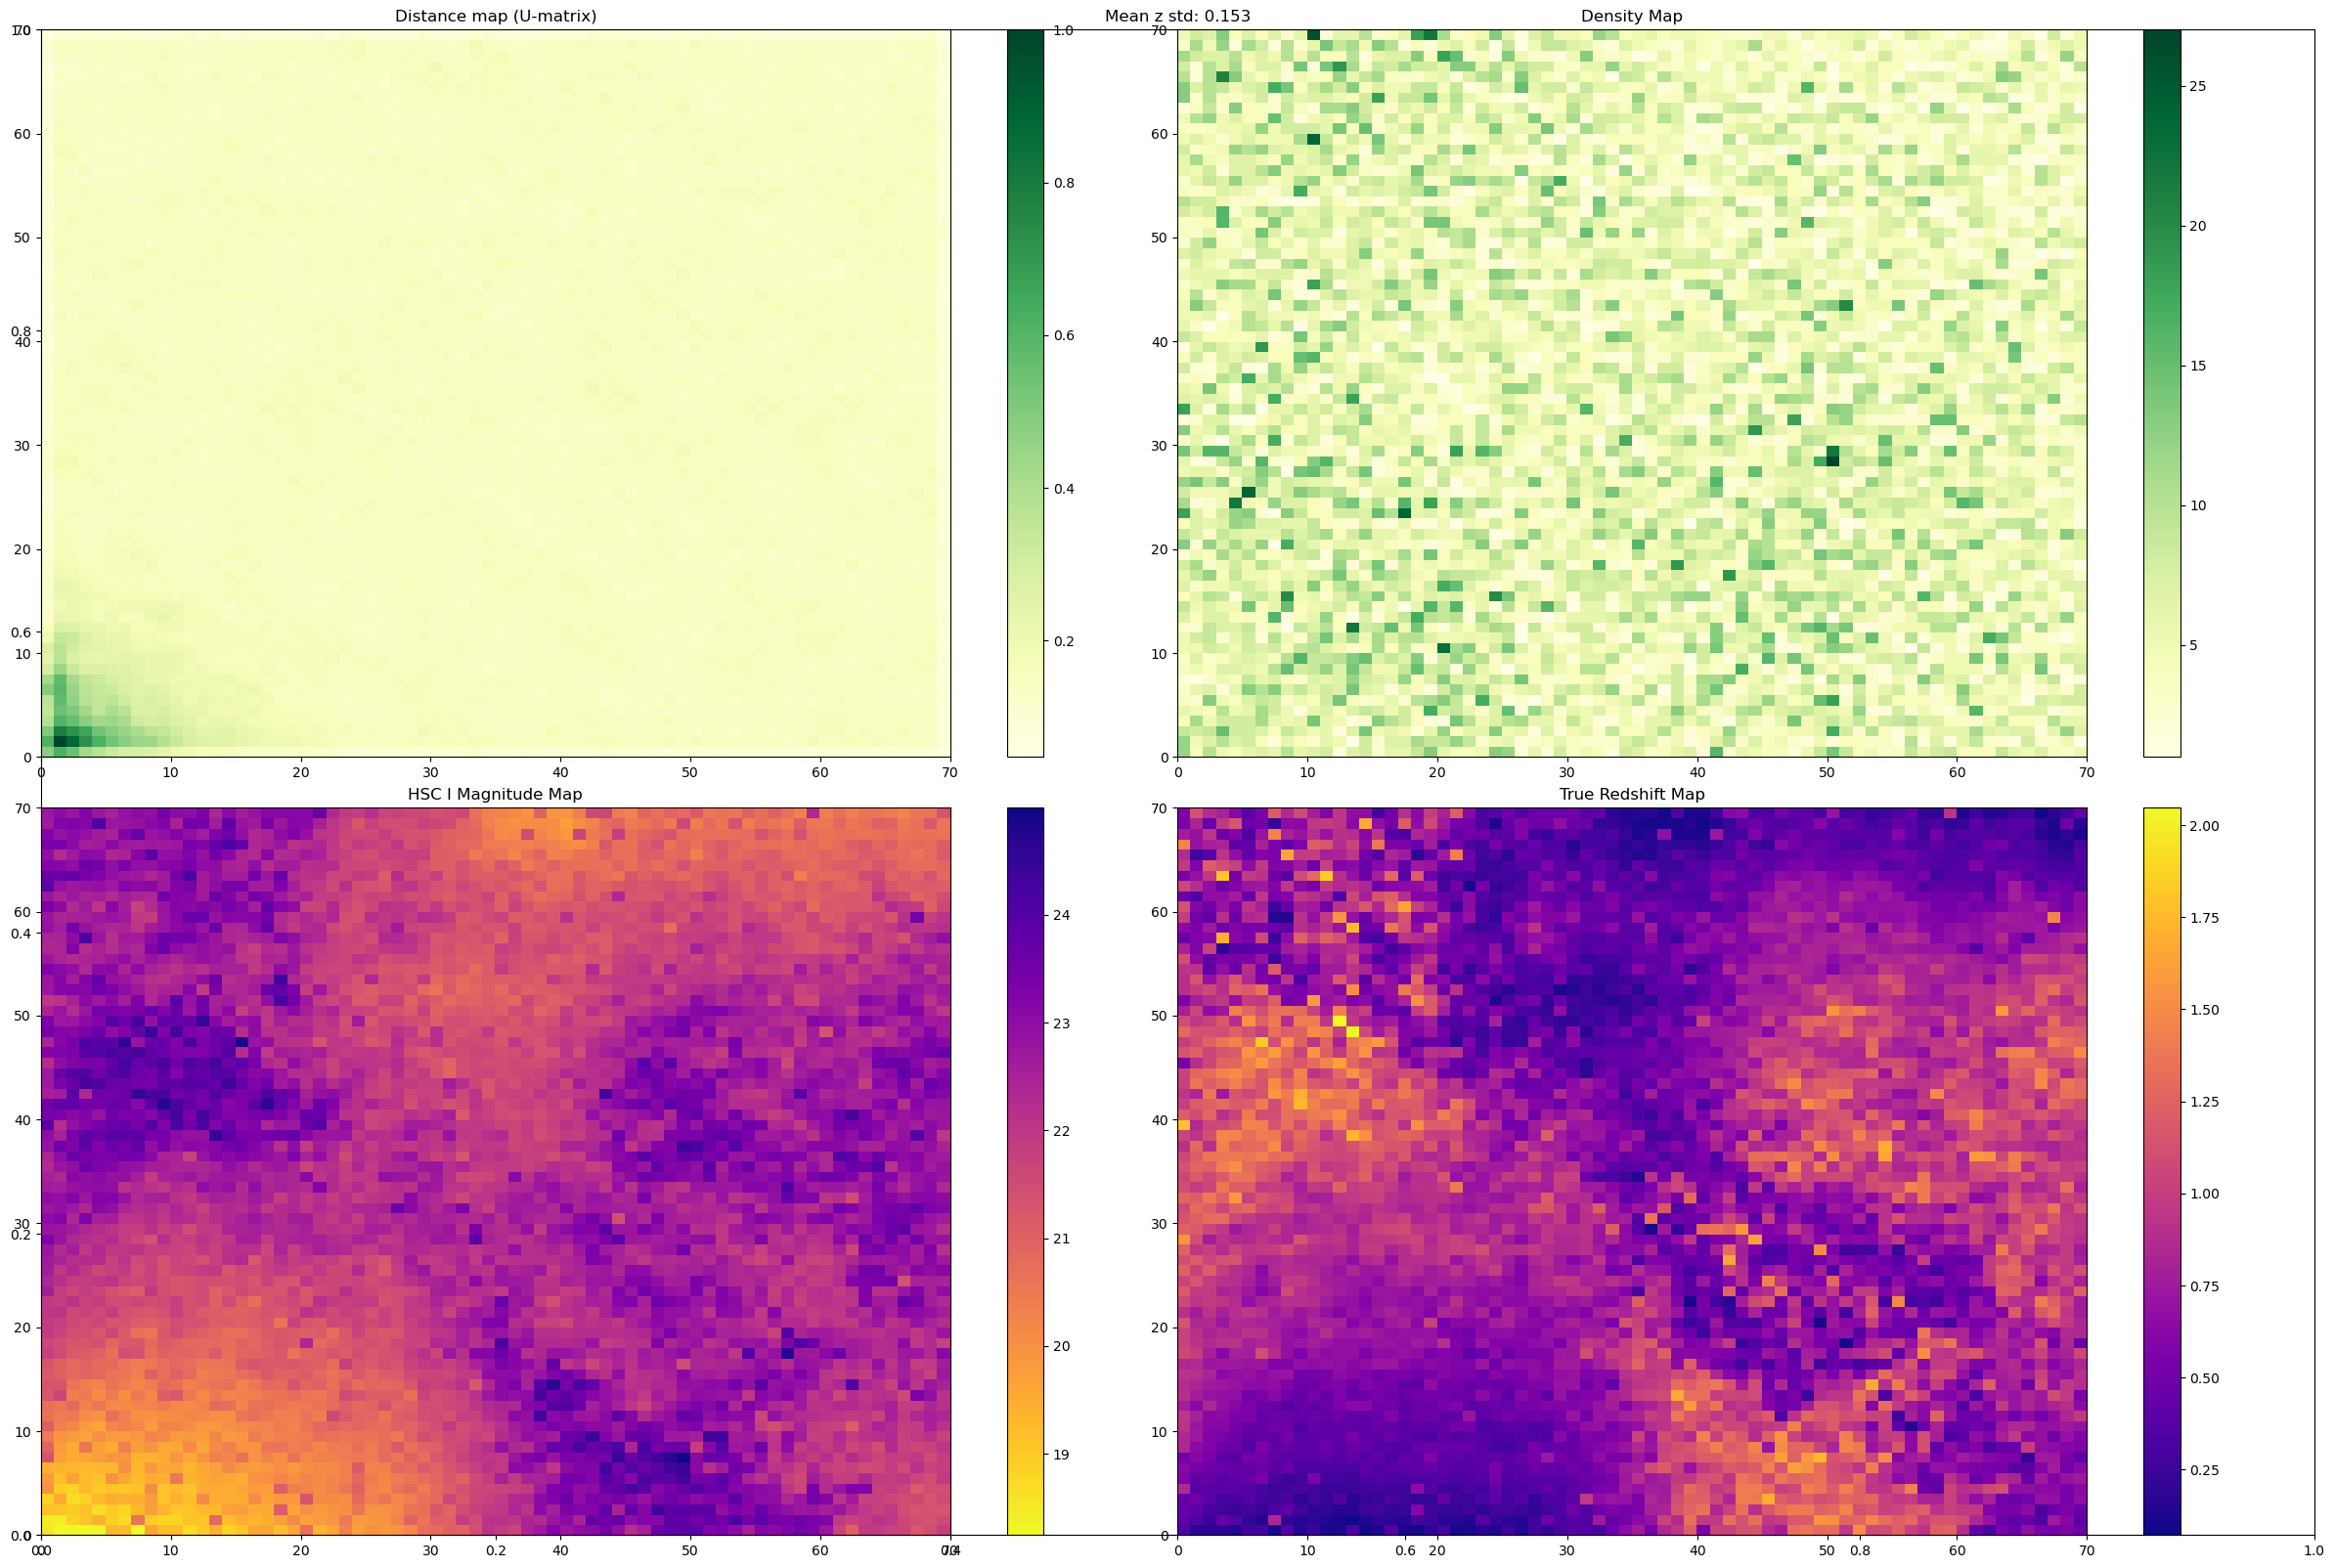

[70, 1.8, 0.85]
Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


29683.0
Topological error: 0.502577232759492
Quantization error: 4.64962449404192
Average redshift std: 0.15291715766107258


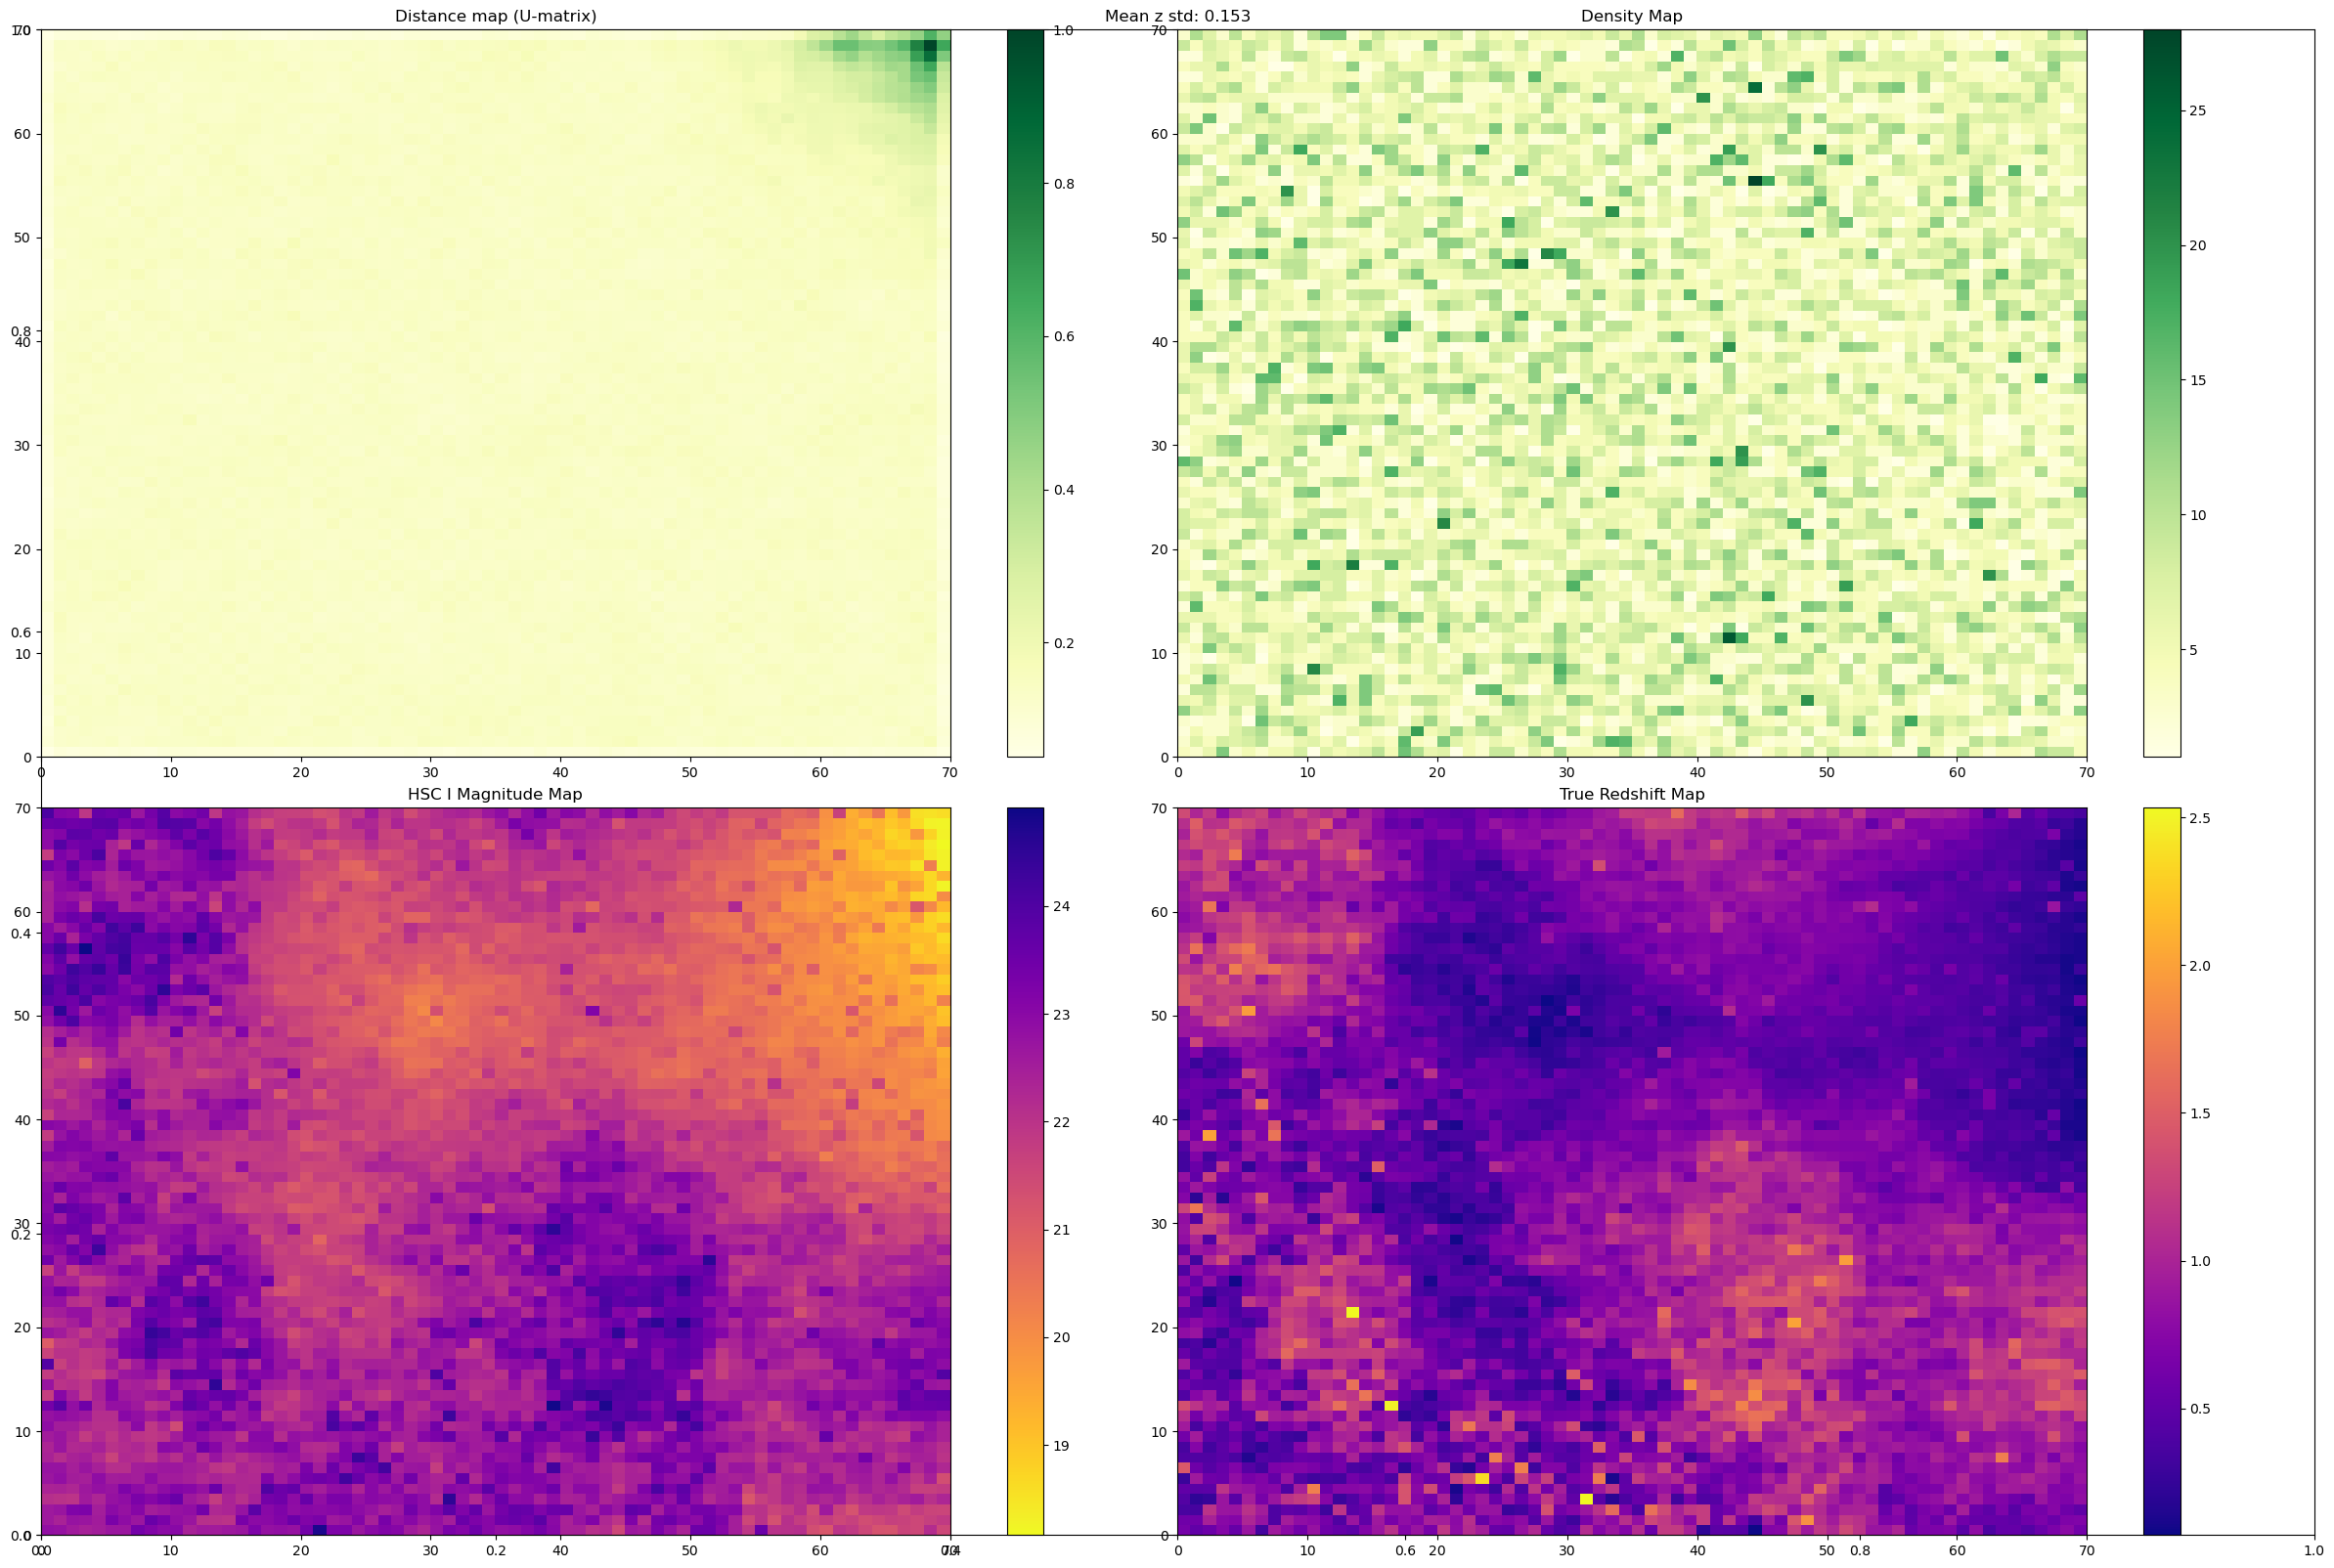

[70, 1.8, 0.9]
Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


29683.0
Topological error: 0.5233635414210154
Quantization error: 4.6449270006195125
Average redshift std: 0.15427073406790656


C:\Users\ASUS\AppData\Local\Temp\ipykernel_34700\1734733816.py:59: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_34700\1734733816.py:64: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


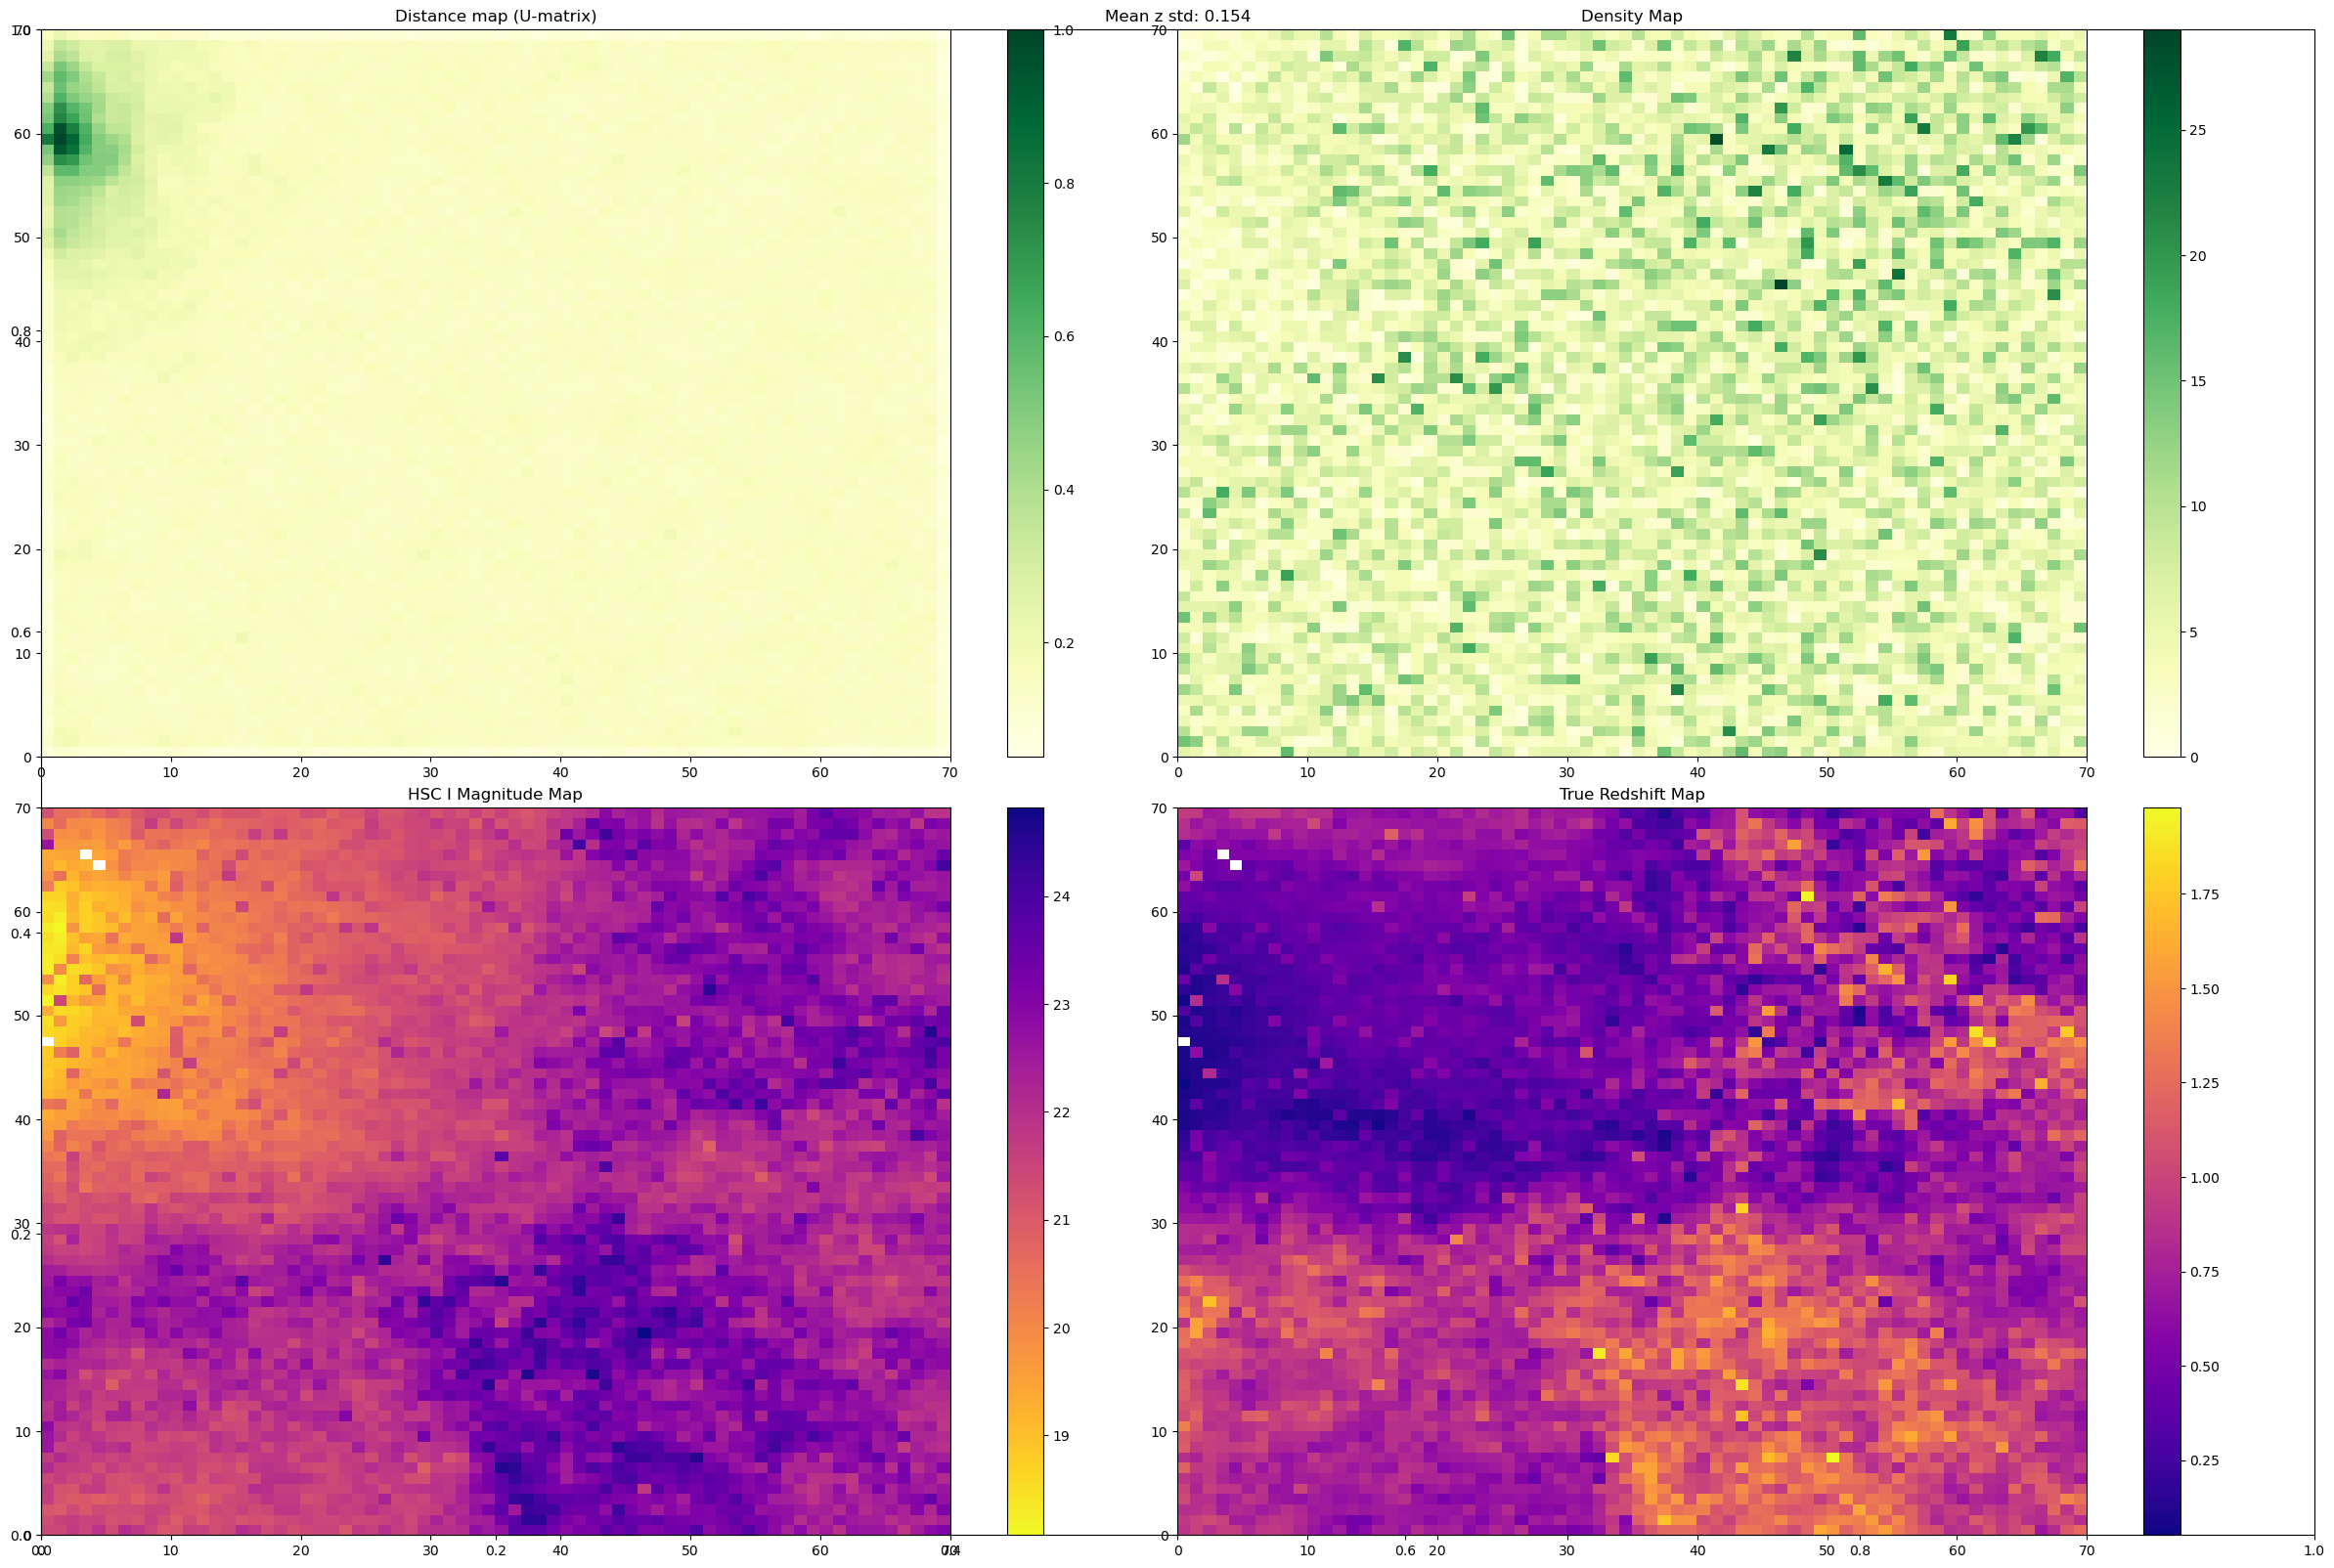

[70, 1.8, 0.95]
Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


29683.0
Topological error: 0.5293939291850555
Quantization error: 4.6423035801553425
Average redshift std: 0.15395555792199908


C:\Users\ASUS\AppData\Local\Temp\ipykernel_34700\1734733816.py:59: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_34700\1734733816.py:64: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


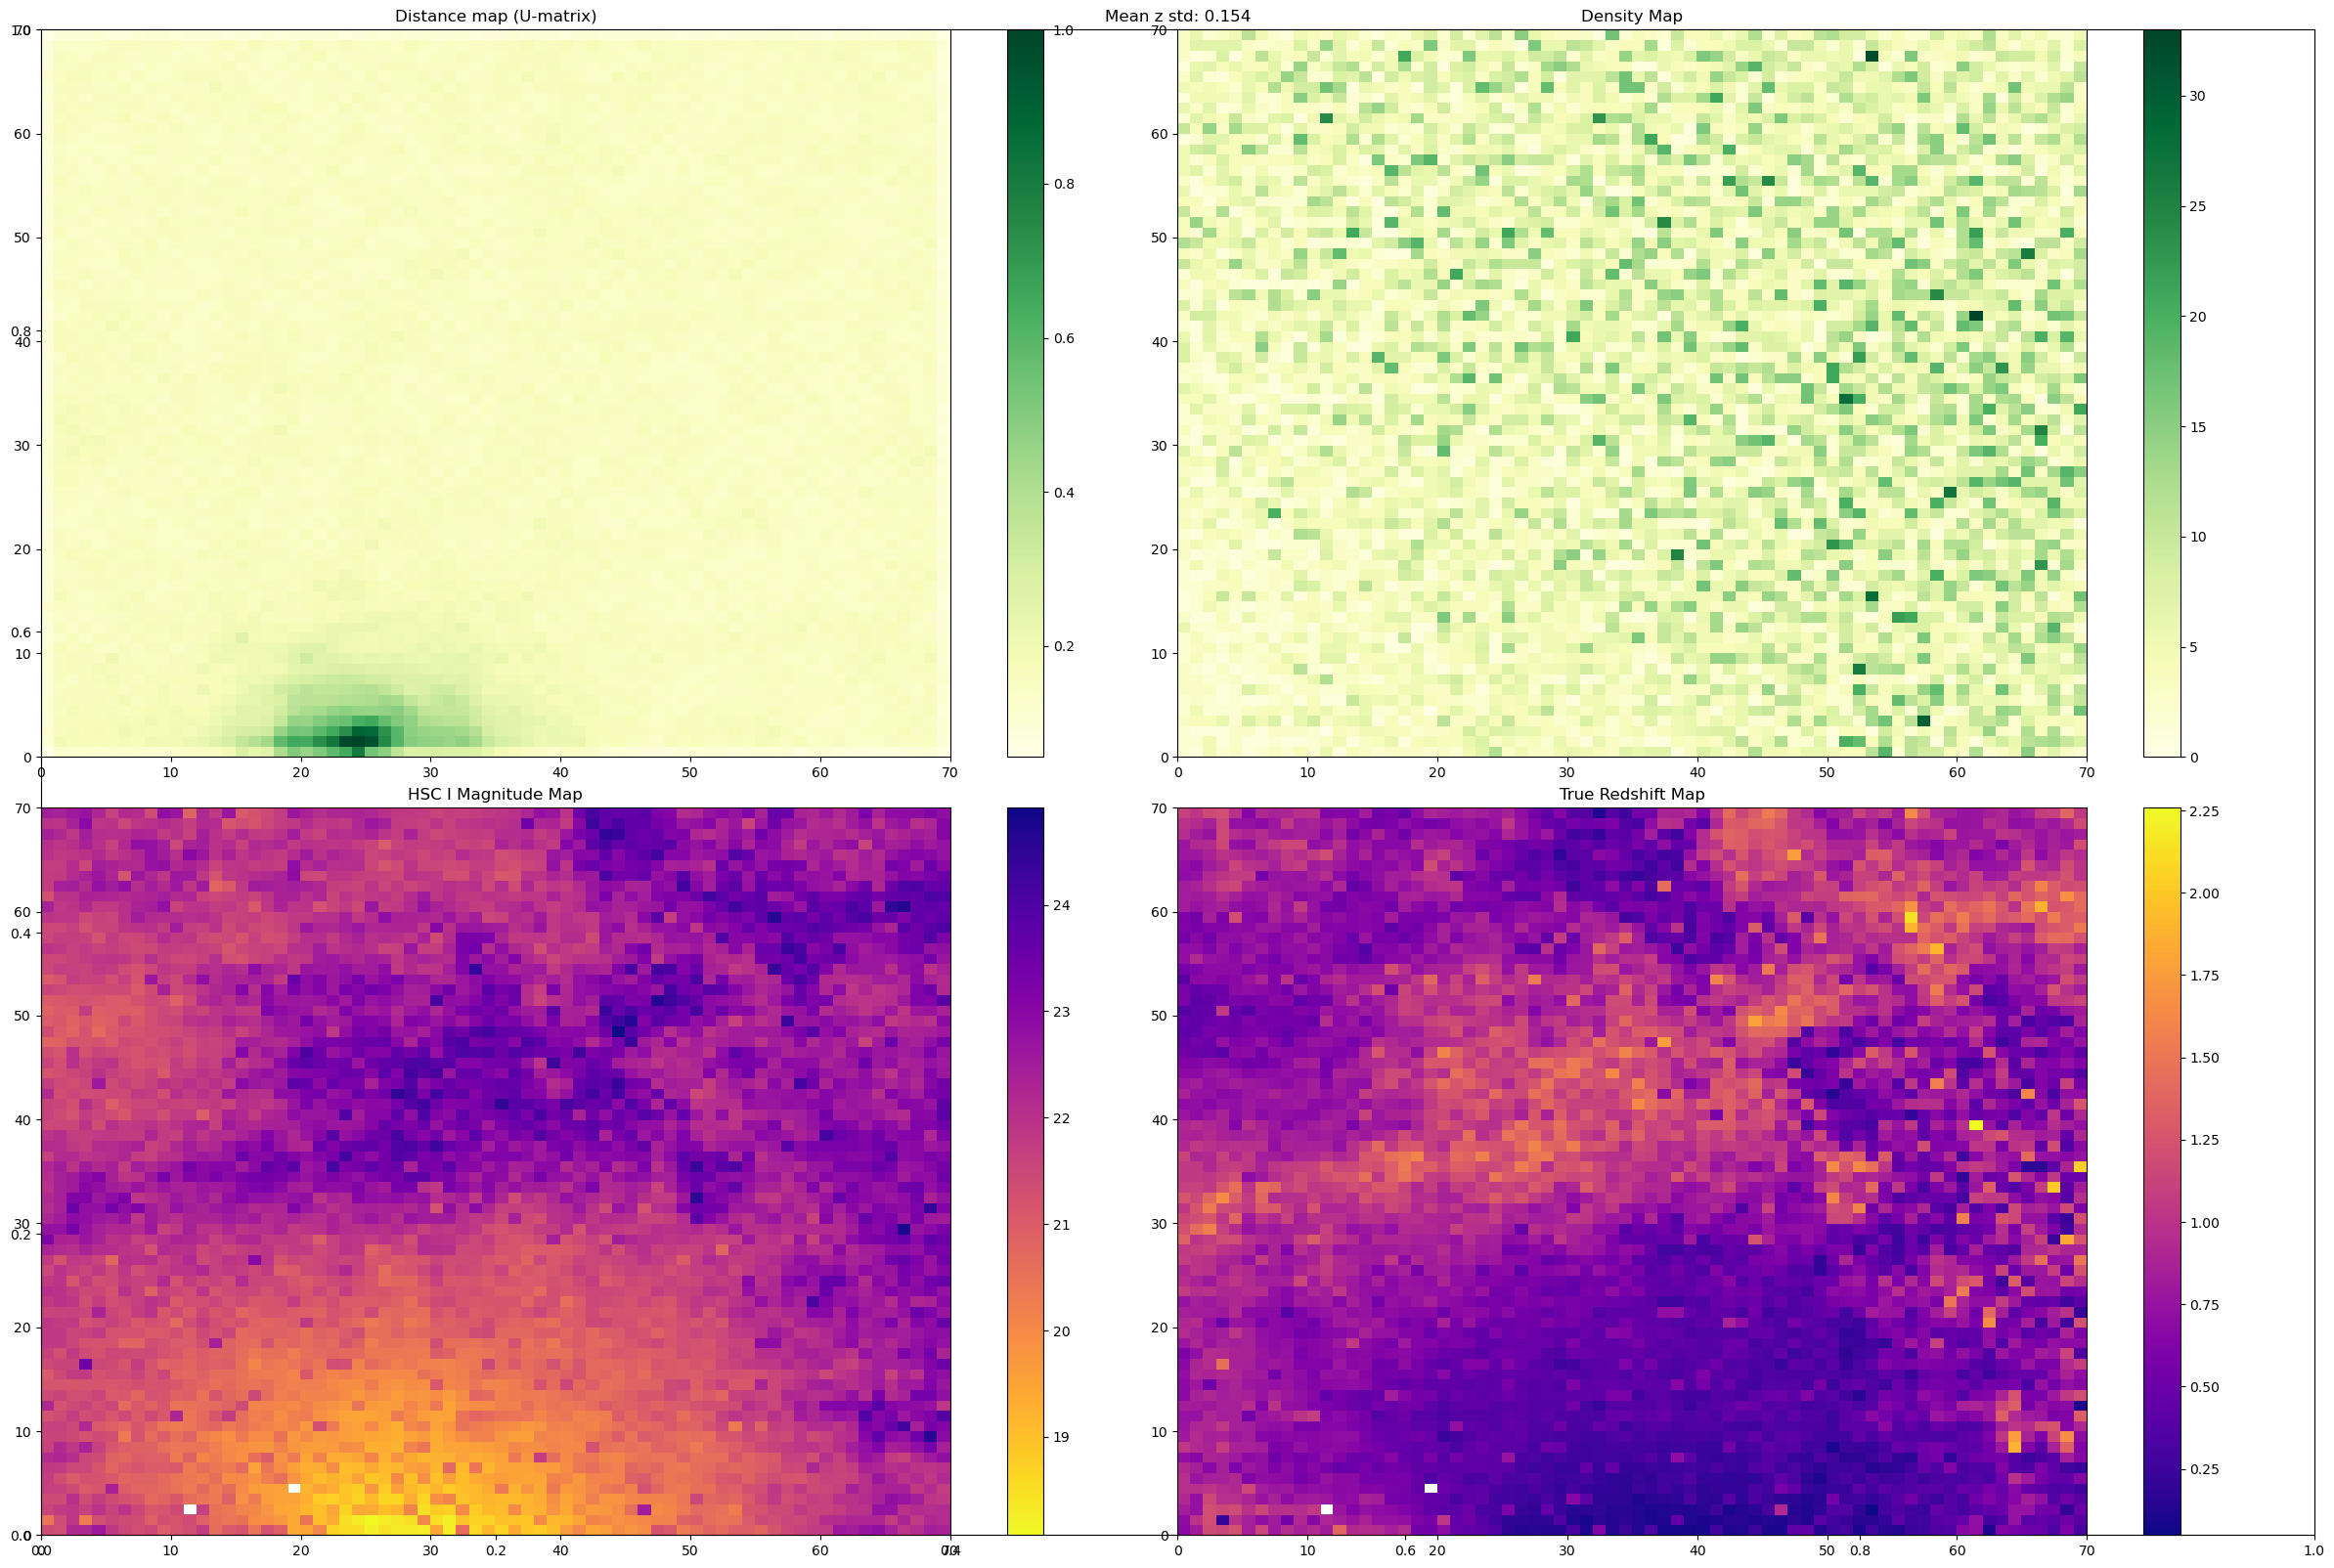

[70, 1.8, 1.0]
Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


29683.0
Topological error: 0.5328639288481622
Quantization error: 4.63743108500924
Average redshift std: 0.156983187689394


C:\Users\ASUS\AppData\Local\Temp\ipykernel_34700\1734733816.py:59: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_34700\1734733816.py:64: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


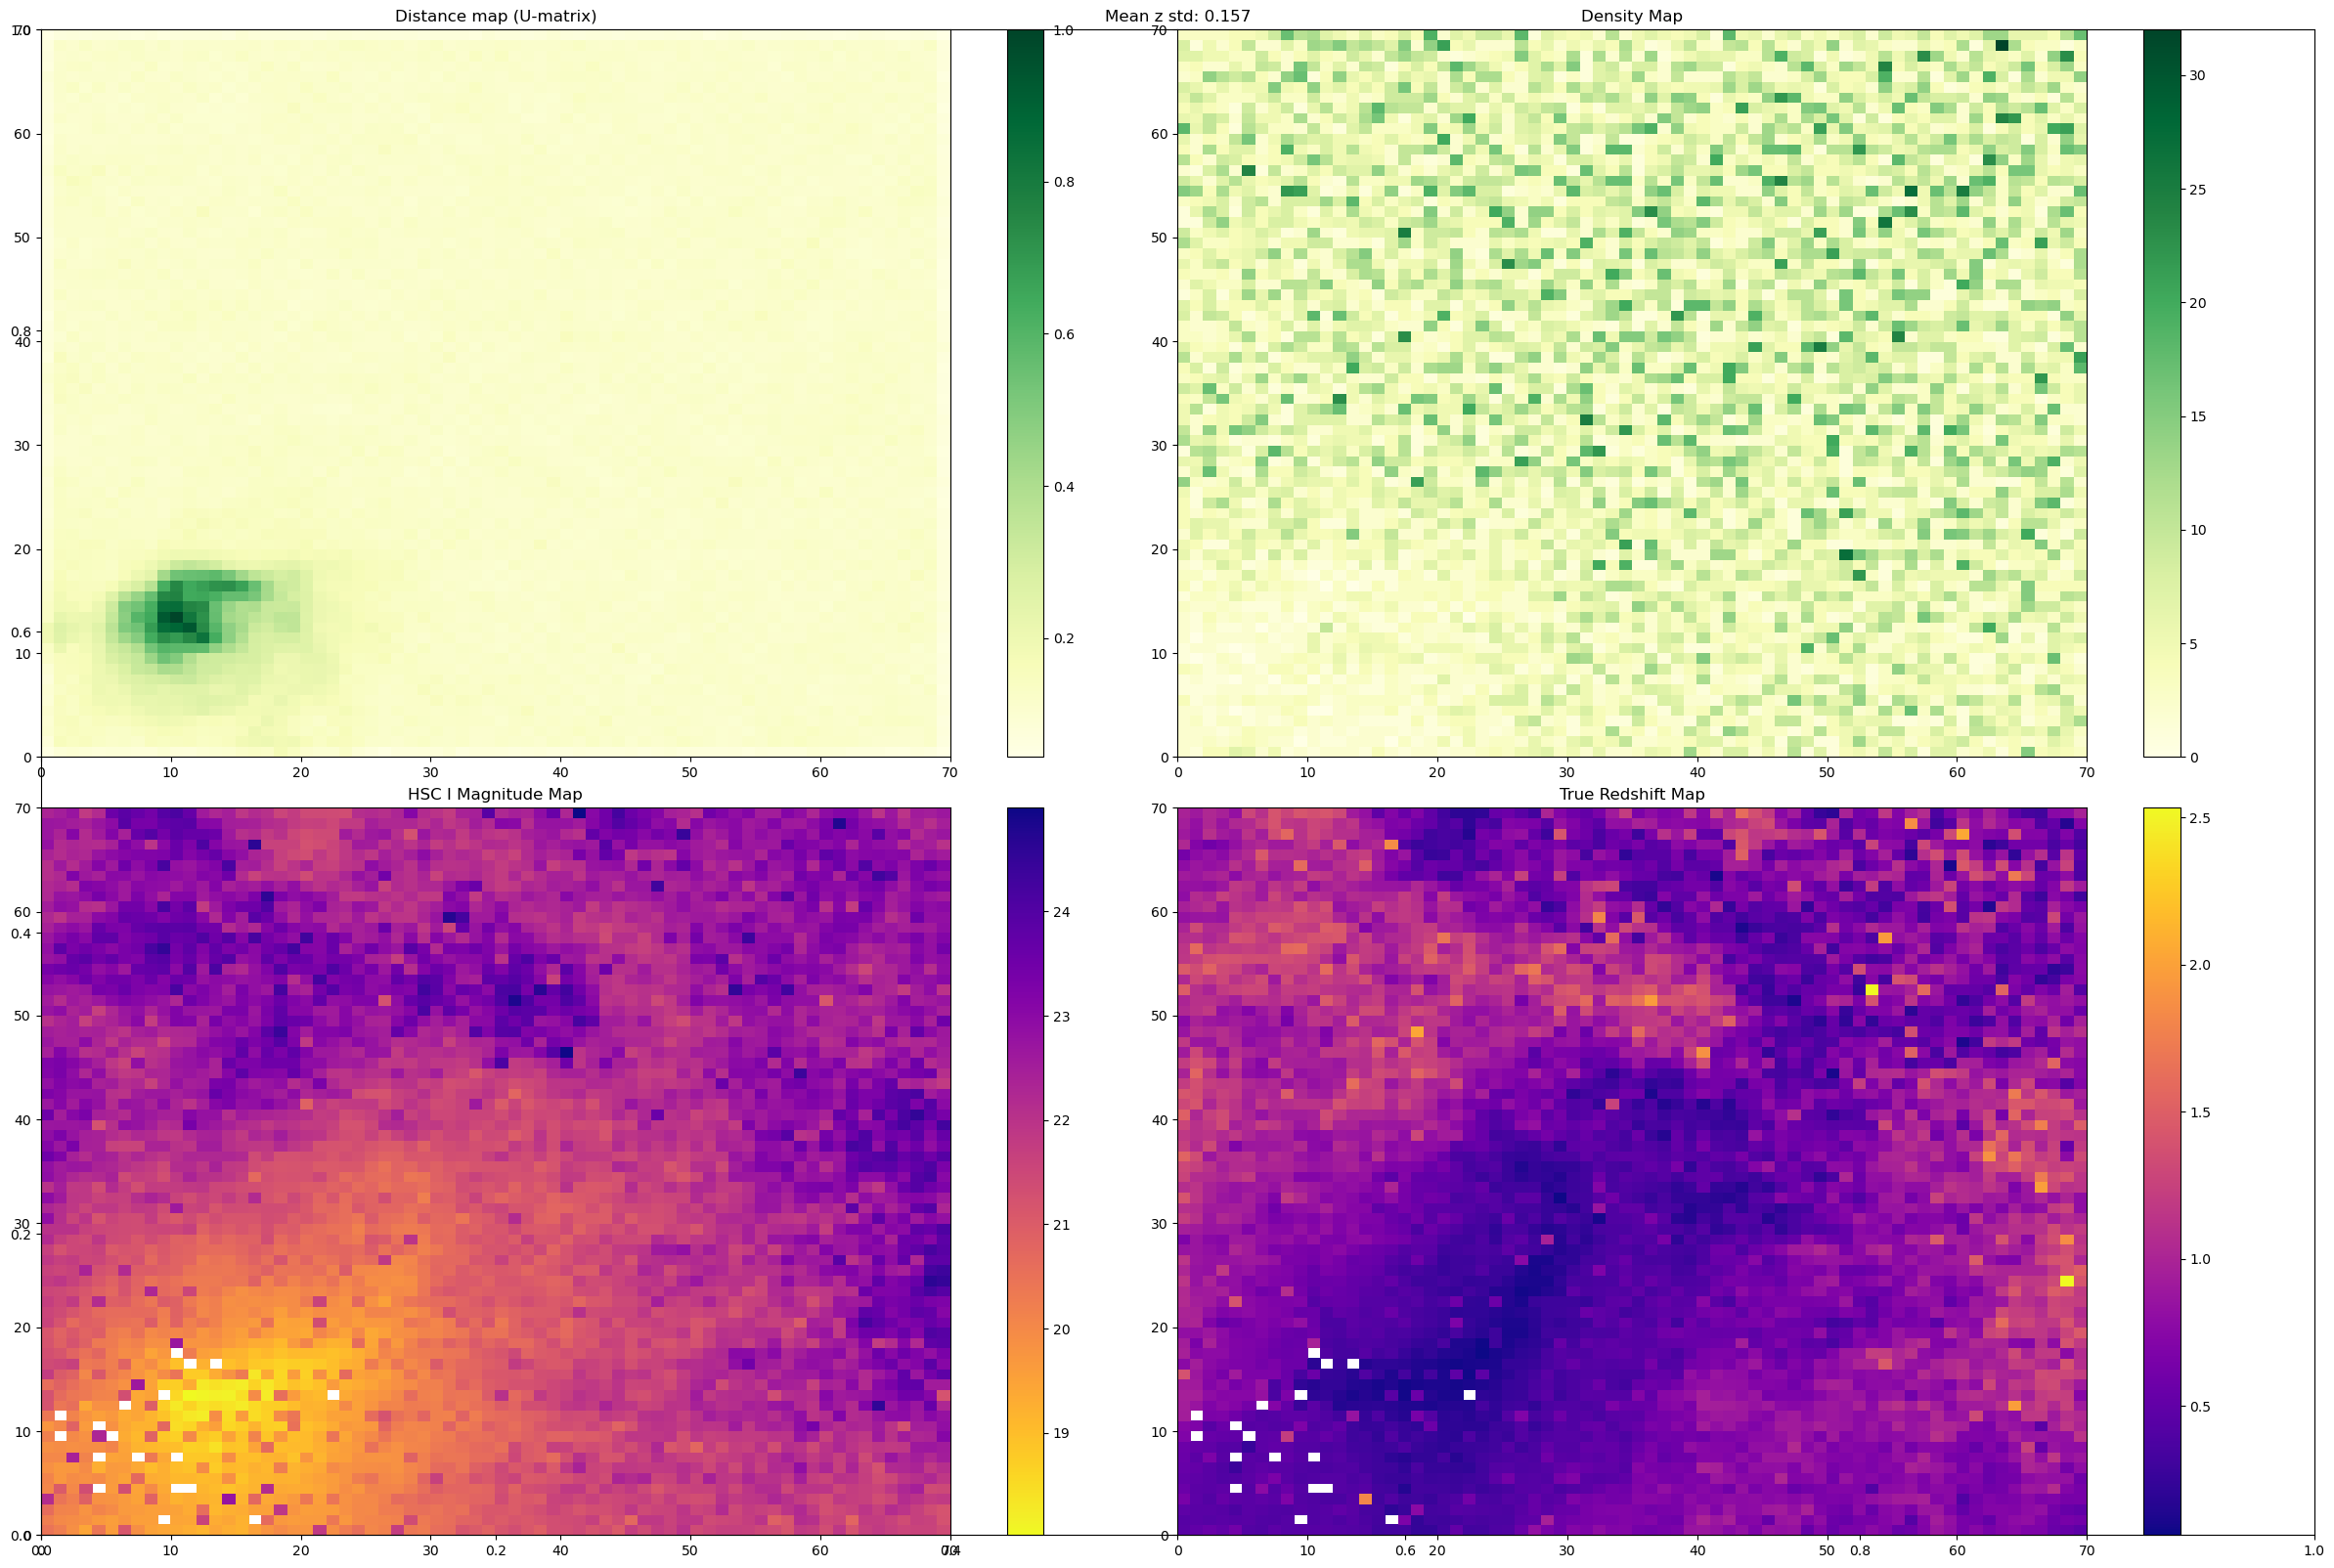

In [35]:
for i in range(1, 21):
    som = basic_som(data = data, data_type = "chi2_lup_shallow", err = err, info_data = info, dim = 70, preproc = "default", iteration = 3, sigma = 1.8, rate = i / 20, b_scale  = 100, save = True, distance = "chi2_distance")

In [ ]:
for i in grid_points(x_cen = 0.54, y_cen = 2.1, x_range = 0.2, y_range = 0.2, x_step = 0.05, y_step = 0.025):
    som = basic_som(data = data, data_type = "chi2_lup_deep", err = err, info_data = info, dim = 70, preproc = "default", iteration = 6, sigma = i[1], rate = i[0], b_scale  = 10, save = True, distance = "chi2_distance")

In [ ]:
for i in range(1, 11):
    som = basic_som(data = data, data_type = "chi2_lup_deep", err = err, info_data = info, dim = 70, preproc = "default", iteration = i, sigma = 2.1, rate = 0.54, b_scale  = 10, save = True, distance = "chi2_distance")

In [ ]:
for i in [0.01, 0.1, 1, 10, 100, 1000, 10000, 10 ** 5, 10 ** 6]:
    som = basic_som(data = data, data_type = "chi2_lup_deep", err = err, info_data = info, dim = 70, preproc = "default", iteration = 3, sigma = 1.7, rate = 1.5, b_scale  = i, save = True, distance = "chi2_distance")

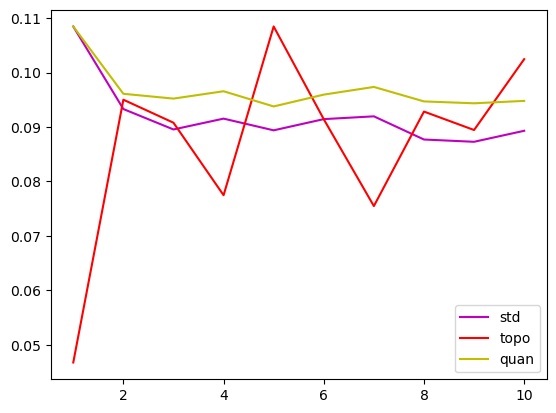

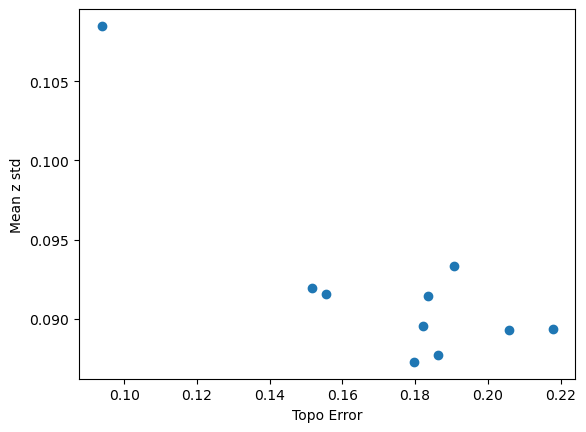

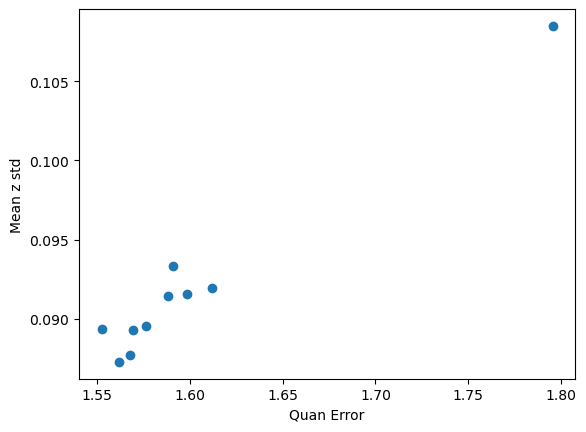

In [15]:
a = os.listdir("D:/SPHEREx_SOM/record/6th_exploration/SOM/")

d = []


for i in a:
    c = []
    if "70_2.1_0.54" in i and "10.pkl" in i:
        with open("D:/SPHEREx_SOM/record/6th_exploration/SOM/" + i, "rb") as fh:
            b = pickle.load(fh)
        c.append(b["iter"])
        c.append(b["mean_z_std"])
        c.append(b["topo_err"])
        c.append(b["quan_err"])
        d.append(c)

def rate_sort(r):
    return r[0]

d.sort(key = rate_sort)
d = np.array(d)



plt.plot(d[:, 0], d[:, 1] / (np.max(d[:, 1]) / np.max(d[:, 1])), label = "std", c = "m")
plt.plot(d[:, 0], d[:, 2] / (np.max(d[:, 2]) / np.max(d[:, 1])), label = "topo", c = "r")
plt.plot(d[:, 0], d[:, 3] / (np.max(d[:, 3]) / np.max(d[:, 1])), label = "quan", c = "y")
plt.legend()
plt.show()

plt.scatter(d[:, 2], d[:, 1])
plt.ylabel("Mean z std")
plt.xlabel("Topo Error")
plt.show()

plt.scatter(d[:, 3], d[:, 1])
plt.ylabel("Mean z std")
plt.xlabel("Quan Error")
plt.show()